In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 256
hidden_1 = 256
hidden_2 = 256
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.fc0   = nn.Linear(input_length, hidden_0)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.act0  = nn.SiLU()
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = nn.Linear(hidden_0, hidden_1)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.act1  = nn.SiLU()
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = nn.Linear(hidden_1, hidden_2)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.act2  = nn.SiLU()
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = nn.Linear(hidden_2, output_length)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.drop0(self.act0(self.bn0(self.fc0(out))))
        out = self.drop1(self.act1(self.bn1(self.fc1(out))))
        out = self.drop2(self.act2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2469, Acc: 0.9233 | Val Loss: 0.1486, Acc: 0.9557


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9643 | Val Loss: 0.1062, Acc: 0.9674


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0927, Acc: 0.9703 | Val Loss: 0.0827, Acc: 0.9758


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9781 | Val Loss: 0.0836, Acc: 0.9755


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9808 | Val Loss: 0.0942, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9844 | Val Loss: 0.0831, Acc: 0.9767


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9849 | Val Loss: 0.0828, Acc: 0.9757


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 0.0812, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0821, Acc: 0.9783


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.0994, Acc: 0.9749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9896 | Val Loss: 0.0999, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.0867, Acc: 0.9797


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0799, Acc: 0.9817


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0933, Acc: 0.9773


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0891, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0992, Acc: 0.9788


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0896, Acc: 0.9804


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.0841, Acc: 0.9814


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0835, Acc: 0.9824


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0928, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0880, Acc: 0.9805


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0998, Acc: 0.9802


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0945, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0847, Acc: 0.9819


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0996, Acc: 0.9805


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0937, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0884, Acc: 0.9820


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0980, Acc: 0.9798


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0910, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0996, Acc: 0.9794


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0936, Acc: 0.9816


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9966 | Val Loss: 0.1031, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1033, Acc: 0.9820


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1138, Acc: 0.9785


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0983, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1054, Acc: 0.9811


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0999, Acc: 0.9822


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1001, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1026, Acc: 0.9811


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0990, Acc: 0.9814


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1122, Acc: 0.9809


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0994, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0884, Acc: 0.9827


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1021, Acc: 0.9826


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1127, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1052, Acc: 0.9803


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1058, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0967, Acc: 0.9837


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0966, Acc: 0.9813


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0894, Acc: 0.9839


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1024, Acc: 0.9825


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0954, Acc: 0.9832


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1079, Acc: 0.9802


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0944, Acc: 0.9841


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1543, Acc: 0.9767


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1230, Acc: 0.9812


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.1034, Acc: 0.9833


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1210, Acc: 0.9811


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9977 | Val Loss: 0.0995, Acc: 0.9824


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0954, Acc: 0.9833


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1059, Acc: 0.9820


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1131, Acc: 0.9818


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1072, Acc: 0.9829


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0994, Acc: 0.9853


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1134, Acc: 0.9808


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1294, Acc: 0.9811


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1053, Acc: 0.9832


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1050, Acc: 0.9846


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1268, Acc: 0.9807


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1150, Acc: 0.9827


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1291, Acc: 0.9818


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1067, Acc: 0.9824


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1323, Acc: 0.9803


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1152, Acc: 0.9834


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1082, Acc: 0.9836


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1198, Acc: 0.9842


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1114, Acc: 0.9827


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1253, Acc: 0.9818


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1116, Acc: 0.9836


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1065, Acc: 0.9840


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1244, Acc: 0.9818


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0994, Acc: 0.9833


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1176, Acc: 0.9823


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1339, Acc: 0.9820


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1110, Acc: 0.9832


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1267, Acc: 0.9819


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1029, Acc: 0.9833


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1081, Acc: 0.9828


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1439, Acc: 0.9815


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1277, Acc: 0.9815


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1260, Acc: 0.9824


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1177, Acc: 0.9829


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1350, Acc: 0.9801


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1251, Acc: 0.9806


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1313, Acc: 0.9807


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1265, Acc: 0.9811


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1282, Acc: 0.9816


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1174, Acc: 0.9818


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1152, Acc: 0.9828


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1214, Acc: 0.9818


Final Test Loss: 0.1014 Accuracy: 0.9826


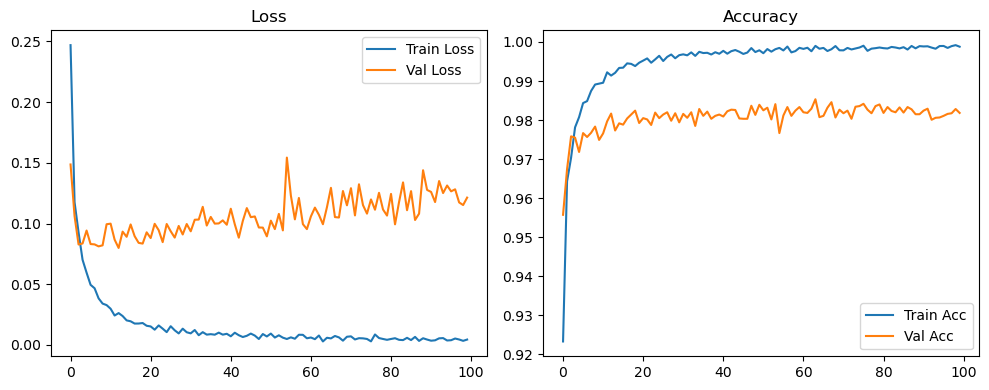

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2812, Acc: 0.9134 | Val Loss: 0.1451, Acc: 0.9567


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1477, Acc: 0.9547 | Val Loss: 0.1065, Acc: 0.9688


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1213, Acc: 0.9622 | Val Loss: 0.0974, Acc: 0.9705


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9689 | Val Loss: 0.0939, Acc: 0.9722


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9725 | Val Loss: 0.0992, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9754 | Val Loss: 0.0783, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9780 | Val Loss: 0.0847, Acc: 0.9763


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9792 | Val Loss: 0.0737, Acc: 0.9786


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9812 | Val Loss: 0.0776, Acc: 0.9782


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9822 | Val Loss: 0.0800, Acc: 0.9782


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9837 | Val Loss: 0.0818, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0704, Acc: 0.9811


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9848 | Val Loss: 0.0756, Acc: 0.9794


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.0882, Acc: 0.9768


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.0841, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.0792, Acc: 0.9802


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9878 | Val Loss: 0.0738, Acc: 0.9818


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.0779, Acc: 0.9808


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.0778, Acc: 0.9812


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0717, Acc: 0.9812


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0725, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.0805, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9912 | Val Loss: 0.0731, Acc: 0.9828


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0775, Acc: 0.9832


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.0781, Acc: 0.9821


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.0773, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9923 | Val Loss: 0.0769, Acc: 0.9822


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0821, Acc: 0.9808


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.0833, Acc: 0.9816


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0835, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9928 | Val Loss: 0.0760, Acc: 0.9829


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.0825, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9928 | Val Loss: 0.0773, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0817, Acc: 0.9837


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0879, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0836, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9937 | Val Loss: 0.0829, Acc: 0.9835


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0912, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0857, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0841, Acc: 0.9832


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0831, Acc: 0.9828


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0824, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.0837, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0776, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0954, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.0860, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0842, Acc: 0.9831


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0848, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0942, Acc: 0.9829


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.0917, Acc: 0.9815


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.0878, Acc: 0.9828


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0928, Acc: 0.9833


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.0929, Acc: 0.9810


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0984, Acc: 0.9816


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9951 | Val Loss: 0.0932, Acc: 0.9823


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0872, Acc: 0.9824


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9955 | Val Loss: 0.0907, Acc: 0.9824


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0920, Acc: 0.9822


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.0846, Acc: 0.9834


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9958 | Val Loss: 0.0852, Acc: 0.9824


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0861, Acc: 0.9831


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0950, Acc: 0.9837


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0915, Acc: 0.9833


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9954 | Val Loss: 0.0836, Acc: 0.9831


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0983, Acc: 0.9826


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9959 | Val Loss: 0.1016, Acc: 0.9813


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9947 | Val Loss: 0.0878, Acc: 0.9825


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.0930, Acc: 0.9835


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0953, Acc: 0.9828


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0948, Acc: 0.9835


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0898, Acc: 0.9843


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0978, Acc: 0.9822


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0927, Acc: 0.9842


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9955 | Val Loss: 0.1026, Acc: 0.9832


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1017, Acc: 0.9824


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0922, Acc: 0.9834


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0935, Acc: 0.9829


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.0966, Acc: 0.9843


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.0873, Acc: 0.9842


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0913, Acc: 0.9842


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0994, Acc: 0.9823


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0960, Acc: 0.9825


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.1010, Acc: 0.9832


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9967 | Val Loss: 0.0959, Acc: 0.9832


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9959 | Val Loss: 0.0954, Acc: 0.9837


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9961 | Val Loss: 0.0997, Acc: 0.9841


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.1033, Acc: 0.9822


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.0914, Acc: 0.9836


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.0989, Acc: 0.9838


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1090, Acc: 0.9825


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0994, Acc: 0.9823


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0859, Acc: 0.9842


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1019, Acc: 0.9837


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1107, Acc: 0.9839


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9966 | Val Loss: 0.1056, Acc: 0.9841


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9962 | Val Loss: 0.0912, Acc: 0.9836


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.0888, Acc: 0.9844


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1041, Acc: 0.9812


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0957, Acc: 0.9830


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0992, Acc: 0.9841


Final Test Loss: 0.1074 Accuracy: 0.9852


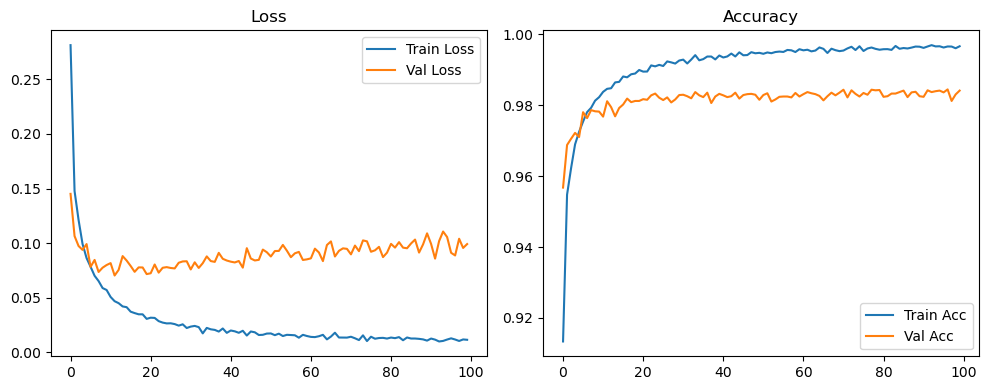

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3977, Acc: 0.8788 | Val Loss: 0.1592, Acc: 0.9503


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2340, Acc: 0.9294 | Val Loss: 0.1315, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2004, Acc: 0.9400 | Val Loss: 0.1020, Acc: 0.9690


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1721, Acc: 0.9491 | Val Loss: 0.0996, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1599, Acc: 0.9516 | Val Loss: 0.0917, Acc: 0.9735


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9553 | Val Loss: 0.0862, Acc: 0.9744


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1399, Acc: 0.9578 | Val Loss: 0.0868, Acc: 0.9742


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9605 | Val Loss: 0.0831, Acc: 0.9758


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1273, Acc: 0.9621 | Val Loss: 0.0742, Acc: 0.9776


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1229, Acc: 0.9631 | Val Loss: 0.0768, Acc: 0.9767


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1130, Acc: 0.9648 | Val Loss: 0.0809, Acc: 0.9762


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1103, Acc: 0.9656 | Val Loss: 0.0752, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9689 | Val Loss: 0.0754, Acc: 0.9796


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9670 | Val Loss: 0.0730, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9688 | Val Loss: 0.0779, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1013, Acc: 0.9690 | Val Loss: 0.0752, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0932, Acc: 0.9711 | Val Loss: 0.0752, Acc: 0.9788


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9722 | Val Loss: 0.0725, Acc: 0.9808


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9718 | Val Loss: 0.0744, Acc: 0.9795


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9732 | Val Loss: 0.0699, Acc: 0.9795


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9737 | Val Loss: 0.0728, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9745 | Val Loss: 0.0654, Acc: 0.9810


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9745 | Val Loss: 0.0710, Acc: 0.9801


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9747 | Val Loss: 0.0690, Acc: 0.9810


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.0746, Acc: 0.9797


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9772 | Val Loss: 0.0771, Acc: 0.9800


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.0753, Acc: 0.9813


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9775 | Val Loss: 0.0721, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9786 | Val Loss: 0.0799, Acc: 0.9805


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9779 | Val Loss: 0.0682, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9776 | Val Loss: 0.0649, Acc: 0.9831


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9790 | Val Loss: 0.0711, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9788 | Val Loss: 0.0655, Acc: 0.9826


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9792 | Val Loss: 0.0691, Acc: 0.9830


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9810 | Val Loss: 0.0707, Acc: 0.9815


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9786 | Val Loss: 0.0687, Acc: 0.9825


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9805 | Val Loss: 0.0711, Acc: 0.9819


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9807 | Val Loss: 0.0744, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9801 | Val Loss: 0.0708, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9816 | Val Loss: 0.0739, Acc: 0.9809


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9805 | Val Loss: 0.0743, Acc: 0.9811


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9821 | Val Loss: 0.0782, Acc: 0.9814


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.0787, Acc: 0.9816


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9822 | Val Loss: 0.0723, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9809 | Val Loss: 0.0730, Acc: 0.9811


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9813 | Val Loss: 0.0727, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9827 | Val Loss: 0.0701, Acc: 0.9828


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9828 | Val Loss: 0.0746, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9814 | Val Loss: 0.0713, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9828 | Val Loss: 0.0711, Acc: 0.9826


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0521, Acc: 0.9839 | Val Loss: 0.0764, Acc: 0.9822


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0544, Acc: 0.9834 | Val Loss: 0.0745, Acc: 0.9830


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9831 | Val Loss: 0.0750, Acc: 0.9815


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0563, Acc: 0.9828 | Val Loss: 0.0743, Acc: 0.9819


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0538, Acc: 0.9827 | Val Loss: 0.0729, Acc: 0.9822


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0540, Acc: 0.9833 | Val Loss: 0.0732, Acc: 0.9818


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9835 | Val Loss: 0.0733, Acc: 0.9819


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9843 | Val Loss: 0.0770, Acc: 0.9813


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0494, Acc: 0.9847 | Val Loss: 0.0750, Acc: 0.9811


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9840 | Val Loss: 0.0735, Acc: 0.9823


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0528, Acc: 0.9836 | Val Loss: 0.0757, Acc: 0.9827


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0480, Acc: 0.9850 | Val Loss: 0.0764, Acc: 0.9825


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9836 | Val Loss: 0.0750, Acc: 0.9835


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9839 | Val Loss: 0.0787, Acc: 0.9810


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0526, Acc: 0.9840 | Val Loss: 0.0769, Acc: 0.9811


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9850 | Val Loss: 0.0757, Acc: 0.9824


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9843 | Val Loss: 0.0740, Acc: 0.9831


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0487, Acc: 0.9852 | Val Loss: 0.0758, Acc: 0.9821


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9845 | Val Loss: 0.0801, Acc: 0.9812


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9858 | Val Loss: 0.0741, Acc: 0.9827


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0478, Acc: 0.9850 | Val Loss: 0.0775, Acc: 0.9828


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9855 | Val Loss: 0.0799, Acc: 0.9824


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9856 | Val Loss: 0.0763, Acc: 0.9826


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9857 | Val Loss: 0.0713, Acc: 0.9836


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0460, Acc: 0.9856 | Val Loss: 0.0769, Acc: 0.9829


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9865 | Val Loss: 0.0751, Acc: 0.9825


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9859 | Val Loss: 0.0739, Acc: 0.9836


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0482, Acc: 0.9852 | Val Loss: 0.0739, Acc: 0.9838


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9861 | Val Loss: 0.0789, Acc: 0.9831


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9861 | Val Loss: 0.0737, Acc: 0.9822


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.0871, Acc: 0.9819


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9858 | Val Loss: 0.0768, Acc: 0.9816


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9854 | Val Loss: 0.0816, Acc: 0.9824


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9867 | Val Loss: 0.0756, Acc: 0.9833


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9866 | Val Loss: 0.0819, Acc: 0.9812


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9858 | Val Loss: 0.0731, Acc: 0.9824


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9857 | Val Loss: 0.0755, Acc: 0.9813


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9869 | Val Loss: 0.0736, Acc: 0.9831


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9872 | Val Loss: 0.0749, Acc: 0.9822


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0409, Acc: 0.9874 | Val Loss: 0.0785, Acc: 0.9834


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9878 | Val Loss: 0.0836, Acc: 0.9808


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0453, Acc: 0.9862 | Val Loss: 0.0861, Acc: 0.9808


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.0831, Acc: 0.9824


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9871 | Val Loss: 0.0809, Acc: 0.9817


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9872 | Val Loss: 0.0772, Acc: 0.9822


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9871 | Val Loss: 0.0834, Acc: 0.9829


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9862 | Val Loss: 0.0734, Acc: 0.9831


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0420, Acc: 0.9872 | Val Loss: 0.0812, Acc: 0.9826


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9860 | Val Loss: 0.0788, Acc: 0.9822


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9865 | Val Loss: 0.0764, Acc: 0.9826


Final Test Loss: 0.0659 Accuracy: 0.9852


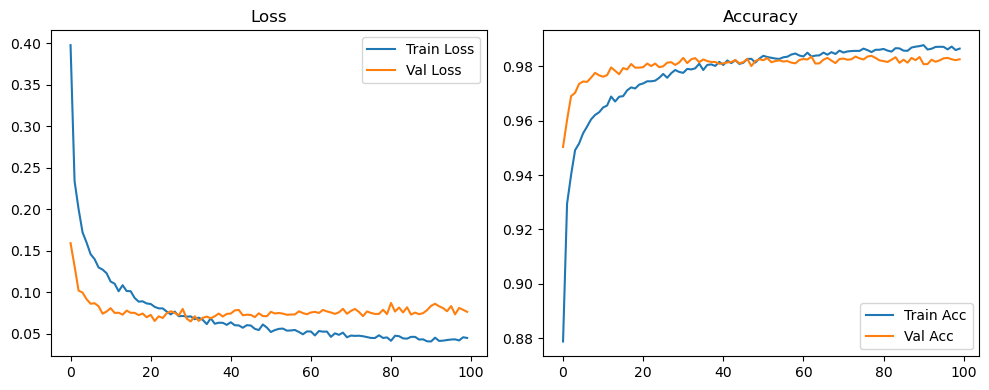

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2469, Acc: 0.9233 | Val Loss: 0.1486, Acc: 0.9557


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9643 | Val Loss: 0.1062, Acc: 0.9674


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0927, Acc: 0.9703 | Val Loss: 0.0827, Acc: 0.9758


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9781 | Val Loss: 0.0836, Acc: 0.9755


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9808 | Val Loss: 0.0942, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9844 | Val Loss: 0.0831, Acc: 0.9767


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9849 | Val Loss: 0.0828, Acc: 0.9757


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 0.0812, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0821, Acc: 0.9783


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.0994, Acc: 0.9749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9896 | Val Loss: 0.0999, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.0867, Acc: 0.9797


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0799, Acc: 0.9817


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0933, Acc: 0.9773


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0891, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0992, Acc: 0.9788


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0896, Acc: 0.9804


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.0841, Acc: 0.9814


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0835, Acc: 0.9824


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0928, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0880, Acc: 0.9805


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0998, Acc: 0.9802


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0945, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0847, Acc: 0.9819


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0996, Acc: 0.9805


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0937, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0884, Acc: 0.9820


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0980, Acc: 0.9798


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0910, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0996, Acc: 0.9794


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0936, Acc: 0.9816


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9966 | Val Loss: 0.1031, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1033, Acc: 0.9820


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1138, Acc: 0.9785


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0983, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1054, Acc: 0.9811


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0999, Acc: 0.9822


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1001, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1026, Acc: 0.9811


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0990, Acc: 0.9814


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1122, Acc: 0.9809


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0994, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0884, Acc: 0.9827


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1021, Acc: 0.9826


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1127, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1052, Acc: 0.9803


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1058, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0967, Acc: 0.9837


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0966, Acc: 0.9813


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0894, Acc: 0.9839


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0909, Acc: 0.9836


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0914, Acc: 0.9858


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0991, Acc: 0.9828


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0981, Acc: 0.9846


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1050, Acc: 0.9833


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1092, Acc: 0.9835


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1065, Acc: 0.9846


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1027, Acc: 0.9844


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1053, Acc: 0.9838


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1038, Acc: 0.9835


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1140, Acc: 0.9837


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1162, Acc: 0.9840


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1241, Acc: 0.9834


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1118, Acc: 0.9845


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1163, Acc: 0.9835


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1239, Acc: 0.9836


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1217, Acc: 0.9834


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1161, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1230, Acc: 0.9822


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1238, Acc: 0.9827


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1162, Acc: 0.9846


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1164, Acc: 0.9830


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1324, Acc: 0.9829


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1189, Acc: 0.9827


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1160, Acc: 0.9835


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1123, Acc: 0.9838


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1191, Acc: 0.9837


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1183, Acc: 0.9838


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1258, Acc: 0.9836


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1205, Acc: 0.9841


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1189, Acc: 0.9848


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1148, Acc: 0.9848


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1201, Acc: 0.9843


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1149, Acc: 0.9847


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1205, Acc: 0.9838


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1172, Acc: 0.9853


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1151, Acc: 0.9848


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1202, Acc: 0.9850


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1134, Acc: 0.9858


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1147, Acc: 0.9860


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1195, Acc: 0.9857


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1187, Acc: 0.9845


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1182, Acc: 0.9852


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1234, Acc: 0.9848


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1229, Acc: 0.9855


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1150, Acc: 0.9860


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1213, Acc: 0.9865


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1139, Acc: 0.9863


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1264, Acc: 0.9848


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1267, Acc: 0.9851


Final Test Loss: 0.1194 Accuracy: 0.9855


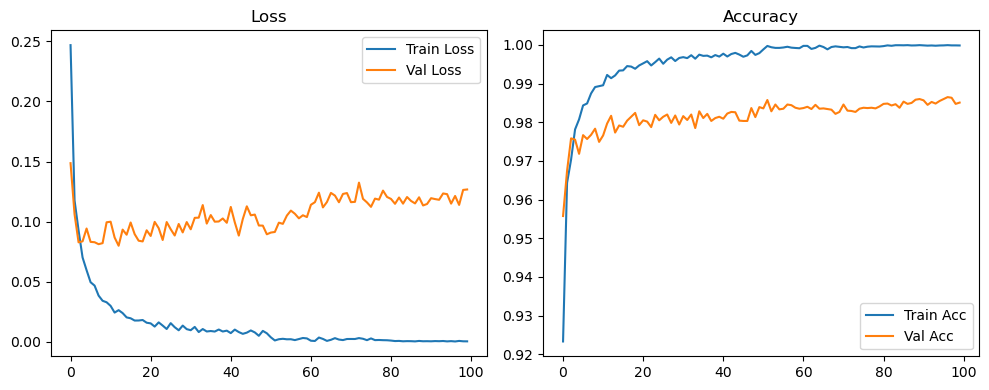

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2812, Acc: 0.9134 | Val Loss: 0.1451, Acc: 0.9567


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1477, Acc: 0.9547 | Val Loss: 0.1065, Acc: 0.9688


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1213, Acc: 0.9622 | Val Loss: 0.0974, Acc: 0.9705


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9689 | Val Loss: 0.0939, Acc: 0.9722


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9725 | Val Loss: 0.0992, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9754 | Val Loss: 0.0783, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9780 | Val Loss: 0.0847, Acc: 0.9763


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9792 | Val Loss: 0.0737, Acc: 0.9786


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9812 | Val Loss: 0.0776, Acc: 0.9782


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9822 | Val Loss: 0.0800, Acc: 0.9782


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9837 | Val Loss: 0.0818, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0704, Acc: 0.9811


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9848 | Val Loss: 0.0756, Acc: 0.9794


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.0882, Acc: 0.9768


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.0841, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.0792, Acc: 0.9802


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9878 | Val Loss: 0.0738, Acc: 0.9818


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.0779, Acc: 0.9808


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.0778, Acc: 0.9812


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0717, Acc: 0.9812


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0725, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.0805, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9912 | Val Loss: 0.0731, Acc: 0.9828


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0775, Acc: 0.9832


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.0781, Acc: 0.9821


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.0773, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9923 | Val Loss: 0.0769, Acc: 0.9822


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0821, Acc: 0.9808


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.0833, Acc: 0.9816


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0835, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9928 | Val Loss: 0.0760, Acc: 0.9829


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.0825, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9928 | Val Loss: 0.0773, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0817, Acc: 0.9837


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0879, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0836, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9937 | Val Loss: 0.0829, Acc: 0.9835


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0912, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0857, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0841, Acc: 0.9832


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0831, Acc: 0.9828


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0824, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.0837, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0776, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0954, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.0860, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0842, Acc: 0.9831


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0848, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0942, Acc: 0.9829


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.0917, Acc: 0.9815


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0869, Acc: 0.9834


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0845, Acc: 0.9848


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0807, Acc: 0.9833


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0930, Acc: 0.9841


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0911, Acc: 0.9838


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0918, Acc: 0.9828


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0900, Acc: 0.9838


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0937, Acc: 0.9833


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0878, Acc: 0.9837


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0801, Acc: 0.9852


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0864, Acc: 0.9846


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0913, Acc: 0.9851


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0975, Acc: 0.9828


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0925, Acc: 0.9842


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1002, Acc: 0.9831


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0967, Acc: 0.9835


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0865, Acc: 0.9832


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1016, Acc: 0.9827


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0951, Acc: 0.9837


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0912, Acc: 0.9843


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0947, Acc: 0.9840


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1069, Acc: 0.9829


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0955, Acc: 0.9847


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1010, Acc: 0.9832


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0929, Acc: 0.9851


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0929, Acc: 0.9842


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1015, Acc: 0.9837


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0927, Acc: 0.9844


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0968, Acc: 0.9831


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0972, Acc: 0.9838


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0878, Acc: 0.9850


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0877, Acc: 0.9848


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0921, Acc: 0.9850


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0866, Acc: 0.9844


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0873, Acc: 0.9852


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0933, Acc: 0.9849


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0877, Acc: 0.9842


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0889, Acc: 0.9843


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0919, Acc: 0.9839


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0930, Acc: 0.9846


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0906, Acc: 0.9838


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0940, Acc: 0.9847


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0892, Acc: 0.9838


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0950, Acc: 0.9839


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0945, Acc: 0.9856


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0913, Acc: 0.9850


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0945, Acc: 0.9849


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0955, Acc: 0.9853


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0986, Acc: 0.9842


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0935, Acc: 0.9843


Final Test Loss: 0.0937 Accuracy: 0.9862


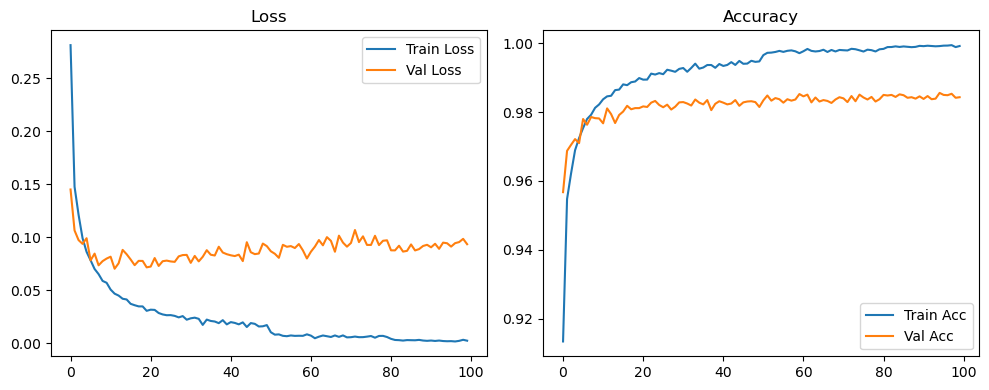

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3977, Acc: 0.8788 | Val Loss: 0.1592, Acc: 0.9503


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2340, Acc: 0.9294 | Val Loss: 0.1315, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2004, Acc: 0.9400 | Val Loss: 0.1020, Acc: 0.9690


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1721, Acc: 0.9491 | Val Loss: 0.0996, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1599, Acc: 0.9516 | Val Loss: 0.0917, Acc: 0.9735


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9553 | Val Loss: 0.0862, Acc: 0.9744


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1399, Acc: 0.9578 | Val Loss: 0.0868, Acc: 0.9742


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9605 | Val Loss: 0.0831, Acc: 0.9758


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1273, Acc: 0.9621 | Val Loss: 0.0742, Acc: 0.9776


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1229, Acc: 0.9631 | Val Loss: 0.0768, Acc: 0.9767


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1130, Acc: 0.9648 | Val Loss: 0.0809, Acc: 0.9762


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1103, Acc: 0.9656 | Val Loss: 0.0752, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9689 | Val Loss: 0.0754, Acc: 0.9796


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9670 | Val Loss: 0.0730, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9688 | Val Loss: 0.0779, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1013, Acc: 0.9690 | Val Loss: 0.0752, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0932, Acc: 0.9711 | Val Loss: 0.0752, Acc: 0.9788


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9722 | Val Loss: 0.0725, Acc: 0.9808


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9718 | Val Loss: 0.0744, Acc: 0.9795


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9732 | Val Loss: 0.0699, Acc: 0.9795


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9737 | Val Loss: 0.0728, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9745 | Val Loss: 0.0654, Acc: 0.9810


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9745 | Val Loss: 0.0710, Acc: 0.9801


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9747 | Val Loss: 0.0690, Acc: 0.9810


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.0746, Acc: 0.9797


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9772 | Val Loss: 0.0771, Acc: 0.9800


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.0753, Acc: 0.9813


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9775 | Val Loss: 0.0721, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9786 | Val Loss: 0.0799, Acc: 0.9805


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9779 | Val Loss: 0.0682, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9776 | Val Loss: 0.0649, Acc: 0.9831


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9790 | Val Loss: 0.0711, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9788 | Val Loss: 0.0655, Acc: 0.9826


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9792 | Val Loss: 0.0691, Acc: 0.9830


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9810 | Val Loss: 0.0707, Acc: 0.9815


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9786 | Val Loss: 0.0687, Acc: 0.9825


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9805 | Val Loss: 0.0711, Acc: 0.9819


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9807 | Val Loss: 0.0744, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9801 | Val Loss: 0.0708, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9816 | Val Loss: 0.0739, Acc: 0.9809


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9805 | Val Loss: 0.0743, Acc: 0.9811


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9821 | Val Loss: 0.0782, Acc: 0.9814


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.0787, Acc: 0.9816


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9822 | Val Loss: 0.0723, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9809 | Val Loss: 0.0730, Acc: 0.9811


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9813 | Val Loss: 0.0727, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9827 | Val Loss: 0.0701, Acc: 0.9828


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9828 | Val Loss: 0.0746, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9814 | Val Loss: 0.0713, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9828 | Val Loss: 0.0711, Acc: 0.9826


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.0687, Acc: 0.9834


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.0696, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.0691, Acc: 0.9826


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.0674, Acc: 0.9830


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 0.0709, Acc: 0.9826


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0688, Acc: 0.9825


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9883 | Val Loss: 0.0687, Acc: 0.9831


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9881 | Val Loss: 0.0709, Acc: 0.9832


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0752, Acc: 0.9828


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9896 | Val Loss: 0.0717, Acc: 0.9828


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9885 | Val Loss: 0.0698, Acc: 0.9838


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.0717, Acc: 0.9837


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.0689, Acc: 0.9838


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.0714, Acc: 0.9842


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9887 | Val Loss: 0.0746, Acc: 0.9835


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9904 | Val Loss: 0.0739, Acc: 0.9831


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9895 | Val Loss: 0.0729, Acc: 0.9836


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.0747, Acc: 0.9828


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0735, Acc: 0.9834


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.0674, Acc: 0.9844


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.0721, Acc: 0.9838


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9902 | Val Loss: 0.0744, Acc: 0.9832


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9901 | Val Loss: 0.0726, Acc: 0.9840


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 0.0716, Acc: 0.9831


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9900 | Val Loss: 0.0716, Acc: 0.9845


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9912 | Val Loss: 0.0727, Acc: 0.9832


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9906 | Val Loss: 0.0719, Acc: 0.9834


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9899 | Val Loss: 0.0752, Acc: 0.9833


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.0711, Acc: 0.9839


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.0703, Acc: 0.9842


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.0711, Acc: 0.9842


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.0655, Acc: 0.9851


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9922 | Val Loss: 0.0696, Acc: 0.9837


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9930 | Val Loss: 0.0673, Acc: 0.9846


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0674, Acc: 0.9848


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.0681, Acc: 0.9845


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9927 | Val Loss: 0.0670, Acc: 0.9838


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.0691, Acc: 0.9839


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0687, Acc: 0.9844


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0714, Acc: 0.9849


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0739, Acc: 0.9850


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0746, Acc: 0.9839


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0714, Acc: 0.9842


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.0762, Acc: 0.9842


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9938 | Val Loss: 0.0742, Acc: 0.9845


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.0745, Acc: 0.9845


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0750, Acc: 0.9841


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0749, Acc: 0.9840


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0731, Acc: 0.9838


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0731, Acc: 0.9841


Final Test Loss: 0.0654 Accuracy: 0.9856


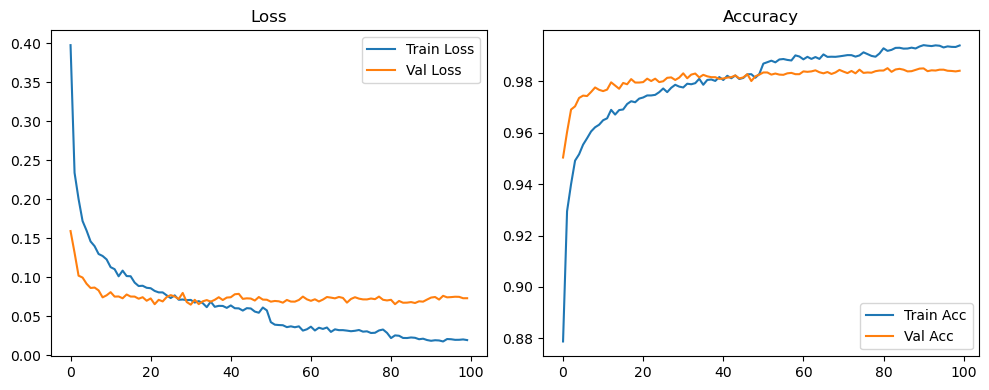

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2469, Acc: 0.9233 | Val Loss: 0.1486, Acc: 0.9557


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9643 | Val Loss: 0.1062, Acc: 0.9674


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0927, Acc: 0.9703 | Val Loss: 0.0827, Acc: 0.9758


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9781 | Val Loss: 0.0836, Acc: 0.9755


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9808 | Val Loss: 0.0942, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9844 | Val Loss: 0.0831, Acc: 0.9767


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9849 | Val Loss: 0.0828, Acc: 0.9757


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 0.0812, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0821, Acc: 0.9783


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.0994, Acc: 0.9749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9896 | Val Loss: 0.0999, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.0867, Acc: 0.9797


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0799, Acc: 0.9817


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0933, Acc: 0.9773


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0891, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0992, Acc: 0.9788


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0896, Acc: 0.9804


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.0841, Acc: 0.9814


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0835, Acc: 0.9824


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0928, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0880, Acc: 0.9805


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0998, Acc: 0.9802


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0945, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0847, Acc: 0.9819


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0996, Acc: 0.9805


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0937, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0884, Acc: 0.9820


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0980, Acc: 0.9798


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0910, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0996, Acc: 0.9794


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0936, Acc: 0.9816


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9966 | Val Loss: 0.1031, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1033, Acc: 0.9820


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1138, Acc: 0.9785


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0983, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1054, Acc: 0.9811


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0999, Acc: 0.9822


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1001, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1026, Acc: 0.9811


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0990, Acc: 0.9814


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1122, Acc: 0.9809


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0994, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0884, Acc: 0.9827


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1021, Acc: 0.9826


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1127, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1052, Acc: 0.9803


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1058, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0967, Acc: 0.9837


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0966, Acc: 0.9813


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0894, Acc: 0.9839


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0909, Acc: 0.9836


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0914, Acc: 0.9858


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0991, Acc: 0.9828


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0981, Acc: 0.9846


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1050, Acc: 0.9833


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1092, Acc: 0.9835


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1065, Acc: 0.9846


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1027, Acc: 0.9844


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1053, Acc: 0.9838


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1038, Acc: 0.9835


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1140, Acc: 0.9837


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1162, Acc: 0.9840


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1241, Acc: 0.9834


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1118, Acc: 0.9845


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1163, Acc: 0.9835


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1239, Acc: 0.9836


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1217, Acc: 0.9834


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1161, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1230, Acc: 0.9822


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1238, Acc: 0.9827


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1162, Acc: 0.9846


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1164, Acc: 0.9830


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1324, Acc: 0.9829


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1189, Acc: 0.9827


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1160, Acc: 0.9835


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1123, Acc: 0.9838


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1191, Acc: 0.9837


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1183, Acc: 0.9838


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1258, Acc: 0.9836


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1205, Acc: 0.9841


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1181, Acc: 0.9851


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1161, Acc: 0.9849


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1176, Acc: 0.9852


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1122, Acc: 0.9853


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1152, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1155, Acc: 0.9854


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1117, Acc: 0.9854


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1180, Acc: 0.9840


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1164, Acc: 0.9852


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1155, Acc: 0.9855


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1150, Acc: 0.9859


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1162, Acc: 0.9851


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1167, Acc: 0.9855


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1168, Acc: 0.9856


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1157, Acc: 0.9865


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1170, Acc: 0.9855


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1223, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1195, Acc: 0.9849


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1222, Acc: 0.9853


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1185, Acc: 0.9860


Final Test Loss: 0.1074 Accuracy: 0.9872


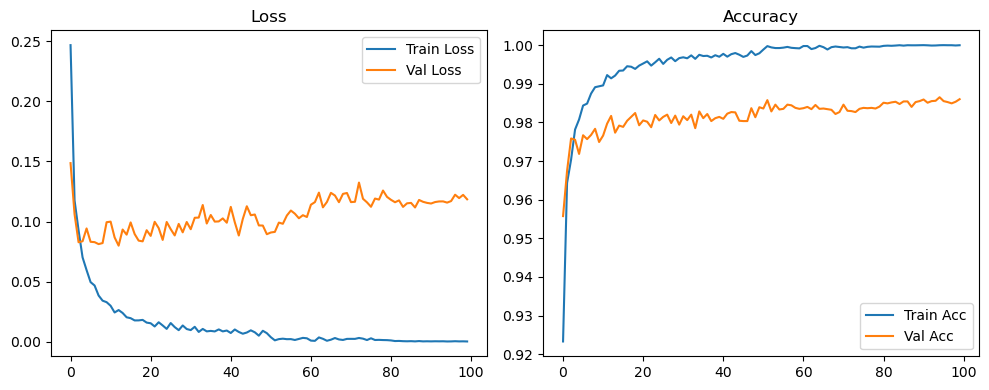

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2812, Acc: 0.9134 | Val Loss: 0.1451, Acc: 0.9567


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1477, Acc: 0.9547 | Val Loss: 0.1065, Acc: 0.9688


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1213, Acc: 0.9622 | Val Loss: 0.0974, Acc: 0.9705


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9689 | Val Loss: 0.0939, Acc: 0.9722


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9725 | Val Loss: 0.0992, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9754 | Val Loss: 0.0783, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9780 | Val Loss: 0.0847, Acc: 0.9763


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9792 | Val Loss: 0.0737, Acc: 0.9786


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9812 | Val Loss: 0.0776, Acc: 0.9782


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9822 | Val Loss: 0.0800, Acc: 0.9782


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9837 | Val Loss: 0.0818, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0704, Acc: 0.9811


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9848 | Val Loss: 0.0756, Acc: 0.9794


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.0882, Acc: 0.9768


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.0841, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.0792, Acc: 0.9802


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9878 | Val Loss: 0.0738, Acc: 0.9818


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.0779, Acc: 0.9808


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.0778, Acc: 0.9812


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0717, Acc: 0.9812


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0725, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.0805, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9912 | Val Loss: 0.0731, Acc: 0.9828


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0775, Acc: 0.9832


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.0781, Acc: 0.9821


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.0773, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9923 | Val Loss: 0.0769, Acc: 0.9822


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0821, Acc: 0.9808


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.0833, Acc: 0.9816


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0835, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9928 | Val Loss: 0.0760, Acc: 0.9829


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.0825, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9928 | Val Loss: 0.0773, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0817, Acc: 0.9837


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0879, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0836, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9937 | Val Loss: 0.0829, Acc: 0.9835


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0912, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0857, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0841, Acc: 0.9832


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0831, Acc: 0.9828


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0824, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.0837, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0776, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0954, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.0860, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0842, Acc: 0.9831


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0848, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0942, Acc: 0.9829


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.0917, Acc: 0.9815


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0869, Acc: 0.9834


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0845, Acc: 0.9848


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0807, Acc: 0.9833


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0930, Acc: 0.9841


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0911, Acc: 0.9838


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0918, Acc: 0.9828


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0900, Acc: 0.9838


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0937, Acc: 0.9833


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0878, Acc: 0.9837


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0801, Acc: 0.9852


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0864, Acc: 0.9846


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0913, Acc: 0.9851


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0975, Acc: 0.9828


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0925, Acc: 0.9842


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1002, Acc: 0.9831


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0967, Acc: 0.9835


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0865, Acc: 0.9832


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1016, Acc: 0.9827


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0951, Acc: 0.9837


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0912, Acc: 0.9843


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0947, Acc: 0.9840


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1069, Acc: 0.9829


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0955, Acc: 0.9847


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1010, Acc: 0.9832


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0929, Acc: 0.9851


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0929, Acc: 0.9842


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1015, Acc: 0.9837


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0927, Acc: 0.9844


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0968, Acc: 0.9831


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0972, Acc: 0.9838


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.0884, Acc: 0.9851


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0874, Acc: 0.9850


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0897, Acc: 0.9851


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0852, Acc: 0.9853


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0852, Acc: 0.9851


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0892, Acc: 0.9853


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0853, Acc: 0.9858


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0869, Acc: 0.9849


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0883, Acc: 0.9848


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0879, Acc: 0.9850


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0885, Acc: 0.9848


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0881, Acc: 0.9844


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0862, Acc: 0.9846


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0901, Acc: 0.9856


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0883, Acc: 0.9853


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0869, Acc: 0.9850


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0886, Acc: 0.9853


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0882, Acc: 0.9859


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0912, Acc: 0.9852


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0880, Acc: 0.9850


Final Test Loss: 0.0905 Accuracy: 0.9866


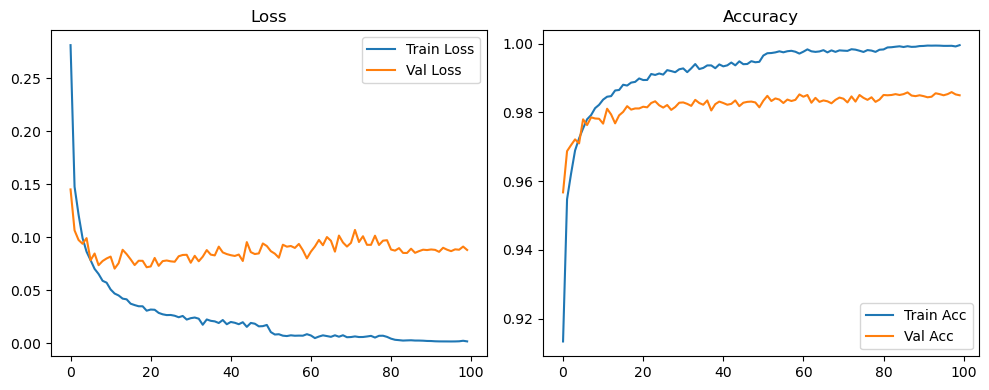

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3977, Acc: 0.8788 | Val Loss: 0.1592, Acc: 0.9503


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2340, Acc: 0.9294 | Val Loss: 0.1315, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2004, Acc: 0.9400 | Val Loss: 0.1020, Acc: 0.9690


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1721, Acc: 0.9491 | Val Loss: 0.0996, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1599, Acc: 0.9516 | Val Loss: 0.0917, Acc: 0.9735


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9553 | Val Loss: 0.0862, Acc: 0.9744


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1399, Acc: 0.9578 | Val Loss: 0.0868, Acc: 0.9742


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9605 | Val Loss: 0.0831, Acc: 0.9758


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1273, Acc: 0.9621 | Val Loss: 0.0742, Acc: 0.9776


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1229, Acc: 0.9631 | Val Loss: 0.0768, Acc: 0.9767


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1130, Acc: 0.9648 | Val Loss: 0.0809, Acc: 0.9762


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1103, Acc: 0.9656 | Val Loss: 0.0752, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9689 | Val Loss: 0.0754, Acc: 0.9796


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9670 | Val Loss: 0.0730, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9688 | Val Loss: 0.0779, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1013, Acc: 0.9690 | Val Loss: 0.0752, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0932, Acc: 0.9711 | Val Loss: 0.0752, Acc: 0.9788


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9722 | Val Loss: 0.0725, Acc: 0.9808


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9718 | Val Loss: 0.0744, Acc: 0.9795


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9732 | Val Loss: 0.0699, Acc: 0.9795


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9737 | Val Loss: 0.0728, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9745 | Val Loss: 0.0654, Acc: 0.9810


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9745 | Val Loss: 0.0710, Acc: 0.9801


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9747 | Val Loss: 0.0690, Acc: 0.9810


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.0746, Acc: 0.9797


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9772 | Val Loss: 0.0771, Acc: 0.9800


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.0753, Acc: 0.9813


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9775 | Val Loss: 0.0721, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9786 | Val Loss: 0.0799, Acc: 0.9805


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9779 | Val Loss: 0.0682, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9776 | Val Loss: 0.0649, Acc: 0.9831


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9790 | Val Loss: 0.0711, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9788 | Val Loss: 0.0655, Acc: 0.9826


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9792 | Val Loss: 0.0691, Acc: 0.9830


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9810 | Val Loss: 0.0707, Acc: 0.9815


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9786 | Val Loss: 0.0687, Acc: 0.9825


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9805 | Val Loss: 0.0711, Acc: 0.9819


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9807 | Val Loss: 0.0744, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9801 | Val Loss: 0.0708, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9816 | Val Loss: 0.0739, Acc: 0.9809


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9805 | Val Loss: 0.0743, Acc: 0.9811


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9821 | Val Loss: 0.0782, Acc: 0.9814


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.0787, Acc: 0.9816


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9822 | Val Loss: 0.0723, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9809 | Val Loss: 0.0730, Acc: 0.9811


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9813 | Val Loss: 0.0727, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9827 | Val Loss: 0.0701, Acc: 0.9828


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9828 | Val Loss: 0.0746, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9814 | Val Loss: 0.0713, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9828 | Val Loss: 0.0711, Acc: 0.9826


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.0687, Acc: 0.9834


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.0696, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9880 | Val Loss: 0.0691, Acc: 0.9826


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.0674, Acc: 0.9830


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 0.0709, Acc: 0.9826


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9886 | Val Loss: 0.0688, Acc: 0.9825


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9883 | Val Loss: 0.0687, Acc: 0.9831


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9881 | Val Loss: 0.0709, Acc: 0.9832


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9901 | Val Loss: 0.0752, Acc: 0.9828


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9896 | Val Loss: 0.0717, Acc: 0.9828


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9885 | Val Loss: 0.0698, Acc: 0.9838


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.0717, Acc: 0.9837


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0353, Acc: 0.9887 | Val Loss: 0.0689, Acc: 0.9838


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9894 | Val Loss: 0.0714, Acc: 0.9842


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9887 | Val Loss: 0.0746, Acc: 0.9835


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9904 | Val Loss: 0.0739, Acc: 0.9831


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9895 | Val Loss: 0.0729, Acc: 0.9836


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.0747, Acc: 0.9828


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0735, Acc: 0.9834


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9897 | Val Loss: 0.0674, Acc: 0.9844


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9899 | Val Loss: 0.0721, Acc: 0.9838


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9902 | Val Loss: 0.0744, Acc: 0.9832


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9901 | Val Loss: 0.0726, Acc: 0.9840


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 0.0716, Acc: 0.9831


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9900 | Val Loss: 0.0716, Acc: 0.9845


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9912 | Val Loss: 0.0727, Acc: 0.9832


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9906 | Val Loss: 0.0719, Acc: 0.9834


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9899 | Val Loss: 0.0752, Acc: 0.9833


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.0711, Acc: 0.9839


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.0703, Acc: 0.9842


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.0692, Acc: 0.9842


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0660, Acc: 0.9846


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.0682, Acc: 0.9844


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0655, Acc: 0.9852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0663, Acc: 0.9852


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9931 | Val Loss: 0.0664, Acc: 0.9849


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.0653, Acc: 0.9851


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0673, Acc: 0.9848


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0670, Acc: 0.9847


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.0688, Acc: 0.9848


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0713, Acc: 0.9849


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0717, Acc: 0.9842


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.0686, Acc: 0.9848


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0722, Acc: 0.9842


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9939 | Val Loss: 0.0710, Acc: 0.9842


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9935 | Val Loss: 0.0711, Acc: 0.9844


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0722, Acc: 0.9845


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0706, Acc: 0.9847


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0717, Acc: 0.9840


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.0712, Acc: 0.9843


Final Test Loss: 0.0634 Accuracy: 0.9857


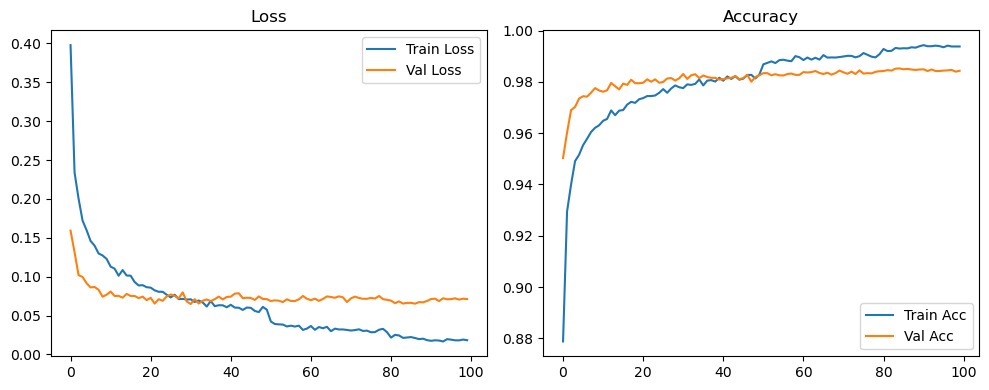

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2469, Acc: 0.9233 | Val Loss: 0.1486, Acc: 0.9557


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1176, Acc: 0.9643 | Val Loss: 0.1062, Acc: 0.9674


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0927, Acc: 0.9703 | Val Loss: 0.0827, Acc: 0.9758


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0701, Acc: 0.9781 | Val Loss: 0.0836, Acc: 0.9755


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9808 | Val Loss: 0.0942, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0495, Acc: 0.9844 | Val Loss: 0.0831, Acc: 0.9767


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9849 | Val Loss: 0.0828, Acc: 0.9757


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 0.0812, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0821, Acc: 0.9783


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.0994, Acc: 0.9749


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9896 | Val Loss: 0.0999, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.0867, Acc: 0.9797


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0799, Acc: 0.9817


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0933, Acc: 0.9773


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0891, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0992, Acc: 0.9788


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0896, Acc: 0.9804


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.0841, Acc: 0.9814


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0835, Acc: 0.9824


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0928, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0880, Acc: 0.9805


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0998, Acc: 0.9802


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0945, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0847, Acc: 0.9819


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0996, Acc: 0.9805


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0937, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0884, Acc: 0.9820


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0980, Acc: 0.9798


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0910, Acc: 0.9818


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0996, Acc: 0.9794


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0936, Acc: 0.9816


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9966 | Val Loss: 0.1031, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1033, Acc: 0.9820


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1138, Acc: 0.9785


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0983, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1054, Acc: 0.9811


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0999, Acc: 0.9822


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1001, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1026, Acc: 0.9811


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0990, Acc: 0.9814


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1122, Acc: 0.9809


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.0994, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0884, Acc: 0.9827


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1021, Acc: 0.9826


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1127, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1052, Acc: 0.9803


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1058, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0967, Acc: 0.9837


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0966, Acc: 0.9813


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0894, Acc: 0.9839


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0853, Acc: 0.9848


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0860, Acc: 0.9853


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0875, Acc: 0.9844


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0885, Acc: 0.9849


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0918, Acc: 0.9846


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0931, Acc: 0.9848


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0941, Acc: 0.9851


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0933, Acc: 0.9843


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0971, Acc: 0.9848


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0980, Acc: 0.9850


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1056, Acc: 0.9848


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9996 | Val Loss: 0.1052, Acc: 0.9848


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1034, Acc: 0.9852


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9997 | Val Loss: 0.1056, Acc: 0.9856


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1082, Acc: 0.9846


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1063, Acc: 0.9852


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1097, Acc: 0.9843


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1110, Acc: 0.9847


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1059, Acc: 0.9857


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1096, Acc: 0.9852


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1125, Acc: 0.9847


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1192, Acc: 0.9838


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1174, Acc: 0.9845


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1153, Acc: 0.9848


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1104, Acc: 0.9852


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1137, Acc: 0.9848


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1159, Acc: 0.9854


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1204, Acc: 0.9845


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1285, Acc: 0.9833


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1194, Acc: 0.9848


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1204, Acc: 0.9847


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1197, Acc: 0.9842


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1204, Acc: 0.9848


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1190, Acc: 0.9850


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1214, Acc: 0.9849


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1204, Acc: 0.9855


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1169, Acc: 0.9858


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1213, Acc: 0.9854


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1203, Acc: 0.9851


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1207, Acc: 0.9854


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1186, Acc: 0.9868


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1261, Acc: 0.9855


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1204, Acc: 0.9861


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1229, Acc: 0.9848


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1206, Acc: 0.9861


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1207, Acc: 0.9858


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1238, Acc: 0.9859


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1217, Acc: 0.9859


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1265, Acc: 0.9855


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1213, Acc: 0.9854


Final Test Loss: 0.1099 Accuracy: 0.9857


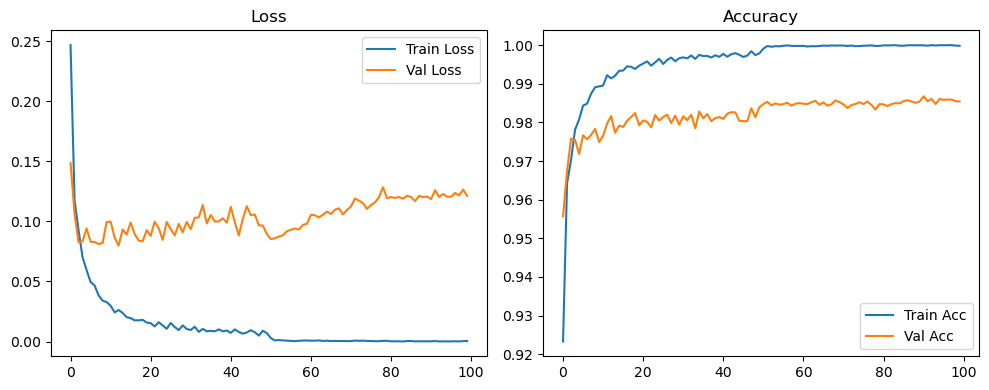

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2812, Acc: 0.9134 | Val Loss: 0.1451, Acc: 0.9567


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1477, Acc: 0.9547 | Val Loss: 0.1065, Acc: 0.9688


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1213, Acc: 0.9622 | Val Loss: 0.0974, Acc: 0.9705


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0992, Acc: 0.9689 | Val Loss: 0.0939, Acc: 0.9722


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0864, Acc: 0.9725 | Val Loss: 0.0992, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0784, Acc: 0.9754 | Val Loss: 0.0783, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0702, Acc: 0.9780 | Val Loss: 0.0847, Acc: 0.9763


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0653, Acc: 0.9792 | Val Loss: 0.0737, Acc: 0.9786


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9812 | Val Loss: 0.0776, Acc: 0.9782


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9822 | Val Loss: 0.0800, Acc: 0.9782


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0508, Acc: 0.9837 | Val Loss: 0.0818, Acc: 0.9768


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0704, Acc: 0.9811


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9848 | Val Loss: 0.0756, Acc: 0.9794


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.0882, Acc: 0.9768


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.0841, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9881 | Val Loss: 0.0792, Acc: 0.9802


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9878 | Val Loss: 0.0738, Acc: 0.9818


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.0779, Acc: 0.9808


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9889 | Val Loss: 0.0778, Acc: 0.9812


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0717, Acc: 0.9812


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0725, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.0805, Acc: 0.9815


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9912 | Val Loss: 0.0731, Acc: 0.9828


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0775, Acc: 0.9832


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9913 | Val Loss: 0.0781, Acc: 0.9821


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.0773, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9923 | Val Loss: 0.0769, Acc: 0.9822


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0821, Acc: 0.9808


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.0833, Acc: 0.9816


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0835, Acc: 0.9828


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9928 | Val Loss: 0.0760, Acc: 0.9829


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9917 | Val Loss: 0.0825, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9928 | Val Loss: 0.0773, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0817, Acc: 0.9837


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0879, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0836, Acc: 0.9822


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9937 | Val Loss: 0.0829, Acc: 0.9835


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0912, Acc: 0.9806


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0857, Acc: 0.9824


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0841, Acc: 0.9832


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0831, Acc: 0.9828


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0824, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9945 | Val Loss: 0.0837, Acc: 0.9825


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0776, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0954, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.0860, Acc: 0.9828


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0842, Acc: 0.9831


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0848, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0942, Acc: 0.9829


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.0917, Acc: 0.9815


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0850, Acc: 0.9834


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0817, Acc: 0.9848


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0794, Acc: 0.9847


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0827, Acc: 0.9842


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.0846, Acc: 0.9844


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0878, Acc: 0.9838


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0872, Acc: 0.9844


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0844, Acc: 0.9844


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0852, Acc: 0.9850


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0791, Acc: 0.9856


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0819, Acc: 0.9859


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0880, Acc: 0.9844


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0873, Acc: 0.9848


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0860, Acc: 0.9846


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0853, Acc: 0.9844


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0891, Acc: 0.9843


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0847, Acc: 0.9848


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0863, Acc: 0.9851


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0844, Acc: 0.9855


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0867, Acc: 0.9852


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0892, Acc: 0.9853


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0949, Acc: 0.9842


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0929, Acc: 0.9850


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0900, Acc: 0.9850


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0915, Acc: 0.9851


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0945, Acc: 0.9855


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.0956, Acc: 0.9848


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0952, Acc: 0.9850


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0961, Acc: 0.9846


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0957, Acc: 0.9839


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0908, Acc: 0.9851


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0898, Acc: 0.9848


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0936, Acc: 0.9848


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0900, Acc: 0.9849


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0897, Acc: 0.9852


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0920, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0874, Acc: 0.9859


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0901, Acc: 0.9851


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0921, Acc: 0.9858


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0908, Acc: 0.9850


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0926, Acc: 0.9854


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0930, Acc: 0.9847


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0907, Acc: 0.9857


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0936, Acc: 0.9855


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0919, Acc: 0.9859


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0917, Acc: 0.9850


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0927, Acc: 0.9849


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0945, Acc: 0.9855


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0950, Acc: 0.9853


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0928, Acc: 0.9855


Final Test Loss: 0.0957 Accuracy: 0.9861


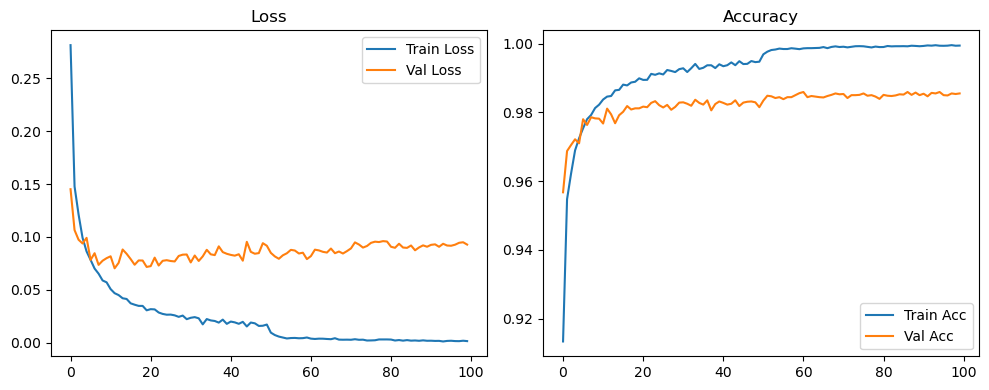

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3977, Acc: 0.8788 | Val Loss: 0.1592, Acc: 0.9503


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2340, Acc: 0.9294 | Val Loss: 0.1315, Acc: 0.9603


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2004, Acc: 0.9400 | Val Loss: 0.1020, Acc: 0.9690


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1721, Acc: 0.9491 | Val Loss: 0.0996, Acc: 0.9702


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1599, Acc: 0.9516 | Val Loss: 0.0917, Acc: 0.9735


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9553 | Val Loss: 0.0862, Acc: 0.9744


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1399, Acc: 0.9578 | Val Loss: 0.0868, Acc: 0.9742


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1298, Acc: 0.9605 | Val Loss: 0.0831, Acc: 0.9758


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1273, Acc: 0.9621 | Val Loss: 0.0742, Acc: 0.9776


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1229, Acc: 0.9631 | Val Loss: 0.0768, Acc: 0.9767


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1130, Acc: 0.9648 | Val Loss: 0.0809, Acc: 0.9762


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1103, Acc: 0.9656 | Val Loss: 0.0752, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1012, Acc: 0.9689 | Val Loss: 0.0754, Acc: 0.9796


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1085, Acc: 0.9670 | Val Loss: 0.0730, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9688 | Val Loss: 0.0779, Acc: 0.9771


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.1013, Acc: 0.9690 | Val Loss: 0.0752, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0932, Acc: 0.9711 | Val Loss: 0.0752, Acc: 0.9788


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9722 | Val Loss: 0.0725, Acc: 0.9808


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0891, Acc: 0.9718 | Val Loss: 0.0744, Acc: 0.9795


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9732 | Val Loss: 0.0699, Acc: 0.9795


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9737 | Val Loss: 0.0728, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0825, Acc: 0.9745 | Val Loss: 0.0654, Acc: 0.9810


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9745 | Val Loss: 0.0710, Acc: 0.9801


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9747 | Val Loss: 0.0690, Acc: 0.9810


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.0746, Acc: 0.9797


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9772 | Val Loss: 0.0771, Acc: 0.9800


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.0753, Acc: 0.9813


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0711, Acc: 0.9775 | Val Loss: 0.0721, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0714, Acc: 0.9786 | Val Loss: 0.0799, Acc: 0.9805


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0706, Acc: 0.9779 | Val Loss: 0.0682, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9776 | Val Loss: 0.0649, Acc: 0.9831


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0675, Acc: 0.9790 | Val Loss: 0.0711, Acc: 0.9812


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9788 | Val Loss: 0.0655, Acc: 0.9826


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9792 | Val Loss: 0.0691, Acc: 0.9830


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9810 | Val Loss: 0.0707, Acc: 0.9815


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0687, Acc: 0.9786 | Val Loss: 0.0687, Acc: 0.9825


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9805 | Val Loss: 0.0711, Acc: 0.9819


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0633, Acc: 0.9807 | Val Loss: 0.0744, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9801 | Val Loss: 0.0708, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9816 | Val Loss: 0.0739, Acc: 0.9809


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9805 | Val Loss: 0.0743, Acc: 0.9811


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9821 | Val Loss: 0.0782, Acc: 0.9814


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.0787, Acc: 0.9816


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0573, Acc: 0.9822 | Val Loss: 0.0723, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9809 | Val Loss: 0.0730, Acc: 0.9811


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0599, Acc: 0.9813 | Val Loss: 0.0727, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9827 | Val Loss: 0.0701, Acc: 0.9828


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0545, Acc: 0.9828 | Val Loss: 0.0746, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0612, Acc: 0.9814 | Val Loss: 0.0713, Acc: 0.9819


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9828 | Val Loss: 0.0711, Acc: 0.9826


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9869 | Val Loss: 0.0661, Acc: 0.9832


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9878 | Val Loss: 0.0676, Acc: 0.9839


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9894 | Val Loss: 0.0656, Acc: 0.9839


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0657, Acc: 0.9841


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.0678, Acc: 0.9833


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.0647, Acc: 0.9848


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.0663, Acc: 0.9842


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9912 | Val Loss: 0.0668, Acc: 0.9838


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9919 | Val Loss: 0.0699, Acc: 0.9831


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0690, Acc: 0.9838


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9909 | Val Loss: 0.0681, Acc: 0.9837


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0698, Acc: 0.9838


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.0682, Acc: 0.9842


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9916 | Val Loss: 0.0702, Acc: 0.9845


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0708, Acc: 0.9837


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.0694, Acc: 0.9832


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9917 | Val Loss: 0.0685, Acc: 0.9837


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.0708, Acc: 0.9845


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.0690, Acc: 0.9847


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0676, Acc: 0.9852


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0700, Acc: 0.9844


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0694, Acc: 0.9848


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.0685, Acc: 0.9847


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0679, Acc: 0.9841


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9931 | Val Loss: 0.0690, Acc: 0.9848


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.0698, Acc: 0.9840


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 0.0696, Acc: 0.9842


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9927 | Val Loss: 0.0734, Acc: 0.9843


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0235, Acc: 0.9924 | Val Loss: 0.0694, Acc: 0.9848


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9930 | Val Loss: 0.0678, Acc: 0.9842


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.0697, Acc: 0.9841


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.0668, Acc: 0.9848


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9934 | Val Loss: 0.0687, Acc: 0.9848


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.0665, Acc: 0.9847


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0673, Acc: 0.9852


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0678, Acc: 0.9846


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0667, Acc: 0.9848


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0682, Acc: 0.9843


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0669, Acc: 0.9848


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0684, Acc: 0.9850


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0706, Acc: 0.9847


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0717, Acc: 0.9838


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.0675, Acc: 0.9849


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0714, Acc: 0.9847


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9939 | Val Loss: 0.0704, Acc: 0.9847


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0708, Acc: 0.9847


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9940 | Val Loss: 0.0705, Acc: 0.9847


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0693, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0700, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.0700, Acc: 0.9845


Final Test Loss: 0.0603 Accuracy: 0.9861


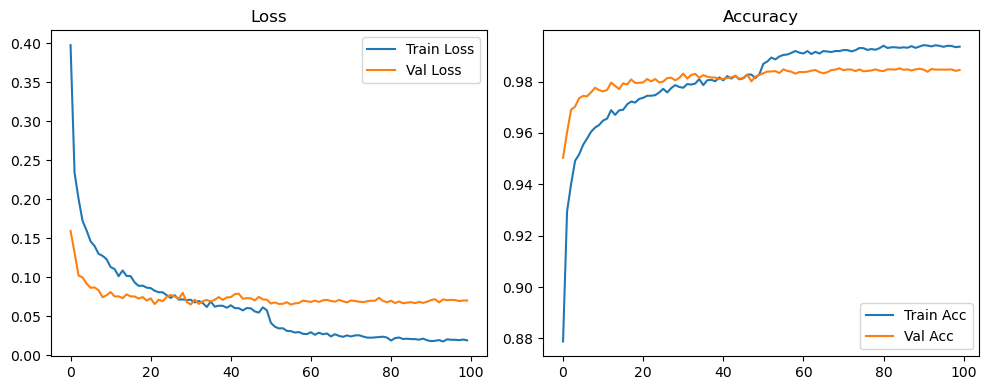

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2372, Acc: 0.9262 | Val Loss: 0.1325, Acc: 0.9595


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1144, Acc: 0.9646 | Val Loss: 0.0974, Acc: 0.9699


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0883, Acc: 0.9722 | Val Loss: 0.0823, Acc: 0.9750


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9776 | Val Loss: 0.0830, Acc: 0.9740


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9812 | Val Loss: 0.0924, Acc: 0.9727


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9844 | Val Loss: 0.0770, Acc: 0.9782


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9863 | Val Loss: 0.0797, Acc: 0.9779


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.0767, Acc: 0.9779


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.0831, Acc: 0.9782


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0711, Acc: 0.9817


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.0990, Acc: 0.9751


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.0763, Acc: 0.9802


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9927 | Val Loss: 0.0743, Acc: 0.9805


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0853, Acc: 0.9782


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0842, Acc: 0.9785


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0903, Acc: 0.9792


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0751, Acc: 0.9830


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0936, Acc: 0.9778


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.0838, Acc: 0.9812


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0869, Acc: 0.9798


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0725, Acc: 0.9818


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9956 | Val Loss: 0.0883, Acc: 0.9812


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0790, Acc: 0.9813


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0809, Acc: 0.9817


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0873, Acc: 0.9817


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0790, Acc: 0.9804


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0790, Acc: 0.9819


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0909, Acc: 0.9818


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0855, Acc: 0.9812


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0842, Acc: 0.9833


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0759, Acc: 0.9826


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0802, Acc: 0.9831


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0985, Acc: 0.9807


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0874, Acc: 0.9831


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1027, Acc: 0.9786


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0778, Acc: 0.9842


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0789, Acc: 0.9845


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0846, Acc: 0.9825


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0875, Acc: 0.9838


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0872, Acc: 0.9816


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0985, Acc: 0.9812


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1021, Acc: 0.9819


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0801, Acc: 0.9835


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0924, Acc: 0.9829


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0971, Acc: 0.9811


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0898, Acc: 0.9833


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0977, Acc: 0.9824


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0874, Acc: 0.9847


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1047, Acc: 0.9819


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.0836, Acc: 0.9837


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.0843, Acc: 0.9842


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0931, Acc: 0.9829


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0965, Acc: 0.9828


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0925, Acc: 0.9822


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0958, Acc: 0.9829


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0800, Acc: 0.9843


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0882, Acc: 0.9830


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0875, Acc: 0.9828


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0979, Acc: 0.9818


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0828, Acc: 0.9846


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0878, Acc: 0.9845


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1004, Acc: 0.9838


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1026, Acc: 0.9836


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1016, Acc: 0.9833


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0900, Acc: 0.9842


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0929, Acc: 0.9832


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0892, Acc: 0.9837


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1026, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1037, Acc: 0.9818


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0993, Acc: 0.9816


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1061, Acc: 0.9826


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1019, Acc: 0.9828


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1030, Acc: 0.9824


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0959, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1061, Acc: 0.9843


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1045, Acc: 0.9845


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1018, Acc: 0.9849


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1101, Acc: 0.9826


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1122, Acc: 0.9822


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1014, Acc: 0.9838


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1009, Acc: 0.9839


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1086, Acc: 0.9837


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1007, Acc: 0.9830


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1018, Acc: 0.9842


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1029, Acc: 0.9844


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1081, Acc: 0.9838


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1096, Acc: 0.9834


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1030, Acc: 0.9832


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1070, Acc: 0.9828


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1041, Acc: 0.9839


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1079, Acc: 0.9851


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1104, Acc: 0.9834


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1070, Acc: 0.9832


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1099, Acc: 0.9828


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1020, Acc: 0.9827


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1089, Acc: 0.9826


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1031, Acc: 0.9841


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0939, Acc: 0.9840


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0949, Acc: 0.9836


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0993, Acc: 0.9829


Final Test Loss: 0.1053 Accuracy: 0.9830


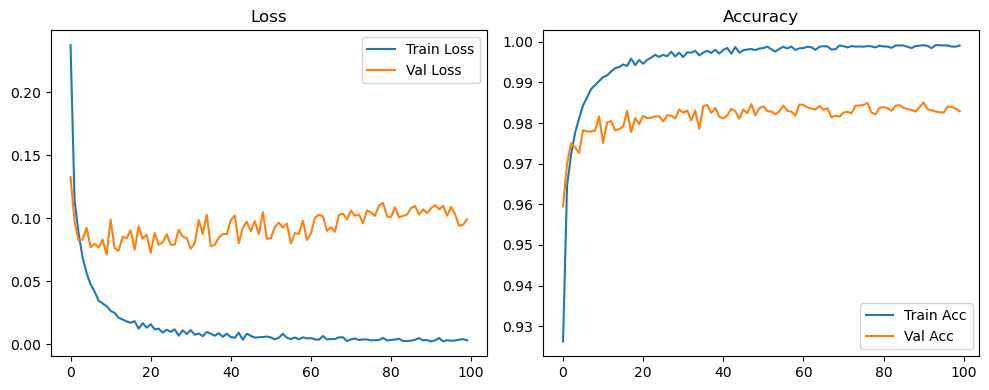

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2727, Acc: 0.9153 | Val Loss: 0.1527, Acc: 0.9550


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1468, Acc: 0.9550 | Val Loss: 0.1064, Acc: 0.9677


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1173, Acc: 0.9630 | Val Loss: 0.0944, Acc: 0.9702


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0953, Acc: 0.9702 | Val Loss: 0.0845, Acc: 0.9733


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0788, Acc: 0.9747 | Val Loss: 0.0887, Acc: 0.9732


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0746, Acc: 0.9761 | Val Loss: 0.0749, Acc: 0.9764


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0639, Acc: 0.9790 | Val Loss: 0.0807, Acc: 0.9777


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9802 | Val Loss: 0.0739, Acc: 0.9778


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9820 | Val Loss: 0.0746, Acc: 0.9778


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9837 | Val Loss: 0.0722, Acc: 0.9792


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9848 | Val Loss: 0.0728, Acc: 0.9788


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9862 | Val Loss: 0.0699, Acc: 0.9799


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9866 | Val Loss: 0.0712, Acc: 0.9812


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9867 | Val Loss: 0.0723, Acc: 0.9782


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9877 | Val Loss: 0.0748, Acc: 0.9812


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9891 | Val Loss: 0.0792, Acc: 0.9807


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.0776, Acc: 0.9790


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.0692, Acc: 0.9814


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9904 | Val Loss: 0.0805, Acc: 0.9797


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.0676, Acc: 0.9819


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.0698, Acc: 0.9820


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.0795, Acc: 0.9798


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0791, Acc: 0.9810


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0691, Acc: 0.9821


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.0780, Acc: 0.9818


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0834, Acc: 0.9808


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0727, Acc: 0.9828


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0796, Acc: 0.9814


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.0772, Acc: 0.9827


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0775, Acc: 0.9826


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9928 | Val Loss: 0.0826, Acc: 0.9818


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0826, Acc: 0.9831


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.0744, Acc: 0.9837


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.0714, Acc: 0.9839


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0781, Acc: 0.9825


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0722, Acc: 0.9824


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0780, Acc: 0.9825


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9943 | Val Loss: 0.0812, Acc: 0.9809


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9942 | Val Loss: 0.0758, Acc: 0.9829


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0880, Acc: 0.9812


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0810, Acc: 0.9833


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0858, Acc: 0.9818


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0762, Acc: 0.9831


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0812, Acc: 0.9833


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0792, Acc: 0.9836


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0796, Acc: 0.9823


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0821, Acc: 0.9832


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0799, Acc: 0.9835


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.0777, Acc: 0.9835


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0795, Acc: 0.9841


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0834, Acc: 0.9828


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0740, Acc: 0.9842


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0817, Acc: 0.9812


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0731, Acc: 0.9839


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0788, Acc: 0.9832


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0897, Acc: 0.9818


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0847, Acc: 0.9834


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0840, Acc: 0.9832


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0832, Acc: 0.9827


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0880, Acc: 0.9827


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0929, Acc: 0.9820


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0837, Acc: 0.9842


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0863, Acc: 0.9824


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0952, Acc: 0.9834


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0842, Acc: 0.9831


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0833, Acc: 0.9845


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.0909, Acc: 0.9817


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0849, Acc: 0.9834


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0847, Acc: 0.9845


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.0847, Acc: 0.9832


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0867, Acc: 0.9836


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0860, Acc: 0.9830


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0882, Acc: 0.9828


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0888, Acc: 0.9841


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0995, Acc: 0.9832


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0871, Acc: 0.9837


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.0893, Acc: 0.9841


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0867, Acc: 0.9849


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0830, Acc: 0.9842


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0829, Acc: 0.9852


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0899, Acc: 0.9830


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0879, Acc: 0.9838


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0926, Acc: 0.9835


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0884, Acc: 0.9833


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0923, Acc: 0.9832


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0926, Acc: 0.9834


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0964, Acc: 0.9833


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.0944, Acc: 0.9826


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0873, Acc: 0.9838


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0918, Acc: 0.9834


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0910, Acc: 0.9833


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0883, Acc: 0.9833


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0906, Acc: 0.9839


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0905, Acc: 0.9849


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0953, Acc: 0.9820


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0938, Acc: 0.9836


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0946, Acc: 0.9843


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0901, Acc: 0.9846


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0973, Acc: 0.9832


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0899, Acc: 0.9841


Final Test Loss: 0.0878 Accuracy: 0.9851


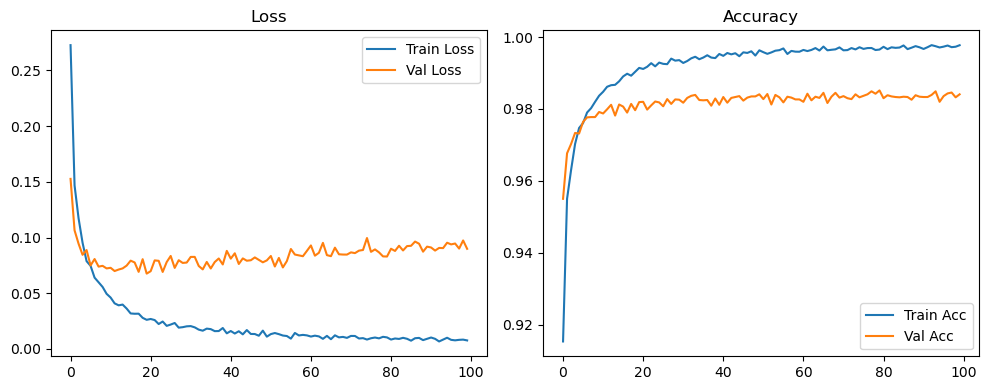

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3887, Acc: 0.8793 | Val Loss: 0.1641, Acc: 0.9502


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2308, Acc: 0.9299 | Val Loss: 0.1298, Acc: 0.9613


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1972, Acc: 0.9397 | Val Loss: 0.1103, Acc: 0.9683


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1666, Acc: 0.9493 | Val Loss: 0.1010, Acc: 0.9691


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1543, Acc: 0.9528 | Val Loss: 0.0904, Acc: 0.9732


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1399, Acc: 0.9569 | Val Loss: 0.0814, Acc: 0.9742


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1321, Acc: 0.9584 | Val Loss: 0.0813, Acc: 0.9742


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1229, Acc: 0.9619 | Val Loss: 0.0794, Acc: 0.9764


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1149, Acc: 0.9642 | Val Loss: 0.0780, Acc: 0.9775


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1136, Acc: 0.9648 | Val Loss: 0.0762, Acc: 0.9778


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1085, Acc: 0.9654 | Val Loss: 0.0763, Acc: 0.9786


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0990, Acc: 0.9698 | Val Loss: 0.0695, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0943, Acc: 0.9699 | Val Loss: 0.0721, Acc: 0.9789


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0943, Acc: 0.9708 | Val Loss: 0.0693, Acc: 0.9792


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0907, Acc: 0.9713 | Val Loss: 0.0700, Acc: 0.9788


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0858, Acc: 0.9728 | Val Loss: 0.0683, Acc: 0.9807


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0877, Acc: 0.9728 | Val Loss: 0.0681, Acc: 0.9799


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0819, Acc: 0.9731 | Val Loss: 0.0680, Acc: 0.9808


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0822, Acc: 0.9740 | Val Loss: 0.0690, Acc: 0.9802


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9755 | Val Loss: 0.0669, Acc: 0.9798


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9765 | Val Loss: 0.0668, Acc: 0.9819


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0742, Acc: 0.9759 | Val Loss: 0.0644, Acc: 0.9811


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9774 | Val Loss: 0.0678, Acc: 0.9812


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9779 | Val Loss: 0.0688, Acc: 0.9808


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9776 | Val Loss: 0.0701, Acc: 0.9817


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9786 | Val Loss: 0.0671, Acc: 0.9823


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9807 | Val Loss: 0.0648, Acc: 0.9822


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9804 | Val Loss: 0.0674, Acc: 0.9806


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9802 | Val Loss: 0.0667, Acc: 0.9813


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9808 | Val Loss: 0.0668, Acc: 0.9812


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9803 | Val Loss: 0.0629, Acc: 0.9828


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9821 | Val Loss: 0.0676, Acc: 0.9832


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9814 | Val Loss: 0.0614, Acc: 0.9824


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9812 | Val Loss: 0.0671, Acc: 0.9814


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9818 | Val Loss: 0.0627, Acc: 0.9827


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9816 | Val Loss: 0.0659, Acc: 0.9832


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9820 | Val Loss: 0.0682, Acc: 0.9822


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9819 | Val Loss: 0.0652, Acc: 0.9826


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9830 | Val Loss: 0.0653, Acc: 0.9821


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9830 | Val Loss: 0.0631, Acc: 0.9817


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9830 | Val Loss: 0.0657, Acc: 0.9824


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9845 | Val Loss: 0.0666, Acc: 0.9828


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9836 | Val Loss: 0.0686, Acc: 0.9822


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9837 | Val Loss: 0.0653, Acc: 0.9824


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9831 | Val Loss: 0.0690, Acc: 0.9828


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9845 | Val Loss: 0.0655, Acc: 0.9831


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9850 | Val Loss: 0.0664, Acc: 0.9828


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9838 | Val Loss: 0.0649, Acc: 0.9828


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9847 | Val Loss: 0.0660, Acc: 0.9839


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9858 | Val Loss: 0.0658, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0451, Acc: 0.9860 | Val Loss: 0.0669, Acc: 0.9823


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9851 | Val Loss: 0.0687, Acc: 0.9832


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0486, Acc: 0.9848 | Val Loss: 0.0652, Acc: 0.9833


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9854 | Val Loss: 0.0696, Acc: 0.9828


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9862 | Val Loss: 0.0662, Acc: 0.9834


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9861 | Val Loss: 0.0694, Acc: 0.9830


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0449, Acc: 0.9858 | Val Loss: 0.0678, Acc: 0.9831


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9864 | Val Loss: 0.0708, Acc: 0.9823


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9865 | Val Loss: 0.0691, Acc: 0.9821


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 0.0666, Acc: 0.9835


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9873 | Val Loss: 0.0697, Acc: 0.9825


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9863 | Val Loss: 0.0733, Acc: 0.9832


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.0711, Acc: 0.9834


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9873 | Val Loss: 0.0675, Acc: 0.9834


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9870 | Val Loss: 0.0721, Acc: 0.9826


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9877 | Val Loss: 0.0708, Acc: 0.9838


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9870 | Val Loss: 0.0672, Acc: 0.9838


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9870 | Val Loss: 0.0695, Acc: 0.9840


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0704, Acc: 0.9826


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9869 | Val Loss: 0.0685, Acc: 0.9842


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9874 | Val Loss: 0.0689, Acc: 0.9838


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9872 | Val Loss: 0.0724, Acc: 0.9829


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9882 | Val Loss: 0.0728, Acc: 0.9838


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9874 | Val Loss: 0.0737, Acc: 0.9835


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9884 | Val Loss: 0.0736, Acc: 0.9828


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0370, Acc: 0.9877 | Val Loss: 0.0739, Acc: 0.9835


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.0726, Acc: 0.9838


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9878 | Val Loss: 0.0710, Acc: 0.9835


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0404, Acc: 0.9871 | Val Loss: 0.0680, Acc: 0.9832


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.0749, Acc: 0.9828


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9893 | Val Loss: 0.0744, Acc: 0.9832


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9879 | Val Loss: 0.0710, Acc: 0.9828


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.0699, Acc: 0.9846


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9889 | Val Loss: 0.0708, Acc: 0.9833


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9887 | Val Loss: 0.0700, Acc: 0.9828


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9884 | Val Loss: 0.0712, Acc: 0.9824


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.0753, Acc: 0.9838


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9882 | Val Loss: 0.0677, Acc: 0.9842


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9887 | Val Loss: 0.0691, Acc: 0.9832


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9892 | Val Loss: 0.0731, Acc: 0.9845


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9892 | Val Loss: 0.0772, Acc: 0.9821


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9889 | Val Loss: 0.0726, Acc: 0.9828


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9882 | Val Loss: 0.0739, Acc: 0.9828


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9905 | Val Loss: 0.0741, Acc: 0.9838


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9902 | Val Loss: 0.0718, Acc: 0.9829


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9892 | Val Loss: 0.0717, Acc: 0.9828


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0768, Acc: 0.9825


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.0736, Acc: 0.9832


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9894 | Val Loss: 0.0756, Acc: 0.9833


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0777, Acc: 0.9840


Final Test Loss: 0.0757 Accuracy: 0.9847


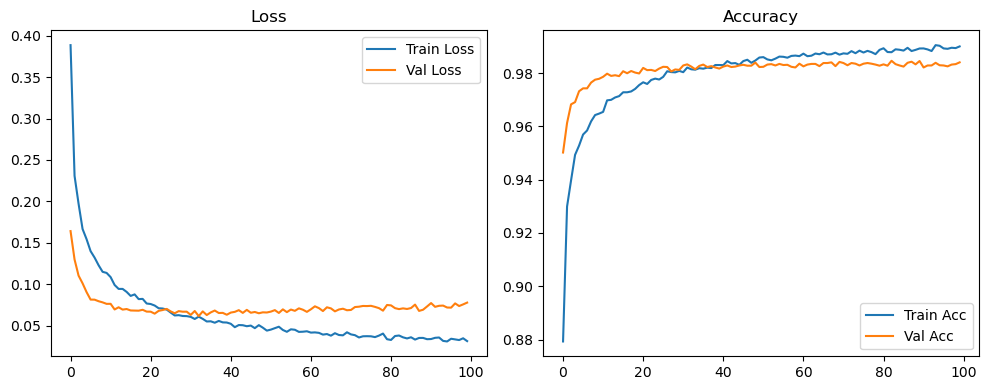

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2372, Acc: 0.9262 | Val Loss: 0.1325, Acc: 0.9595


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1144, Acc: 0.9646 | Val Loss: 0.0974, Acc: 0.9699


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0883, Acc: 0.9722 | Val Loss: 0.0823, Acc: 0.9750


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9776 | Val Loss: 0.0830, Acc: 0.9740


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0566, Acc: 0.9812 | Val Loss: 0.0924, Acc: 0.9727


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9844 | Val Loss: 0.0770, Acc: 0.9782


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9863 | Val Loss: 0.0797, Acc: 0.9779


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.0767, Acc: 0.9779


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.0831, Acc: 0.9782


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0711, Acc: 0.9817


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.0990, Acc: 0.9751


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.0763, Acc: 0.9802


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9927 | Val Loss: 0.0743, Acc: 0.9805


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0853, Acc: 0.9782


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0842, Acc: 0.9785


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0903, Acc: 0.9792


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0751, Acc: 0.9830


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0936, Acc: 0.9778


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.0838, Acc: 0.9812


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0869, Acc: 0.9798


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0725, Acc: 0.9818


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9956 | Val Loss: 0.0883, Acc: 0.9812


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0790, Acc: 0.9813


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0809, Acc: 0.9817


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0873, Acc: 0.9817


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0790, Acc: 0.9804


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0790, Acc: 0.9819


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0909, Acc: 0.9818


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0855, Acc: 0.9812


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0842, Acc: 0.9833


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0759, Acc: 0.9826


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0802, Acc: 0.9831


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0985, Acc: 0.9807


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0874, Acc: 0.9831


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1027, Acc: 0.9786


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0778, Acc: 0.9842


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0789, Acc: 0.9845


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0846, Acc: 0.9825


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0875, Acc: 0.9838


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0872, Acc: 0.9816


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0985, Acc: 0.9812


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1021, Acc: 0.9819


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0801, Acc: 0.9835


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0924, Acc: 0.9829


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0971, Acc: 0.9811


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0898, Acc: 0.9833


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0977, Acc: 0.9824


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0874, Acc: 0.9847


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1047, Acc: 0.9819


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.0836, Acc: 0.9837


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0845, Acc: 0.9848


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0846, Acc: 0.9854


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0826, Acc: 0.9848


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0819, Acc: 0.9857


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0884, Acc: 0.9848


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0915, Acc: 0.9838


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0897, Acc: 0.9848


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0877, Acc: 0.9848


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0967, Acc: 0.9848


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0942, Acc: 0.9849


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1007, Acc: 0.9846


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0952, Acc: 0.9858


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0988, Acc: 0.9852


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1005, Acc: 0.9856


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1089, Acc: 0.9847


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0974, Acc: 0.9843


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0971, Acc: 0.9852


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1041, Acc: 0.9848


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1089, Acc: 0.9837


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1058, Acc: 0.9842


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1090, Acc: 0.9842


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1241, Acc: 0.9835


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1064, Acc: 0.9849


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1094, Acc: 0.9845


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1114, Acc: 0.9842


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1127, Acc: 0.9838


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1073, Acc: 0.9850


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1098, Acc: 0.9838


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1087, Acc: 0.9847


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1091, Acc: 0.9834


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1084, Acc: 0.9847


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1097, Acc: 0.9846


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1181, Acc: 0.9835


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0997, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1017, Acc: 0.9852


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1023, Acc: 0.9857


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1016, Acc: 0.9861


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1117, Acc: 0.9838


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1076, Acc: 0.9848


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1029, Acc: 0.9854


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1051, Acc: 0.9858


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1060, Acc: 0.9847


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1038, Acc: 0.9858


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1086, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1098, Acc: 0.9849


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1088, Acc: 0.9852


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1074, Acc: 0.9849


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1130, Acc: 0.9845


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1084, Acc: 0.9853


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1061, Acc: 0.9853


Final Test Loss: 0.1219 Accuracy: 0.9846


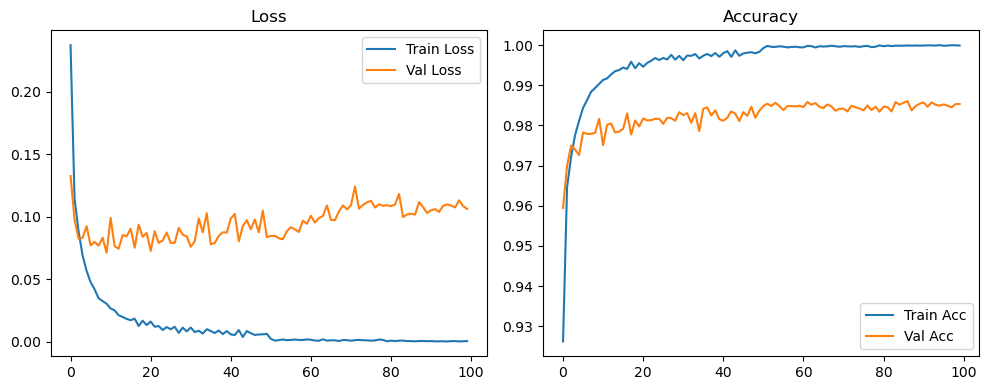

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2727, Acc: 0.9153 | Val Loss: 0.1527, Acc: 0.9550


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1468, Acc: 0.9550 | Val Loss: 0.1064, Acc: 0.9677


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1173, Acc: 0.9630 | Val Loss: 0.0944, Acc: 0.9702


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0953, Acc: 0.9702 | Val Loss: 0.0845, Acc: 0.9733


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0788, Acc: 0.9747 | Val Loss: 0.0887, Acc: 0.9732


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0746, Acc: 0.9761 | Val Loss: 0.0749, Acc: 0.9764


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0639, Acc: 0.9790 | Val Loss: 0.0807, Acc: 0.9777


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0598, Acc: 0.9802 | Val Loss: 0.0739, Acc: 0.9778


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9820 | Val Loss: 0.0746, Acc: 0.9778


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9837 | Val Loss: 0.0722, Acc: 0.9792


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9848 | Val Loss: 0.0728, Acc: 0.9788


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9862 | Val Loss: 0.0699, Acc: 0.9799


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9866 | Val Loss: 0.0712, Acc: 0.9812


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9867 | Val Loss: 0.0723, Acc: 0.9782


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0362, Acc: 0.9877 | Val Loss: 0.0748, Acc: 0.9812


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9891 | Val Loss: 0.0792, Acc: 0.9807


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.0776, Acc: 0.9790


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.0692, Acc: 0.9814


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9904 | Val Loss: 0.0805, Acc: 0.9797


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.0676, Acc: 0.9819


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9911 | Val Loss: 0.0698, Acc: 0.9820


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.0795, Acc: 0.9798


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0791, Acc: 0.9810


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0691, Acc: 0.9821


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.0780, Acc: 0.9818


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9926 | Val Loss: 0.0834, Acc: 0.9808


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0727, Acc: 0.9828


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0796, Acc: 0.9814


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.0772, Acc: 0.9827


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0775, Acc: 0.9826


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9928 | Val Loss: 0.0826, Acc: 0.9818


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0826, Acc: 0.9831


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.0744, Acc: 0.9837


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.0714, Acc: 0.9839


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0781, Acc: 0.9825


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0722, Acc: 0.9824


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0780, Acc: 0.9825


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9943 | Val Loss: 0.0812, Acc: 0.9809


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9942 | Val Loss: 0.0758, Acc: 0.9829


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0880, Acc: 0.9812


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0810, Acc: 0.9833


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0858, Acc: 0.9818


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0762, Acc: 0.9831


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0812, Acc: 0.9833


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0792, Acc: 0.9836


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0796, Acc: 0.9823


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0821, Acc: 0.9832


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0799, Acc: 0.9835


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9949 | Val Loss: 0.0777, Acc: 0.9835


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0795, Acc: 0.9841


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0722, Acc: 0.9858


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0729, Acc: 0.9854


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0739, Acc: 0.9852


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0746, Acc: 0.9857


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0803, Acc: 0.9842


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0801, Acc: 0.9851


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0762, Acc: 0.9856


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0774, Acc: 0.9856


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0735, Acc: 0.9863


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0764, Acc: 0.9858


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0801, Acc: 0.9849


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0787, Acc: 0.9854


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0815, Acc: 0.9858


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0857, Acc: 0.9851


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0864, Acc: 0.9852


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0864, Acc: 0.9859


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0835, Acc: 0.9852


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0833, Acc: 0.9858


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0876, Acc: 0.9863


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0848, Acc: 0.9862


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0899, Acc: 0.9852


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0887, Acc: 0.9858


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0908, Acc: 0.9853


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0895, Acc: 0.9851


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0890, Acc: 0.9856


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0861, Acc: 0.9856


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0894, Acc: 0.9860


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0962, Acc: 0.9847


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0921, Acc: 0.9850


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0872, Acc: 0.9852


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0854, Acc: 0.9863


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0896, Acc: 0.9845


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0901, Acc: 0.9854


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0888, Acc: 0.9847


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0861, Acc: 0.9855


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0905, Acc: 0.9855


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0921, Acc: 0.9860


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0944, Acc: 0.9858


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0979, Acc: 0.9850


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0949, Acc: 0.9854


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0957, Acc: 0.9848


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0966, Acc: 0.9845


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0948, Acc: 0.9845


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0995, Acc: 0.9848


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0972, Acc: 0.9853


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0937, Acc: 0.9852


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0960, Acc: 0.9851


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0925, Acc: 0.9859


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0978, Acc: 0.9853


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0951, Acc: 0.9853


Final Test Loss: 0.0891 Accuracy: 0.9864


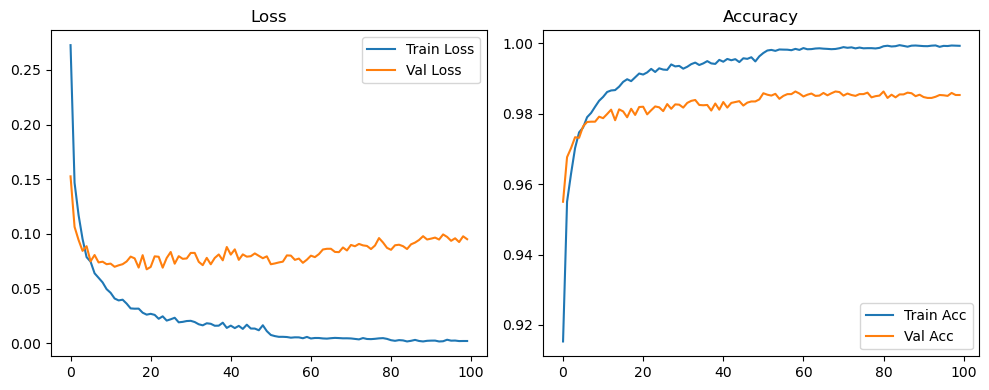

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3887, Acc: 0.8793 | Val Loss: 0.1641, Acc: 0.9502


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2308, Acc: 0.9299 | Val Loss: 0.1298, Acc: 0.9613


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1972, Acc: 0.9397 | Val Loss: 0.1103, Acc: 0.9683


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1666, Acc: 0.9493 | Val Loss: 0.1010, Acc: 0.9691


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1543, Acc: 0.9528 | Val Loss: 0.0904, Acc: 0.9732


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1399, Acc: 0.9569 | Val Loss: 0.0814, Acc: 0.9742


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1321, Acc: 0.9584 | Val Loss: 0.0813, Acc: 0.9742


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1229, Acc: 0.9619 | Val Loss: 0.0794, Acc: 0.9764


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1149, Acc: 0.9642 | Val Loss: 0.0780, Acc: 0.9775


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1136, Acc: 0.9648 | Val Loss: 0.0762, Acc: 0.9778


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1085, Acc: 0.9654 | Val Loss: 0.0763, Acc: 0.9786


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0990, Acc: 0.9698 | Val Loss: 0.0695, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0943, Acc: 0.9699 | Val Loss: 0.0721, Acc: 0.9789


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0943, Acc: 0.9708 | Val Loss: 0.0693, Acc: 0.9792


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0907, Acc: 0.9713 | Val Loss: 0.0700, Acc: 0.9788


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0858, Acc: 0.9728 | Val Loss: 0.0683, Acc: 0.9807


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0877, Acc: 0.9728 | Val Loss: 0.0681, Acc: 0.9799


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0819, Acc: 0.9731 | Val Loss: 0.0680, Acc: 0.9808


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0822, Acc: 0.9740 | Val Loss: 0.0690, Acc: 0.9802


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0767, Acc: 0.9755 | Val Loss: 0.0669, Acc: 0.9798


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0760, Acc: 0.9765 | Val Loss: 0.0668, Acc: 0.9819


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0742, Acc: 0.9759 | Val Loss: 0.0644, Acc: 0.9811


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0709, Acc: 0.9774 | Val Loss: 0.0678, Acc: 0.9812


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9779 | Val Loss: 0.0688, Acc: 0.9808


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0693, Acc: 0.9776 | Val Loss: 0.0701, Acc: 0.9817


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0657, Acc: 0.9786 | Val Loss: 0.0671, Acc: 0.9823


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0622, Acc: 0.9807 | Val Loss: 0.0648, Acc: 0.9822


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9804 | Val Loss: 0.0674, Acc: 0.9806


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0616, Acc: 0.9802 | Val Loss: 0.0667, Acc: 0.9813


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9808 | Val Loss: 0.0668, Acc: 0.9812


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9803 | Val Loss: 0.0629, Acc: 0.9828


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9821 | Val Loss: 0.0676, Acc: 0.9832


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9814 | Val Loss: 0.0614, Acc: 0.9824


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9812 | Val Loss: 0.0671, Acc: 0.9814


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0549, Acc: 0.9818 | Val Loss: 0.0627, Acc: 0.9827


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0552, Acc: 0.9816 | Val Loss: 0.0659, Acc: 0.9832


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9820 | Val Loss: 0.0682, Acc: 0.9822


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0556, Acc: 0.9819 | Val Loss: 0.0652, Acc: 0.9826


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0539, Acc: 0.9830 | Val Loss: 0.0653, Acc: 0.9821


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0537, Acc: 0.9830 | Val Loss: 0.0631, Acc: 0.9817


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9830 | Val Loss: 0.0657, Acc: 0.9824


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9845 | Val Loss: 0.0666, Acc: 0.9828


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9836 | Val Loss: 0.0686, Acc: 0.9822


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9837 | Val Loss: 0.0653, Acc: 0.9824


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0492, Acc: 0.9831 | Val Loss: 0.0690, Acc: 0.9828


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0500, Acc: 0.9845 | Val Loss: 0.0655, Acc: 0.9831


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9850 | Val Loss: 0.0664, Acc: 0.9828


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9838 | Val Loss: 0.0649, Acc: 0.9828


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0475, Acc: 0.9847 | Val Loss: 0.0660, Acc: 0.9839


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0439, Acc: 0.9858 | Val Loss: 0.0658, Acc: 0.9822


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9880 | Val Loss: 0.0629, Acc: 0.9838


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.0647, Acc: 0.9846


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.0606, Acc: 0.9843


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.0630, Acc: 0.9837


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0635, Acc: 0.9838


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9896 | Val Loss: 0.0627, Acc: 0.9838


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0628, Acc: 0.9833


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9913 | Val Loss: 0.0654, Acc: 0.9832


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 0.0639, Acc: 0.9840


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9911 | Val Loss: 0.0639, Acc: 0.9842


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9910 | Val Loss: 0.0660, Acc: 0.9843


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9906 | Val Loss: 0.0704, Acc: 0.9845


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9905 | Val Loss: 0.0687, Acc: 0.9843


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.0665, Acc: 0.9853


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9915 | Val Loss: 0.0692, Acc: 0.9843


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9916 | Val Loss: 0.0690, Acc: 0.9841


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9915 | Val Loss: 0.0656, Acc: 0.9844


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0692, Acc: 0.9842


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9916 | Val Loss: 0.0677, Acc: 0.9851


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0689, Acc: 0.9852


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.0694, Acc: 0.9844


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0699, Acc: 0.9843


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.0701, Acc: 0.9839


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0706, Acc: 0.9838


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9925 | Val Loss: 0.0675, Acc: 0.9848


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0690, Acc: 0.9842


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9927 | Val Loss: 0.0694, Acc: 0.9852


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.0699, Acc: 0.9842


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0674, Acc: 0.9846


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9922 | Val Loss: 0.0701, Acc: 0.9842


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.0693, Acc: 0.9842


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0678, Acc: 0.9846


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0678, Acc: 0.9852


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.0689, Acc: 0.9847


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0667, Acc: 0.9851


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0675, Acc: 0.9851


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0675, Acc: 0.9840


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.0684, Acc: 0.9847


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9937 | Val Loss: 0.0691, Acc: 0.9844


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0693, Acc: 0.9847


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9943 | Val Loss: 0.0705, Acc: 0.9844


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.0705, Acc: 0.9840


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0685, Acc: 0.9845


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0713, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0708, Acc: 0.9855


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0724, Acc: 0.9844


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.0714, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0690, Acc: 0.9846


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0713, Acc: 0.9844


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0706, Acc: 0.9851


Final Test Loss: 0.0711 Accuracy: 0.9853


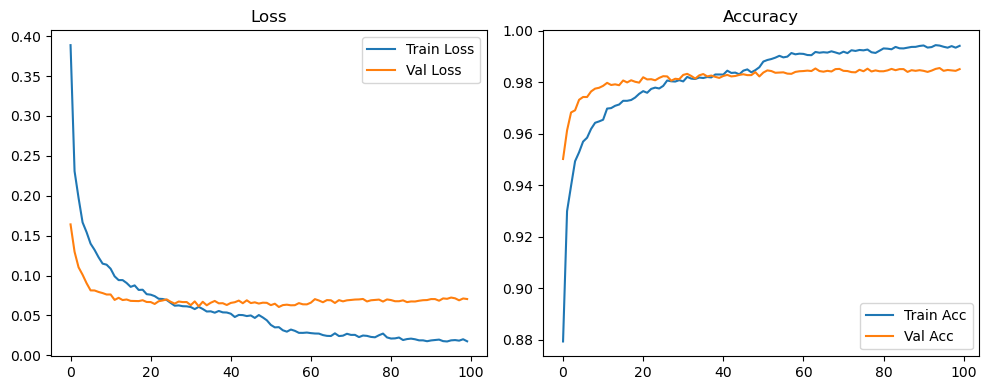

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2229, Acc: 0.9306 | Val Loss: 0.1329, Acc: 0.9581


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1082, Acc: 0.9660 | Val Loss: 0.0970, Acc: 0.9705


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0836, Acc: 0.9740 | Val Loss: 0.0868, Acc: 0.9725


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0644, Acc: 0.9791 | Val Loss: 0.0888, Acc: 0.9744


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9826 | Val Loss: 0.0799, Acc: 0.9736


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0444, Acc: 0.9851 | Val Loss: 0.0736, Acc: 0.9796


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9870 | Val Loss: 0.0785, Acc: 0.9763


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9889 | Val Loss: 0.0725, Acc: 0.9792


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.0831, Acc: 0.9780


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.0790, Acc: 0.9796


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0846, Acc: 0.9787


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9930 | Val Loss: 0.0840, Acc: 0.9785


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.0741, Acc: 0.9798


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.0763, Acc: 0.9814


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0862, Acc: 0.9791


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0782, Acc: 0.9802


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0763, Acc: 0.9824


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0778, Acc: 0.9815


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0935, Acc: 0.9782


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0751, Acc: 0.9822


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0884, Acc: 0.9808


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.0835, Acc: 0.9808


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0775, Acc: 0.9819


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0845, Acc: 0.9822


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0836, Acc: 0.9826


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0800, Acc: 0.9822


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0786, Acc: 0.9844


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0878, Acc: 0.9814


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0837, Acc: 0.9817


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0771, Acc: 0.9838


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1068, Acc: 0.9794


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0883, Acc: 0.9817


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0873, Acc: 0.9828


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0822, Acc: 0.9842


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0960, Acc: 0.9818


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0888, Acc: 0.9826


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0875, Acc: 0.9848


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1012, Acc: 0.9813


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0852, Acc: 0.9823


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0942, Acc: 0.9812


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1024, Acc: 0.9812


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0792, Acc: 0.9839


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0873, Acc: 0.9829


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0898, Acc: 0.9828


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0955, Acc: 0.9821


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1059, Acc: 0.9807


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0975, Acc: 0.9832


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0900, Acc: 0.9842


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0944, Acc: 0.9812


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1032, Acc: 0.9806


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0894, Acc: 0.9832


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0911, Acc: 0.9840


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.0867, Acc: 0.9827


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0944, Acc: 0.9828


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0965, Acc: 0.9836


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1045, Acc: 0.9813


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0902, Acc: 0.9848


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1030, Acc: 0.9828


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0951, Acc: 0.9845


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0922, Acc: 0.9826


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0896, Acc: 0.9836


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0906, Acc: 0.9842


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0993, Acc: 0.9831


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0902, Acc: 0.9849


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0921, Acc: 0.9837


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0906, Acc: 0.9839


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0955, Acc: 0.9834


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0903, Acc: 0.9839


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0911, Acc: 0.9840


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0947, Acc: 0.9838


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0944, Acc: 0.9841


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.0955, Acc: 0.9836


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1089, Acc: 0.9830


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1004, Acc: 0.9834


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1019, Acc: 0.9833


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1129, Acc: 0.9822


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1047, Acc: 0.9835


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0991, Acc: 0.9826


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1023, Acc: 0.9836


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1074, Acc: 0.9831


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0990, Acc: 0.9837


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0994, Acc: 0.9831


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1063, Acc: 0.9826


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.0916, Acc: 0.9826


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0961, Acc: 0.9847


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0986, Acc: 0.9845


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1146, Acc: 0.9818


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9996 | Val Loss: 0.1084, Acc: 0.9828


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1038, Acc: 0.9836


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0981, Acc: 0.9843


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1007, Acc: 0.9843


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1060, Acc: 0.9847


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1000, Acc: 0.9852


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0989, Acc: 0.9852


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0983, Acc: 0.9842


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.0907, Acc: 0.9850


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0989, Acc: 0.9843


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1077, Acc: 0.9829


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1063, Acc: 0.9845


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0986, Acc: 0.9840


Final Test Loss: 0.1022 Accuracy: 0.9851


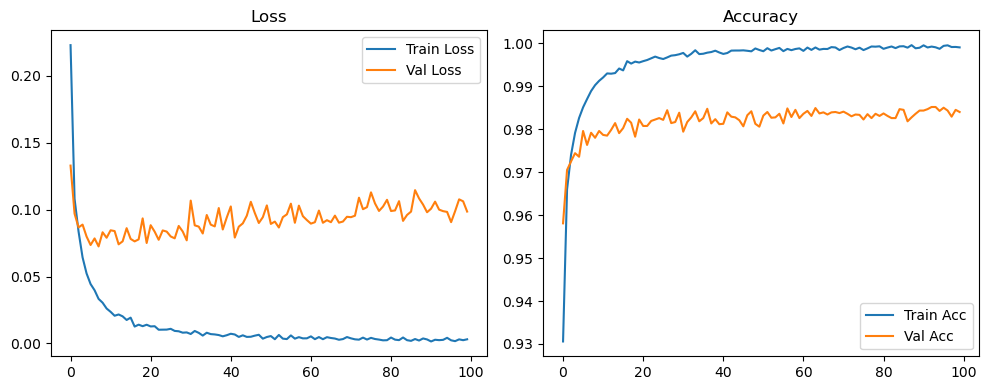

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2644, Acc: 0.9187 | Val Loss: 0.1410, Acc: 0.9577


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1421, Acc: 0.9560 | Val Loss: 0.1048, Acc: 0.9680


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1128, Acc: 0.9647 | Val Loss: 0.0878, Acc: 0.9720


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0913, Acc: 0.9705 | Val Loss: 0.0888, Acc: 0.9722


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0820, Acc: 0.9747 | Val Loss: 0.0813, Acc: 0.9762


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0731, Acc: 0.9765 | Val Loss: 0.0761, Acc: 0.9768


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9799 | Val Loss: 0.0778, Acc: 0.9763


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0599, Acc: 0.9806 | Val Loss: 0.0747, Acc: 0.9773


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9826 | Val Loss: 0.0765, Acc: 0.9787


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9839 | Val Loss: 0.0750, Acc: 0.9785


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0436, Acc: 0.9855 | Val Loss: 0.0717, Acc: 0.9806


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9864 | Val Loss: 0.0737, Acc: 0.9787


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9867 | Val Loss: 0.0682, Acc: 0.9812


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9884 | Val Loss: 0.0733, Acc: 0.9812


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9885 | Val Loss: 0.0701, Acc: 0.9818


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9886 | Val Loss: 0.0741, Acc: 0.9812


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.0743, Acc: 0.9807


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0716, Acc: 0.9809


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.0769, Acc: 0.9798


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9923 | Val Loss: 0.0750, Acc: 0.9807


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 0.0737, Acc: 0.9817


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.0735, Acc: 0.9819


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0690, Acc: 0.9828


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0750, Acc: 0.9823


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9925 | Val Loss: 0.0756, Acc: 0.9808


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.0736, Acc: 0.9824


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.0726, Acc: 0.9822


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0799, Acc: 0.9821


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9930 | Val Loss: 0.0767, Acc: 0.9817


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0741, Acc: 0.9820


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.0729, Acc: 0.9823


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0749, Acc: 0.9839


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0708, Acc: 0.9837


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0708, Acc: 0.9845


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0765, Acc: 0.9822


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0772, Acc: 0.9837


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0762, Acc: 0.9832


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0745, Acc: 0.9838


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0733, Acc: 0.9837


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.0820, Acc: 0.9833


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0849, Acc: 0.9818


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0781, Acc: 0.9838


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0757, Acc: 0.9831


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0806, Acc: 0.9832


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0811, Acc: 0.9832


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0830, Acc: 0.9818


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0846, Acc: 0.9837


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0780, Acc: 0.9844


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9954 | Val Loss: 0.0837, Acc: 0.9849


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0753, Acc: 0.9846


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0881, Acc: 0.9823


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0830, Acc: 0.9832


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0805, Acc: 0.9838


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0847, Acc: 0.9831


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0916, Acc: 0.9818


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0871, Acc: 0.9824


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0862, Acc: 0.9832


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0793, Acc: 0.9837


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0780, Acc: 0.9847


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0757, Acc: 0.9855


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0839, Acc: 0.9848


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9960 | Val Loss: 0.0857, Acc: 0.9845


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0811, Acc: 0.9838


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0847, Acc: 0.9828


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0878, Acc: 0.9829


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0784, Acc: 0.9836


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0869, Acc: 0.9830


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0844, Acc: 0.9829


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0822, Acc: 0.9842


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0780, Acc: 0.9846


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0871, Acc: 0.9832


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0879, Acc: 0.9833


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0839, Acc: 0.9840


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0839, Acc: 0.9842


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0860, Acc: 0.9831


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0819, Acc: 0.9841


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0825, Acc: 0.9842


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0866, Acc: 0.9835


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0892, Acc: 0.9832


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0925, Acc: 0.9828


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0830, Acc: 0.9849


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0856, Acc: 0.9840


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0914, Acc: 0.9842


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0876, Acc: 0.9833


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0813, Acc: 0.9849


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0868, Acc: 0.9837


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0873, Acc: 0.9846


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0893, Acc: 0.9845


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0856, Acc: 0.9845


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0859, Acc: 0.9843


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0923, Acc: 0.9842


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9983 | Val Loss: 0.0865, Acc: 0.9847


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0857, Acc: 0.9848


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0856, Acc: 0.9848


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0903, Acc: 0.9845


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0817, Acc: 0.9845


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0851, Acc: 0.9843


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0932, Acc: 0.9837


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0811, Acc: 0.9850


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0819, Acc: 0.9857


Final Test Loss: 0.0783 Accuracy: 0.9847


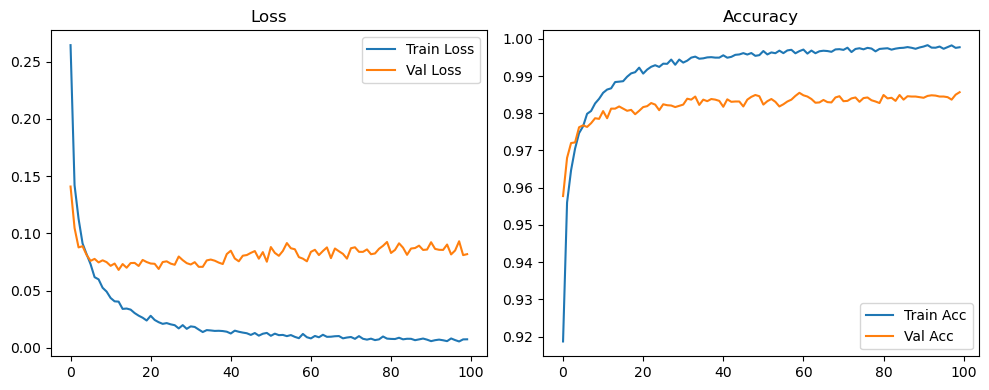

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3927, Acc: 0.8796 | Val Loss: 0.1692, Acc: 0.9473


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2358, Acc: 0.9280 | Val Loss: 0.1378, Acc: 0.9574


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1985, Acc: 0.9383 | Val Loss: 0.1104, Acc: 0.9673


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1720, Acc: 0.9478 | Val Loss: 0.1014, Acc: 0.9679


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1518, Acc: 0.9538 | Val Loss: 0.0962, Acc: 0.9702


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1398, Acc: 0.9568 | Val Loss: 0.0867, Acc: 0.9730


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1341, Acc: 0.9590 | Val Loss: 0.0818, Acc: 0.9756


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1227, Acc: 0.9613 | Val Loss: 0.0792, Acc: 0.9756


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1161, Acc: 0.9631 | Val Loss: 0.0784, Acc: 0.9759


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1128, Acc: 0.9645 | Val Loss: 0.0737, Acc: 0.9788


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1058, Acc: 0.9674 | Val Loss: 0.0780, Acc: 0.9770


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1020, Acc: 0.9677 | Val Loss: 0.0743, Acc: 0.9783


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0931, Acc: 0.9704 | Val Loss: 0.0710, Acc: 0.9783


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0944, Acc: 0.9694 | Val Loss: 0.0712, Acc: 0.9784


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0905, Acc: 0.9712 | Val Loss: 0.0717, Acc: 0.9781


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0873, Acc: 0.9726 | Val Loss: 0.0684, Acc: 0.9806


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0871, Acc: 0.9726 | Val Loss: 0.0701, Acc: 0.9796


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0779, Acc: 0.9750 | Val Loss: 0.0711, Acc: 0.9798


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0791, Acc: 0.9742 | Val Loss: 0.0714, Acc: 0.9793


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0750, Acc: 0.9760 | Val Loss: 0.0694, Acc: 0.9795


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0776, Acc: 0.9753 | Val Loss: 0.0668, Acc: 0.9810


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0770, Acc: 0.9754 | Val Loss: 0.0657, Acc: 0.9801


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0722, Acc: 0.9770 | Val Loss: 0.0662, Acc: 0.9804


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9780 | Val Loss: 0.0645, Acc: 0.9811


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0664, Acc: 0.9780 | Val Loss: 0.0690, Acc: 0.9801


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0682, Acc: 0.9780 | Val Loss: 0.0641, Acc: 0.9818


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0624, Acc: 0.9801 | Val Loss: 0.0662, Acc: 0.9814


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0631, Acc: 0.9794 | Val Loss: 0.0644, Acc: 0.9818


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.0632, Acc: 0.9826


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0591, Acc: 0.9810 | Val Loss: 0.0702, Acc: 0.9806


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0630, Acc: 0.9791 | Val Loss: 0.0672, Acc: 0.9813


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0556, Acc: 0.9815 | Val Loss: 0.0647, Acc: 0.9823


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0572, Acc: 0.9816 | Val Loss: 0.0649, Acc: 0.9833


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0532, Acc: 0.9819 | Val Loss: 0.0699, Acc: 0.9808


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0566, Acc: 0.9816 | Val Loss: 0.0696, Acc: 0.9811


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0565, Acc: 0.9812 | Val Loss: 0.0664, Acc: 0.9817


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0508, Acc: 0.9835 | Val Loss: 0.0642, Acc: 0.9808


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9826 | Val Loss: 0.0649, Acc: 0.9818


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0507, Acc: 0.9836 | Val Loss: 0.0647, Acc: 0.9823


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9832 | Val Loss: 0.0638, Acc: 0.9812


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0505, Acc: 0.9831 | Val Loss: 0.0599, Acc: 0.9832


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9839 | Val Loss: 0.0638, Acc: 0.9816


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9837 | Val Loss: 0.0651, Acc: 0.9821


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9843 | Val Loss: 0.0655, Acc: 0.9821


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0497, Acc: 0.9841 | Val Loss: 0.0657, Acc: 0.9809


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0457, Acc: 0.9848 | Val Loss: 0.0672, Acc: 0.9825


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9850 | Val Loss: 0.0640, Acc: 0.9830


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9847 | Val Loss: 0.0647, Acc: 0.9828


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.0677, Acc: 0.9825


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9861 | Val Loss: 0.0657, Acc: 0.9830


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9857 | Val Loss: 0.0679, Acc: 0.9818


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9867 | Val Loss: 0.0711, Acc: 0.9828


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9850 | Val Loss: 0.0661, Acc: 0.9828


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9861 | Val Loss: 0.0694, Acc: 0.9825


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9875 | Val Loss: 0.0725, Acc: 0.9817


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9862 | Val Loss: 0.0663, Acc: 0.9818


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.0663, Acc: 0.9832


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.0642, Acc: 0.9830


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9873 | Val Loss: 0.0680, Acc: 0.9823


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9861 | Val Loss: 0.0631, Acc: 0.9832


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.0670, Acc: 0.9828


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0391, Acc: 0.9879 | Val Loss: 0.0696, Acc: 0.9823


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0407, Acc: 0.9866 | Val Loss: 0.0696, Acc: 0.9828


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0655, Acc: 0.9835


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9870 | Val Loss: 0.0699, Acc: 0.9828


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9879 | Val Loss: 0.0681, Acc: 0.9828


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 0.0672, Acc: 0.9843


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9878 | Val Loss: 0.0694, Acc: 0.9829


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0691, Acc: 0.9822


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9882 | Val Loss: 0.0676, Acc: 0.9834


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9881 | Val Loss: 0.0688, Acc: 0.9827


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0685, Acc: 0.9832


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.0667, Acc: 0.9842


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.0658, Acc: 0.9844


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 0.0677, Acc: 0.9832


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 0.0632, Acc: 0.9842


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9891 | Val Loss: 0.0662, Acc: 0.9842


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.0639, Acc: 0.9841


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9887 | Val Loss: 0.0627, Acc: 0.9833


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.0672, Acc: 0.9838


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9899 | Val Loss: 0.0707, Acc: 0.9835


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9895 | Val Loss: 0.0652, Acc: 0.9828


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9891 | Val Loss: 0.0660, Acc: 0.9837


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0676, Acc: 0.9840


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.0681, Acc: 0.9827


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9893 | Val Loss: 0.0637, Acc: 0.9838


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9891 | Val Loss: 0.0636, Acc: 0.9842


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.0680, Acc: 0.9829


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9899 | Val Loss: 0.0694, Acc: 0.9830


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0692, Acc: 0.9837


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9900 | Val Loss: 0.0702, Acc: 0.9821


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9900 | Val Loss: 0.0694, Acc: 0.9828


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9895 | Val Loss: 0.0669, Acc: 0.9843


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9896 | Val Loss: 0.0700, Acc: 0.9826


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9897 | Val Loss: 0.0661, Acc: 0.9838


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9910 | Val Loss: 0.0679, Acc: 0.9833


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0696, Acc: 0.9837


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.0678, Acc: 0.9838


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9902 | Val Loss: 0.0705, Acc: 0.9838


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9906 | Val Loss: 0.0696, Acc: 0.9838


Final Test Loss: 0.0653 Accuracy: 0.9848


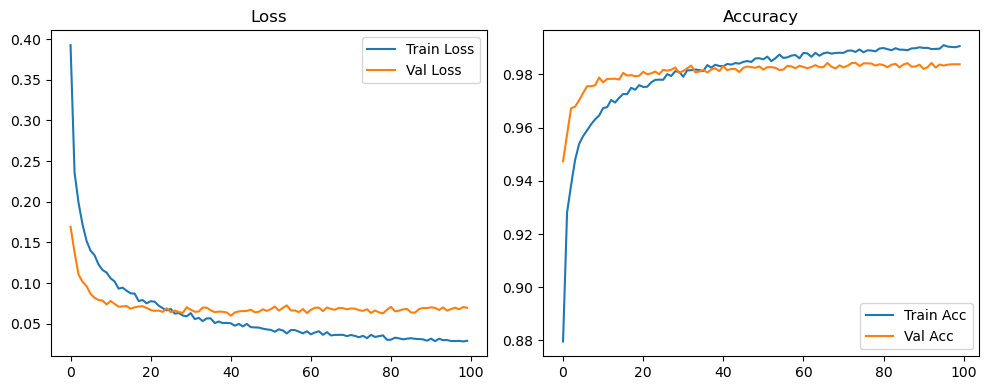

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2175, Acc: 0.9350 | Val Loss: 0.1223, Acc: 0.9627


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1008, Acc: 0.9688 | Val Loss: 0.0938, Acc: 0.9722


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0775, Acc: 0.9759 | Val Loss: 0.0829, Acc: 0.9732


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9803 | Val Loss: 0.0805, Acc: 0.9748


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9847 | Val Loss: 0.0778, Acc: 0.9763


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9860 | Val Loss: 0.0822, Acc: 0.9768


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.0750, Acc: 0.9778


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.0806, Acc: 0.9778


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.0769, Acc: 0.9790


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9923 | Val Loss: 0.0836, Acc: 0.9771


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9914 | Val Loss: 0.0801, Acc: 0.9802


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9928 | Val Loss: 0.0774, Acc: 0.9812


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9939 | Val Loss: 0.0733, Acc: 0.9811


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0749, Acc: 0.9794


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0770, Acc: 0.9810


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.0790, Acc: 0.9812


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0729, Acc: 0.9816


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0799, Acc: 0.9803


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9955 | Val Loss: 0.0807, Acc: 0.9802


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0753, Acc: 0.9819


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0741, Acc: 0.9829


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0798, Acc: 0.9823


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0750, Acc: 0.9818


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0820, Acc: 0.9792


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0957, Acc: 0.9808


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0962, Acc: 0.9800


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0891, Acc: 0.9822


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1025, Acc: 0.9788


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0880, Acc: 0.9808


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0774, Acc: 0.9822


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0901, Acc: 0.9817


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9970 | Val Loss: 0.0778, Acc: 0.9820


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0936, Acc: 0.9809


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0847, Acc: 0.9812


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0858, Acc: 0.9827


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0866, Acc: 0.9822


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0905, Acc: 0.9808


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0981, Acc: 0.9814


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0850, Acc: 0.9815


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0798, Acc: 0.9833


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0914, Acc: 0.9813


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0839, Acc: 0.9832


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0848, Acc: 0.9832


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.0778, Acc: 0.9839


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0891, Acc: 0.9812


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0811, Acc: 0.9828


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0873, Acc: 0.9828


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0855, Acc: 0.9838


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0913, Acc: 0.9836


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0905, Acc: 0.9835


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0874, Acc: 0.9849


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0981, Acc: 0.9822


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0998, Acc: 0.9824


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0944, Acc: 0.9820


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0907, Acc: 0.9838


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0842, Acc: 0.9832


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0879, Acc: 0.9840


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0901, Acc: 0.9839


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0982, Acc: 0.9818


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0900, Acc: 0.9826


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1033, Acc: 0.9822


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0986, Acc: 0.9814


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1004, Acc: 0.9828


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.0982, Acc: 0.9826


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0950, Acc: 0.9842


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0980, Acc: 0.9830


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1038, Acc: 0.9820


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1028, Acc: 0.9822


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1047, Acc: 0.9820


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0985, Acc: 0.9828


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1008, Acc: 0.9844


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1140, Acc: 0.9818


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1070, Acc: 0.9836


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1059, Acc: 0.9821


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1053, Acc: 0.9828


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1006, Acc: 0.9838


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1023, Acc: 0.9817


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0972, Acc: 0.9837


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1027, Acc: 0.9831


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1000, Acc: 0.9836


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1031, Acc: 0.9819


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0922, Acc: 0.9841


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1033, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0962, Acc: 0.9843


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0911, Acc: 0.9844


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0963, Acc: 0.9834


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0968, Acc: 0.9830


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1087, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1162, Acc: 0.9815


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1019, Acc: 0.9833


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1106, Acc: 0.9833


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1013, Acc: 0.9841


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1147, Acc: 0.9825


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1074, Acc: 0.9838


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1031, Acc: 0.9832


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1100, Acc: 0.9842


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1070, Acc: 0.9840


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1102, Acc: 0.9827


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1056, Acc: 0.9832


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0983, Acc: 0.9845


Final Test Loss: 0.0997 Accuracy: 0.9841


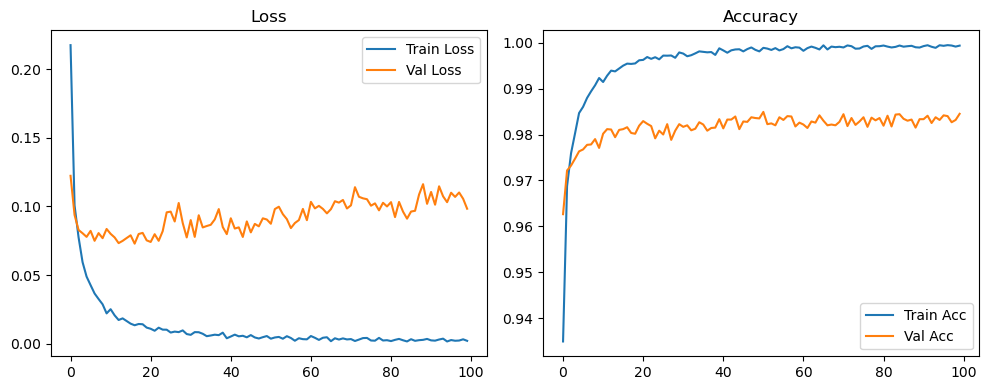

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2704, Acc: 0.9197 | Val Loss: 0.1338, Acc: 0.9592


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1386, Acc: 0.9574 | Val Loss: 0.1031, Acc: 0.9673


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1105, Acc: 0.9651 | Val Loss: 0.0917, Acc: 0.9712


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0897, Acc: 0.9714 | Val Loss: 0.0839, Acc: 0.9729


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0819, Acc: 0.9745 | Val Loss: 0.0779, Acc: 0.9745


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0732, Acc: 0.9759 | Val Loss: 0.0743, Acc: 0.9774


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9796 | Val Loss: 0.0773, Acc: 0.9775


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0595, Acc: 0.9809 | Val Loss: 0.0689, Acc: 0.9799


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0527, Acc: 0.9828 | Val Loss: 0.0740, Acc: 0.9785


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9838 | Val Loss: 0.0772, Acc: 0.9777


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9862 | Val Loss: 0.0722, Acc: 0.9797


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0428, Acc: 0.9855 | Val Loss: 0.0747, Acc: 0.9798


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9868 | Val Loss: 0.0715, Acc: 0.9813


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9874 | Val Loss: 0.0670, Acc: 0.9814


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9874 | Val Loss: 0.0715, Acc: 0.9810


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9895 | Val Loss: 0.0725, Acc: 0.9798


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.0695, Acc: 0.9802


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9905 | Val Loss: 0.0744, Acc: 0.9802


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9900 | Val Loss: 0.0768, Acc: 0.9810


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9917 | Val Loss: 0.0739, Acc: 0.9812


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.0728, Acc: 0.9815


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9916 | Val Loss: 0.0649, Acc: 0.9831


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9923 | Val Loss: 0.0673, Acc: 0.9830


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9919 | Val Loss: 0.0695, Acc: 0.9827


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0697, Acc: 0.9825


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9929 | Val Loss: 0.0738, Acc: 0.9818


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9925 | Val Loss: 0.0707, Acc: 0.9823


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0783, Acc: 0.9809


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0787, Acc: 0.9821


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0717, Acc: 0.9826


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0714, Acc: 0.9832


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9927 | Val Loss: 0.0712, Acc: 0.9837


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0700, Acc: 0.9825


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0702, Acc: 0.9831


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.0742, Acc: 0.9825


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0773, Acc: 0.9824


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0676, Acc: 0.9840


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0749, Acc: 0.9823


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0744, Acc: 0.9832


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0669, Acc: 0.9841


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0779, Acc: 0.9828


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.0708, Acc: 0.9834


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0680, Acc: 0.9840


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9950 | Val Loss: 0.0756, Acc: 0.9841


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0750, Acc: 0.9828


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0723, Acc: 0.9838


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0716, Acc: 0.9833


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0795, Acc: 0.9838


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9957 | Val Loss: 0.0833, Acc: 0.9838


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0815, Acc: 0.9840


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.0778, Acc: 0.9823


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0756, Acc: 0.9836


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0781, Acc: 0.9831


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0782, Acc: 0.9837


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0820, Acc: 0.9835


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0880, Acc: 0.9826


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0786, Acc: 0.9833


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0822, Acc: 0.9829


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0813, Acc: 0.9837


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0836, Acc: 0.9823


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0775, Acc: 0.9830


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0812, Acc: 0.9835


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0841, Acc: 0.9833


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0841, Acc: 0.9834


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0935, Acc: 0.9822


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0860, Acc: 0.9827


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0835, Acc: 0.9842


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0841, Acc: 0.9830


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0825, Acc: 0.9835


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0827, Acc: 0.9837


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0852, Acc: 0.9829


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0838, Acc: 0.9835


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0839, Acc: 0.9842


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0799, Acc: 0.9842


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0779, Acc: 0.9830


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0847, Acc: 0.9828


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0789, Acc: 0.9832


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0893, Acc: 0.9816


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0800, Acc: 0.9830


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0772, Acc: 0.9844


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0872, Acc: 0.9835


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0857, Acc: 0.9830


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0878, Acc: 0.9839


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0800, Acc: 0.9845


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0805, Acc: 0.9835


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0878, Acc: 0.9836


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0900, Acc: 0.9840


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0883, Acc: 0.9842


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0928, Acc: 0.9828


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0876, Acc: 0.9834


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0822, Acc: 0.9832


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0843, Acc: 0.9847


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0825, Acc: 0.9846


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0873, Acc: 0.9846


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0838, Acc: 0.9846


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0810, Acc: 0.9843


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0835, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0818, Acc: 0.9840


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0852, Acc: 0.9853


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0794, Acc: 0.9848


Final Test Loss: 0.0813 Accuracy: 0.9844


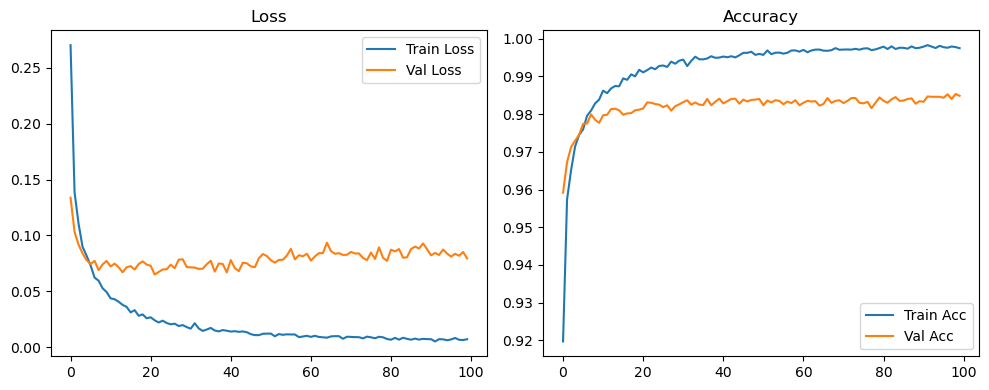

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4217, Acc: 0.8727 | Val Loss: 0.1778, Acc: 0.9453


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2427, Acc: 0.9265 | Val Loss: 0.1363, Acc: 0.9588


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2066, Acc: 0.9378 | Val Loss: 0.1158, Acc: 0.9661


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1779, Acc: 0.9450 | Val Loss: 0.1074, Acc: 0.9661


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1597, Acc: 0.9526 | Val Loss: 0.0999, Acc: 0.9682


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1450, Acc: 0.9556 | Val Loss: 0.0888, Acc: 0.9718


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1345, Acc: 0.9591 | Val Loss: 0.0909, Acc: 0.9722


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1295, Acc: 0.9604 | Val Loss: 0.0851, Acc: 0.9744


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1218, Acc: 0.9620 | Val Loss: 0.0838, Acc: 0.9741


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1173, Acc: 0.9636 | Val Loss: 0.0803, Acc: 0.9758


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1057, Acc: 0.9668 | Val Loss: 0.0795, Acc: 0.9758


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1051, Acc: 0.9674 | Val Loss: 0.0770, Acc: 0.9761


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0972, Acc: 0.9688 | Val Loss: 0.0753, Acc: 0.9780


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0950, Acc: 0.9697 | Val Loss: 0.0761, Acc: 0.9773


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0947, Acc: 0.9696 | Val Loss: 0.0713, Acc: 0.9783


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0890, Acc: 0.9714 | Val Loss: 0.0694, Acc: 0.9793


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0869, Acc: 0.9721 | Val Loss: 0.0689, Acc: 0.9783


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0839, Acc: 0.9731 | Val Loss: 0.0694, Acc: 0.9804


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0843, Acc: 0.9732 | Val Loss: 0.0703, Acc: 0.9791


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0811, Acc: 0.9734 | Val Loss: 0.0697, Acc: 0.9784


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0787, Acc: 0.9746 | Val Loss: 0.0742, Acc: 0.9786


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0736, Acc: 0.9756 | Val Loss: 0.0696, Acc: 0.9797


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0742, Acc: 0.9759 | Val Loss: 0.0680, Acc: 0.9794


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0701, Acc: 0.9775 | Val Loss: 0.0654, Acc: 0.9802


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0702, Acc: 0.9774 | Val Loss: 0.0676, Acc: 0.9807


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0696, Acc: 0.9772 | Val Loss: 0.0645, Acc: 0.9811


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0668, Acc: 0.9786 | Val Loss: 0.0694, Acc: 0.9801


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0638, Acc: 0.9791 | Val Loss: 0.0647, Acc: 0.9808


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0659, Acc: 0.9788 | Val Loss: 0.0656, Acc: 0.9808


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0593, Acc: 0.9811 | Val Loss: 0.0690, Acc: 0.9803


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0644, Acc: 0.9790 | Val Loss: 0.0651, Acc: 0.9816


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0575, Acc: 0.9809 | Val Loss: 0.0668, Acc: 0.9808


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9818 | Val Loss: 0.0659, Acc: 0.9825


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0594, Acc: 0.9811 | Val Loss: 0.0637, Acc: 0.9819


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0580, Acc: 0.9815 | Val Loss: 0.0662, Acc: 0.9817


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0573, Acc: 0.9808 | Val Loss: 0.0649, Acc: 0.9819


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9839 | Val Loss: 0.0629, Acc: 0.9814


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9822 | Val Loss: 0.0676, Acc: 0.9798


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0523, Acc: 0.9831 | Val Loss: 0.0649, Acc: 0.9816


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9829 | Val Loss: 0.0649, Acc: 0.9818


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0515, Acc: 0.9831 | Val Loss: 0.0646, Acc: 0.9822


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0505, Acc: 0.9836 | Val Loss: 0.0646, Acc: 0.9817


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9831 | Val Loss: 0.0632, Acc: 0.9816


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 0.0616, Acc: 0.9821


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0508, Acc: 0.9826 | Val Loss: 0.0620, Acc: 0.9818


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9845 | Val Loss: 0.0674, Acc: 0.9817


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9852 | Val Loss: 0.0672, Acc: 0.9818


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0449, Acc: 0.9854 | Val Loss: 0.0668, Acc: 0.9809


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9850 | Val Loss: 0.0688, Acc: 0.9810


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0463, Acc: 0.9845 | Val Loss: 0.0654, Acc: 0.9829


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9853 | Val Loss: 0.0626, Acc: 0.9822


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0430, Acc: 0.9863 | Val Loss: 0.0639, Acc: 0.9839


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9852 | Val Loss: 0.0620, Acc: 0.9835


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0454, Acc: 0.9853 | Val Loss: 0.0659, Acc: 0.9823


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9864 | Val Loss: 0.0665, Acc: 0.9829


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0447, Acc: 0.9854 | Val Loss: 0.0637, Acc: 0.9830


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9858 | Val Loss: 0.0658, Acc: 0.9830


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9858 | Val Loss: 0.0649, Acc: 0.9828


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9866 | Val Loss: 0.0647, Acc: 0.9825


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9859 | Val Loss: 0.0660, Acc: 0.9825


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9859 | Val Loss: 0.0650, Acc: 0.9835


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9869 | Val Loss: 0.0618, Acc: 0.9831


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9869 | Val Loss: 0.0676, Acc: 0.9818


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9868 | Val Loss: 0.0652, Acc: 0.9822


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0403, Acc: 0.9862 | Val Loss: 0.0696, Acc: 0.9815


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9880 | Val Loss: 0.0671, Acc: 0.9824


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9876 | Val Loss: 0.0673, Acc: 0.9827


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9867 | Val Loss: 0.0692, Acc: 0.9826


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9877 | Val Loss: 0.0686, Acc: 0.9813


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9873 | Val Loss: 0.0675, Acc: 0.9823


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.0693, Acc: 0.9828


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9873 | Val Loss: 0.0661, Acc: 0.9832


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9886 | Val Loss: 0.0662, Acc: 0.9834


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9870 | Val Loss: 0.0668, Acc: 0.9830


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9893 | Val Loss: 0.0645, Acc: 0.9831


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9877 | Val Loss: 0.0685, Acc: 0.9820


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9886 | Val Loss: 0.0660, Acc: 0.9828


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.0648, Acc: 0.9832


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0347, Acc: 0.9882 | Val Loss: 0.0681, Acc: 0.9824


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 0.0666, Acc: 0.9827


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.0687, Acc: 0.9821


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9887 | Val Loss: 0.0657, Acc: 0.9828


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.0692, Acc: 0.9822


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.0679, Acc: 0.9832


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9891 | Val Loss: 0.0689, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9889 | Val Loss: 0.0669, Acc: 0.9828


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0659, Acc: 0.9838


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.0696, Acc: 0.9828


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9886 | Val Loss: 0.0710, Acc: 0.9825


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9902 | Val Loss: 0.0706, Acc: 0.9830


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.0703, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.0696, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9896 | Val Loss: 0.0673, Acc: 0.9830


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9899 | Val Loss: 0.0666, Acc: 0.9832


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9899 | Val Loss: 0.0668, Acc: 0.9834


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9904 | Val Loss: 0.0690, Acc: 0.9830


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9903 | Val Loss: 0.0680, Acc: 0.9823


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0697, Acc: 0.9838


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0694, Acc: 0.9829


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9897 | Val Loss: 0.0688, Acc: 0.9830


Final Test Loss: 0.0616 Accuracy: 0.9846


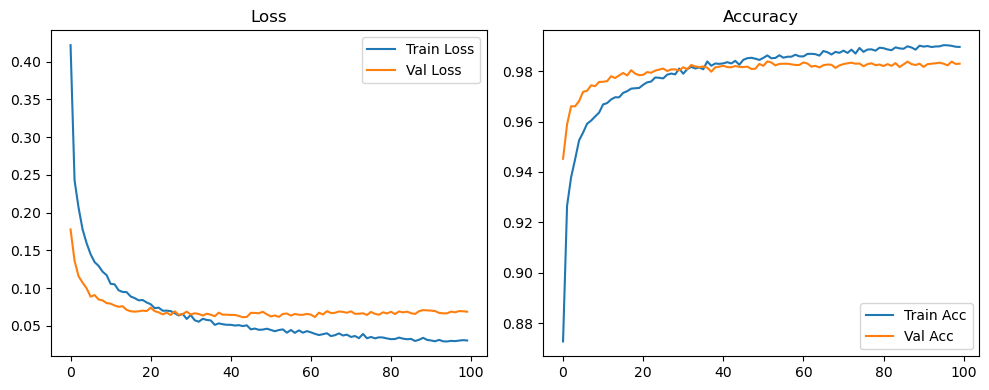

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2284, Acc: 0.9292 | Val Loss: 0.1459, Acc: 0.9547


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1094, Acc: 0.9661 | Val Loss: 0.1081, Acc: 0.9665


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9746 | Val Loss: 0.0933, Acc: 0.9709


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9800 | Val Loss: 0.0859, Acc: 0.9736


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9846 | Val Loss: 0.0930, Acc: 0.9732


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9870 | Val Loss: 0.0857, Acc: 0.9759


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 0.0875, Acc: 0.9762


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0774, Acc: 0.9781


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0860, Acc: 0.9781


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0896, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0903, Acc: 0.9779


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.0858, Acc: 0.9802


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0918, Acc: 0.9791


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0923, Acc: 0.9788


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1022, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0903, Acc: 0.9798


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0835, Acc: 0.9817


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1010, Acc: 0.9780


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0976, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1071, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1115, Acc: 0.9767


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0940, Acc: 0.9806


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0968, Acc: 0.9808


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0801, Acc: 0.9818


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0828, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0976, Acc: 0.9792


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1342, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0996, Acc: 0.9801


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0996, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1193, Acc: 0.9756


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0973, Acc: 0.9804


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1005, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1016, Acc: 0.9809


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1048, Acc: 0.9813


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0986, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1001, Acc: 0.9809


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1187, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1181, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1090, Acc: 0.9821


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1045, Acc: 0.9807


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0957, Acc: 0.9825


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0973, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0930, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1053, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0960, Acc: 0.9825


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0927, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1048, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0962, Acc: 0.9839


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1070, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1272, Acc: 0.9808


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1209, Acc: 0.9791


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1028, Acc: 0.9828


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1043, Acc: 0.9826


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1117, Acc: 0.9826


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1189, Acc: 0.9775


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1150, Acc: 0.9803


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0961, Acc: 0.9836


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1001, Acc: 0.9823


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1052, Acc: 0.9831


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1118, Acc: 0.9820


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1090, Acc: 0.9831


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1025, Acc: 0.9828


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1049, Acc: 0.9826


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9986 | Val Loss: 0.1105, Acc: 0.9838


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1207, Acc: 0.9805


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1096, Acc: 0.9819


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1079, Acc: 0.9823


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1095, Acc: 0.9810


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1124, Acc: 0.9812


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1217, Acc: 0.9810


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1203, Acc: 0.9822


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1160, Acc: 0.9816


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1204, Acc: 0.9821


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1136, Acc: 0.9811


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1120, Acc: 0.9813


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0958, Acc: 0.9825


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1015, Acc: 0.9828


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1075, Acc: 0.9817


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1143, Acc: 0.9815


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1202, Acc: 0.9822


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1321, Acc: 0.9811


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1153, Acc: 0.9826


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1079, Acc: 0.9831


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1205, Acc: 0.9828


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1085, Acc: 0.9831


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.1015, Acc: 0.9838


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1177, Acc: 0.9808


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1277, Acc: 0.9817


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1231, Acc: 0.9811


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1162, Acc: 0.9827


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1270, Acc: 0.9812


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1261, Acc: 0.9810


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1174, Acc: 0.9813


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1091, Acc: 0.9830


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1093, Acc: 0.9828


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1277, Acc: 0.9801


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1085, Acc: 0.9830


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1117, Acc: 0.9821


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1187, Acc: 0.9829


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1092, Acc: 0.9830


Final Test Loss: 0.1161 Accuracy: 0.9840


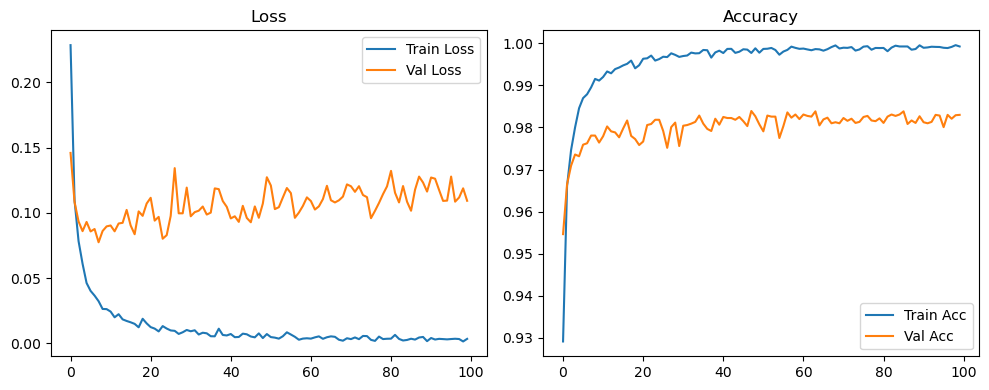

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2637, Acc: 0.9183 | Val Loss: 0.1454, Acc: 0.9562


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1360, Acc: 0.9581 | Val Loss: 0.1065, Acc: 0.9680


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1061, Acc: 0.9666 | Val Loss: 0.1044, Acc: 0.9688


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9738 | Val Loss: 0.0792, Acc: 0.9751


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9774 | Val Loss: 0.0903, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9790 | Val Loss: 0.0736, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9809 | Val Loss: 0.0789, Acc: 0.9779


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9842 | Val Loss: 0.0743, Acc: 0.9776


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9843 | Val Loss: 0.0798, Acc: 0.9785


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9854 | Val Loss: 0.0749, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.0835, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.0751, Acc: 0.9798


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.0766, Acc: 0.9798


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0765, Acc: 0.9802


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.0768, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9892 | Val Loss: 0.0803, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0781, Acc: 0.9811


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 0.0802, Acc: 0.9797


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.0737, Acc: 0.9819


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9912 | Val Loss: 0.0839, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0789, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0869, Acc: 0.9811


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.0823, Acc: 0.9808


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0851, Acc: 0.9806


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0909, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0875, Acc: 0.9805


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0788, Acc: 0.9806


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0892, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0796, Acc: 0.9820


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.0974, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0740, Acc: 0.9819


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0802, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.0775, Acc: 0.9829


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9947 | Val Loss: 0.0925, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0807, Acc: 0.9821


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0822, Acc: 0.9837


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0877, Acc: 0.9826


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0729, Acc: 0.9836


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0815, Acc: 0.9823


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0941, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.0802, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0887, Acc: 0.9828


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0880, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0883, Acc: 0.9826


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9961 | Val Loss: 0.0876, Acc: 0.9826


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0858, Acc: 0.9823


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0839, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0904, Acc: 0.9823


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.0972, Acc: 0.9803


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0960, Acc: 0.9800


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0930, Acc: 0.9821


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0973, Acc: 0.9812


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0840, Acc: 0.9826


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0872, Acc: 0.9829


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0940, Acc: 0.9825


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0969, Acc: 0.9812


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0981, Acc: 0.9804


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0930, Acc: 0.9828


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0914, Acc: 0.9832


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.0908, Acc: 0.9832


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0938, Acc: 0.9828


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0939, Acc: 0.9821


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0951, Acc: 0.9818


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0867, Acc: 0.9822


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0895, Acc: 0.9812


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1050, Acc: 0.9814


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1054, Acc: 0.9813


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1045, Acc: 0.9821


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0995, Acc: 0.9822


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1007, Acc: 0.9815


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9969 | Val Loss: 0.1010, Acc: 0.9814


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1055, Acc: 0.9822


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0961, Acc: 0.9830


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0999, Acc: 0.9824


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.0980, Acc: 0.9831


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0959, Acc: 0.9822


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1021, Acc: 0.9829


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1032, Acc: 0.9834


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0903, Acc: 0.9834


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0929, Acc: 0.9840


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0982, Acc: 0.9822


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0958, Acc: 0.9838


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0996, Acc: 0.9838


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1041, Acc: 0.9828


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0997, Acc: 0.9827


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1009, Acc: 0.9832


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0898, Acc: 0.9852


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.0923, Acc: 0.9836


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0898, Acc: 0.9834


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0959, Acc: 0.9843


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0955, Acc: 0.9842


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.0951, Acc: 0.9822


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0898, Acc: 0.9840


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0991, Acc: 0.9831


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1034, Acc: 0.9839


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.0949, Acc: 0.9836


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1120, Acc: 0.9822


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1121, Acc: 0.9823


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1006, Acc: 0.9819


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0977, Acc: 0.9833


Final Test Loss: 0.0953 Accuracy: 0.9847


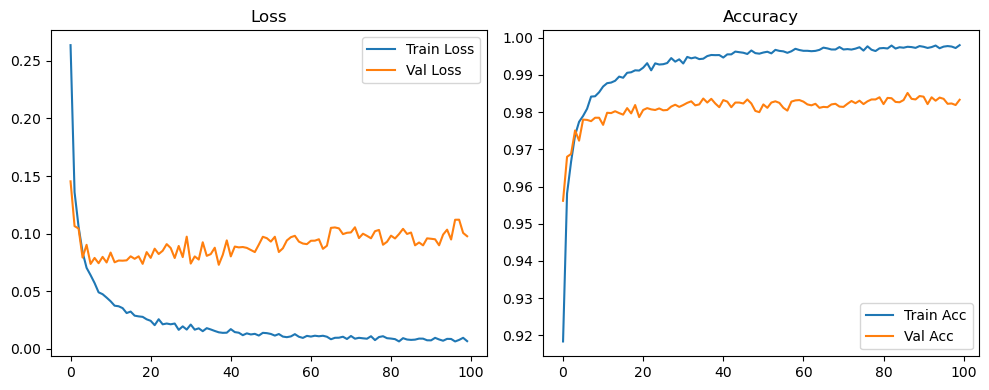

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3758, Acc: 0.8845 | Val Loss: 0.1666, Acc: 0.9498


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2216, Acc: 0.9336 | Val Loss: 0.1212, Acc: 0.9634


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1762, Acc: 0.9467 | Val Loss: 0.1070, Acc: 0.9674


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1527, Acc: 0.9533 | Val Loss: 0.0958, Acc: 0.9710


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9581 | Val Loss: 0.0896, Acc: 0.9714


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9603 | Val Loss: 0.0893, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9632 | Val Loss: 0.0840, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9666 | Val Loss: 0.0803, Acc: 0.9761


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1063, Acc: 0.9674 | Val Loss: 0.0767, Acc: 0.9777


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9685 | Val Loss: 0.0789, Acc: 0.9776


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9700 | Val Loss: 0.0750, Acc: 0.9776


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9722 | Val Loss: 0.0726, Acc: 0.9789


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.0750, Acc: 0.9782


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9735 | Val Loss: 0.0752, Acc: 0.9771


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0837, Acc: 0.9744 | Val Loss: 0.0707, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9739 | Val Loss: 0.0719, Acc: 0.9795


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9755 | Val Loss: 0.0701, Acc: 0.9805


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9750 | Val Loss: 0.0737, Acc: 0.9790


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9769 | Val Loss: 0.0702, Acc: 0.9798


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9781 | Val Loss: 0.0710, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9769 | Val Loss: 0.0710, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9782 | Val Loss: 0.0669, Acc: 0.9821


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9796 | Val Loss: 0.0719, Acc: 0.9793


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9788 | Val Loss: 0.0654, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9806 | Val Loss: 0.0752, Acc: 0.9799


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9804 | Val Loss: 0.0662, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9806 | Val Loss: 0.0675, Acc: 0.9817


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.0667, Acc: 0.9798


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9825 | Val Loss: 0.0698, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9808 | Val Loss: 0.0645, Acc: 0.9826


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9833 | Val Loss: 0.0686, Acc: 0.9822


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9820 | Val Loss: 0.0680, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9829 | Val Loss: 0.0656, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.0721, Acc: 0.9826


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9838 | Val Loss: 0.0718, Acc: 0.9807


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 0.0685, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9840 | Val Loss: 0.0734, Acc: 0.9818


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9840 | Val Loss: 0.0737, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9845 | Val Loss: 0.0736, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0690, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9842 | Val Loss: 0.0681, Acc: 0.9823


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.0782, Acc: 0.9816


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.0712, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.0754, Acc: 0.9807


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9873 | Val Loss: 0.0704, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9860 | Val Loss: 0.0766, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.0729, Acc: 0.9824


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9855 | Val Loss: 0.0695, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9857 | Val Loss: 0.0679, Acc: 0.9825


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.0703, Acc: 0.9816


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9873 | Val Loss: 0.0694, Acc: 0.9828


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9865 | Val Loss: 0.0681, Acc: 0.9834


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0402, Acc: 0.9871 | Val Loss: 0.0726, Acc: 0.9832


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9859 | Val Loss: 0.0733, Acc: 0.9823


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9876 | Val Loss: 0.0745, Acc: 0.9822


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9880 | Val Loss: 0.0710, Acc: 0.9823


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9865 | Val Loss: 0.0695, Acc: 0.9841


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0396, Acc: 0.9873 | Val Loss: 0.0708, Acc: 0.9832


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9871 | Val Loss: 0.0729, Acc: 0.9841


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9874 | Val Loss: 0.0728, Acc: 0.9833


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9878 | Val Loss: 0.0711, Acc: 0.9838


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9879 | Val Loss: 0.0774, Acc: 0.9824


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9869 | Val Loss: 0.0765, Acc: 0.9818


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9889 | Val Loss: 0.0735, Acc: 0.9826


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9880 | Val Loss: 0.0779, Acc: 0.9829


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9892 | Val Loss: 0.0751, Acc: 0.9823


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9881 | Val Loss: 0.0754, Acc: 0.9828


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9878 | Val Loss: 0.0753, Acc: 0.9828


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0766, Acc: 0.9828


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 0.0727, Acc: 0.9829


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9887 | Val Loss: 0.0742, Acc: 0.9822


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9890 | Val Loss: 0.0778, Acc: 0.9833


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.0779, Acc: 0.9826


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9880 | Val Loss: 0.0735, Acc: 0.9832


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.0750, Acc: 0.9840


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.0763, Acc: 0.9829


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9878 | Val Loss: 0.0743, Acc: 0.9840


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.0758, Acc: 0.9836


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9902 | Val Loss: 0.0819, Acc: 0.9837


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9901 | Val Loss: 0.0800, Acc: 0.9825


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9893 | Val Loss: 0.0817, Acc: 0.9814


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9907 | Val Loss: 0.0747, Acc: 0.9832


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0797, Acc: 0.9833


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.0822, Acc: 0.9828


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9890 | Val Loss: 0.0772, Acc: 0.9837


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0311, Acc: 0.9904 | Val Loss: 0.0779, Acc: 0.9838


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9903 | Val Loss: 0.0792, Acc: 0.9834


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9892 | Val Loss: 0.0701, Acc: 0.9838


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9902 | Val Loss: 0.0712, Acc: 0.9842


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.0824, Acc: 0.9835


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0342, Acc: 0.9893 | Val Loss: 0.0774, Acc: 0.9850


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9894 | Val Loss: 0.0716, Acc: 0.9830


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9909 | Val Loss: 0.0765, Acc: 0.9828


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9900 | Val Loss: 0.0827, Acc: 0.9833


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9898 | Val Loss: 0.0789, Acc: 0.9832


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9909 | Val Loss: 0.0800, Acc: 0.9836


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9907 | Val Loss: 0.0808, Acc: 0.9821


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9907 | Val Loss: 0.0889, Acc: 0.9823


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9897 | Val Loss: 0.0754, Acc: 0.9836


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9905 | Val Loss: 0.0762, Acc: 0.9832


Final Test Loss: 0.0684 Accuracy: 0.9847


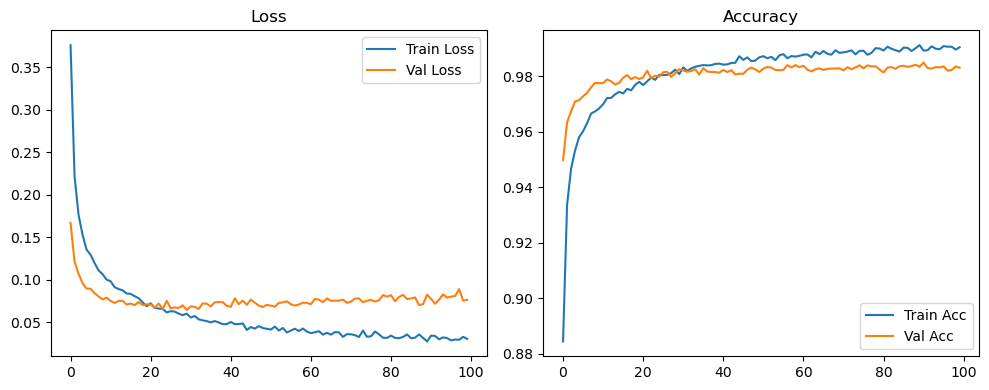

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2284, Acc: 0.9292 | Val Loss: 0.1459, Acc: 0.9547


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1094, Acc: 0.9661 | Val Loss: 0.1081, Acc: 0.9665


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9746 | Val Loss: 0.0933, Acc: 0.9709


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9800 | Val Loss: 0.0859, Acc: 0.9736


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9846 | Val Loss: 0.0930, Acc: 0.9732


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9870 | Val Loss: 0.0857, Acc: 0.9759


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 0.0875, Acc: 0.9762


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0774, Acc: 0.9781


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0860, Acc: 0.9781


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0896, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0903, Acc: 0.9779


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.0858, Acc: 0.9802


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0918, Acc: 0.9791


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0923, Acc: 0.9788


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1022, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0903, Acc: 0.9798


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0835, Acc: 0.9817


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1010, Acc: 0.9780


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0976, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1071, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1115, Acc: 0.9767


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0940, Acc: 0.9806


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0968, Acc: 0.9808


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0801, Acc: 0.9818


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0828, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0976, Acc: 0.9792


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1342, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0996, Acc: 0.9801


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0996, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1193, Acc: 0.9756


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0973, Acc: 0.9804


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1005, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1016, Acc: 0.9809


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1048, Acc: 0.9813


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0986, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1001, Acc: 0.9809


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1187, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1181, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1090, Acc: 0.9821


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1045, Acc: 0.9807


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0957, Acc: 0.9825


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0973, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0930, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1053, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0960, Acc: 0.9825


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0927, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1048, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0962, Acc: 0.9839


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1070, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1272, Acc: 0.9808


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0955, Acc: 0.9839


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0988, Acc: 0.9841


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0993, Acc: 0.9843


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1009, Acc: 0.9842


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1018, Acc: 0.9841


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1062, Acc: 0.9849


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1047, Acc: 0.9841


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1110, Acc: 0.9828


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1144, Acc: 0.9835


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1094, Acc: 0.9845


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1091, Acc: 0.9843


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1077, Acc: 0.9835


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1007, Acc: 0.9858


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1082, Acc: 0.9850


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1091, Acc: 0.9845


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1077, Acc: 0.9855


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1135, Acc: 0.9839


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1137, Acc: 0.9844


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1265, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1093, Acc: 0.9827


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1115, Acc: 0.9828


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1150, Acc: 0.9831


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1156, Acc: 0.9829


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1082, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1168, Acc: 0.9836


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1112, Acc: 0.9851


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1194, Acc: 0.9828


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1289, Acc: 0.9827


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1185, Acc: 0.9838


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1200, Acc: 0.9819


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1107, Acc: 0.9835


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1106, Acc: 0.9841


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1100, Acc: 0.9842


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1048, Acc: 0.9850


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1080, Acc: 0.9843


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1085, Acc: 0.9853


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1113, Acc: 0.9854


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1158, Acc: 0.9847


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1191, Acc: 0.9840


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1186, Acc: 0.9842


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1263, Acc: 0.9831


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1185, Acc: 0.9852


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1175, Acc: 0.9852


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1244, Acc: 0.9848


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1243, Acc: 0.9850


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1203, Acc: 0.9851


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1246, Acc: 0.9844


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1233, Acc: 0.9842


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1262, Acc: 0.9837


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1255, Acc: 0.9843


Final Test Loss: 0.1078 Accuracy: 0.9847


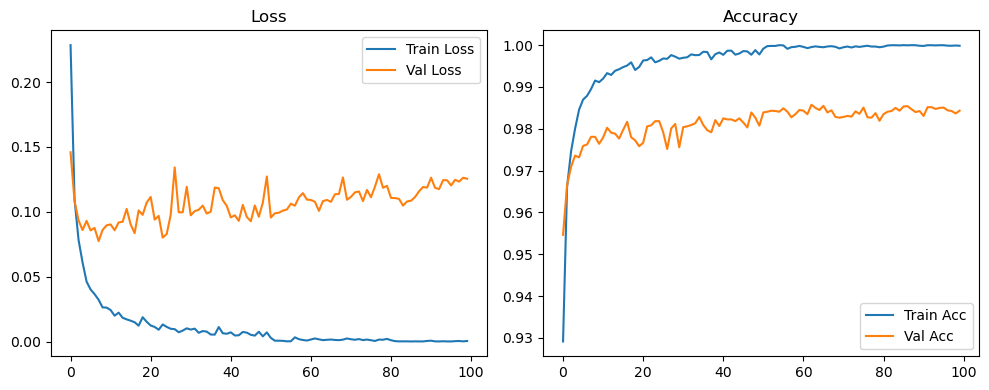

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2637, Acc: 0.9183 | Val Loss: 0.1454, Acc: 0.9562


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1360, Acc: 0.9581 | Val Loss: 0.1065, Acc: 0.9680


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1061, Acc: 0.9666 | Val Loss: 0.1044, Acc: 0.9688


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9738 | Val Loss: 0.0792, Acc: 0.9751


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9774 | Val Loss: 0.0903, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9790 | Val Loss: 0.0736, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9809 | Val Loss: 0.0789, Acc: 0.9779


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9842 | Val Loss: 0.0743, Acc: 0.9776


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9843 | Val Loss: 0.0798, Acc: 0.9785


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9854 | Val Loss: 0.0749, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.0835, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.0751, Acc: 0.9798


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.0766, Acc: 0.9798


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0765, Acc: 0.9802


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.0768, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9892 | Val Loss: 0.0803, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0781, Acc: 0.9811


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 0.0802, Acc: 0.9797


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.0737, Acc: 0.9819


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9912 | Val Loss: 0.0839, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0789, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0869, Acc: 0.9811


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.0823, Acc: 0.9808


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0851, Acc: 0.9806


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0909, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0875, Acc: 0.9805


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0788, Acc: 0.9806


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0892, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0796, Acc: 0.9820


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.0974, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0740, Acc: 0.9819


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0802, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.0775, Acc: 0.9829


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9947 | Val Loss: 0.0925, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0807, Acc: 0.9821


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0822, Acc: 0.9837


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0877, Acc: 0.9826


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0729, Acc: 0.9836


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0815, Acc: 0.9823


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0941, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.0802, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0887, Acc: 0.9828


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0880, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0883, Acc: 0.9826


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9961 | Val Loss: 0.0876, Acc: 0.9826


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0858, Acc: 0.9823


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0839, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0904, Acc: 0.9823


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.0972, Acc: 0.9803


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0960, Acc: 0.9800


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0848, Acc: 0.9835


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0876, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0792, Acc: 0.9844


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0819, Acc: 0.9841


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0899, Acc: 0.9842


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0911, Acc: 0.9842


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0959, Acc: 0.9840


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0982, Acc: 0.9839


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1004, Acc: 0.9838


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1015, Acc: 0.9833


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1004, Acc: 0.9839


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1120, Acc: 0.9828


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0949, Acc: 0.9836


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0989, Acc: 0.9829


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0999, Acc: 0.9832


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0962, Acc: 0.9846


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0979, Acc: 0.9837


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0940, Acc: 0.9839


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0943, Acc: 0.9833


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0957, Acc: 0.9841


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1023, Acc: 0.9830


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1025, Acc: 0.9835


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0996, Acc: 0.9848


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1029, Acc: 0.9839


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0952, Acc: 0.9841


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0953, Acc: 0.9844


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0919, Acc: 0.9856


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0943, Acc: 0.9847


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0930, Acc: 0.9862


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0952, Acc: 0.9850


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0921, Acc: 0.9851


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0885, Acc: 0.9852


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0863, Acc: 0.9858


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0849, Acc: 0.9861


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0842, Acc: 0.9866


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0843, Acc: 0.9868


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0876, Acc: 0.9858


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0865, Acc: 0.9857


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0914, Acc: 0.9847


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0925, Acc: 0.9849


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0986, Acc: 0.9848


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0974, Acc: 0.9837


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0929, Acc: 0.9847


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0932, Acc: 0.9844


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0943, Acc: 0.9853


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0904, Acc: 0.9856


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0953, Acc: 0.9856


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0964, Acc: 0.9843


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0987, Acc: 0.9852


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1001, Acc: 0.9850


Final Test Loss: 0.1008 Accuracy: 0.9849


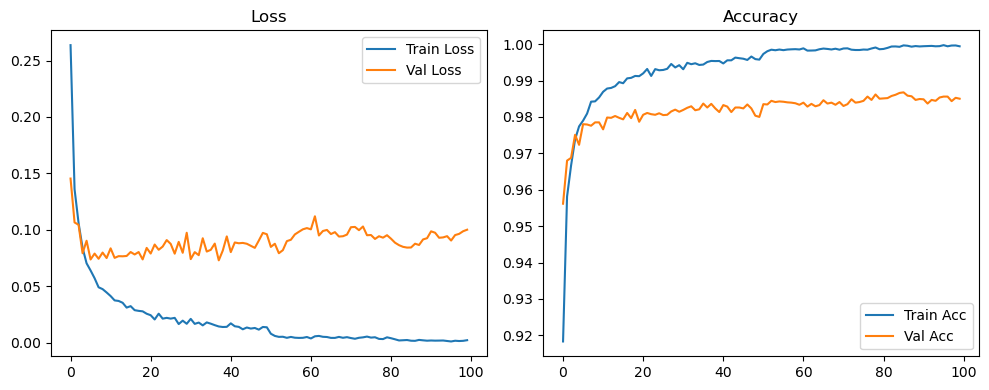

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3758, Acc: 0.8845 | Val Loss: 0.1666, Acc: 0.9498


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2216, Acc: 0.9336 | Val Loss: 0.1212, Acc: 0.9634


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1762, Acc: 0.9467 | Val Loss: 0.1070, Acc: 0.9674


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1527, Acc: 0.9533 | Val Loss: 0.0958, Acc: 0.9710


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9581 | Val Loss: 0.0896, Acc: 0.9714


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9603 | Val Loss: 0.0893, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9632 | Val Loss: 0.0840, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9666 | Val Loss: 0.0803, Acc: 0.9761


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1063, Acc: 0.9674 | Val Loss: 0.0767, Acc: 0.9777


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9685 | Val Loss: 0.0789, Acc: 0.9776


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9700 | Val Loss: 0.0750, Acc: 0.9776


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9722 | Val Loss: 0.0726, Acc: 0.9789


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.0750, Acc: 0.9782


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9735 | Val Loss: 0.0752, Acc: 0.9771


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0837, Acc: 0.9744 | Val Loss: 0.0707, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9739 | Val Loss: 0.0719, Acc: 0.9795


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9755 | Val Loss: 0.0701, Acc: 0.9805


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9750 | Val Loss: 0.0737, Acc: 0.9790


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9769 | Val Loss: 0.0702, Acc: 0.9798


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9781 | Val Loss: 0.0710, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9769 | Val Loss: 0.0710, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9782 | Val Loss: 0.0669, Acc: 0.9821


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9796 | Val Loss: 0.0719, Acc: 0.9793


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9788 | Val Loss: 0.0654, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9806 | Val Loss: 0.0752, Acc: 0.9799


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9804 | Val Loss: 0.0662, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9806 | Val Loss: 0.0675, Acc: 0.9817


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.0667, Acc: 0.9798


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9825 | Val Loss: 0.0698, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9808 | Val Loss: 0.0645, Acc: 0.9826


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9833 | Val Loss: 0.0686, Acc: 0.9822


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9820 | Val Loss: 0.0680, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9829 | Val Loss: 0.0656, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.0721, Acc: 0.9826


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9838 | Val Loss: 0.0718, Acc: 0.9807


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 0.0685, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9840 | Val Loss: 0.0734, Acc: 0.9818


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9840 | Val Loss: 0.0737, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9845 | Val Loss: 0.0736, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0690, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9842 | Val Loss: 0.0681, Acc: 0.9823


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.0782, Acc: 0.9816


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.0712, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.0754, Acc: 0.9807


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9873 | Val Loss: 0.0704, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9860 | Val Loss: 0.0766, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.0729, Acc: 0.9824


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9855 | Val Loss: 0.0695, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9857 | Val Loss: 0.0679, Acc: 0.9825


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.0703, Acc: 0.9816


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0678, Acc: 0.9845


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9899 | Val Loss: 0.0682, Acc: 0.9842


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.0659, Acc: 0.9844


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9912 | Val Loss: 0.0707, Acc: 0.9834


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0702, Acc: 0.9834


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0688, Acc: 0.9834


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9916 | Val Loss: 0.0711, Acc: 0.9833


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0709, Acc: 0.9836


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.0726, Acc: 0.9842


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0714, Acc: 0.9835


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.0732, Acc: 0.9837


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.0711, Acc: 0.9835


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0750, Acc: 0.9826


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9927 | Val Loss: 0.0719, Acc: 0.9834


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0727, Acc: 0.9839


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9931 | Val Loss: 0.0713, Acc: 0.9842


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0726, Acc: 0.9843


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.0738, Acc: 0.9844


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0748, Acc: 0.9835


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.0740, Acc: 0.9847


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0751, Acc: 0.9845


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0707, Acc: 0.9846


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0783, Acc: 0.9832


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9926 | Val Loss: 0.0716, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0700, Acc: 0.9842


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0753, Acc: 0.9837


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0725, Acc: 0.9841


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.0772, Acc: 0.9813


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.0775, Acc: 0.9836


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0748, Acc: 0.9835


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.0728, Acc: 0.9841


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.0742, Acc: 0.9833


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0764, Acc: 0.9834


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0755, Acc: 0.9837


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.0745, Acc: 0.9842


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0759, Acc: 0.9837


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0740, Acc: 0.9847


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0738, Acc: 0.9841


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0742, Acc: 0.9845


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0751, Acc: 0.9844


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.0742, Acc: 0.9845


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0746, Acc: 0.9842


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9957 | Val Loss: 0.0704, Acc: 0.9849


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.0724, Acc: 0.9848


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0737, Acc: 0.9843


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9960 | Val Loss: 0.0724, Acc: 0.9847


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0741, Acc: 0.9849


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0755, Acc: 0.9848


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0752, Acc: 0.9846


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.0739, Acc: 0.9849


Final Test Loss: 0.0671 Accuracy: 0.9855


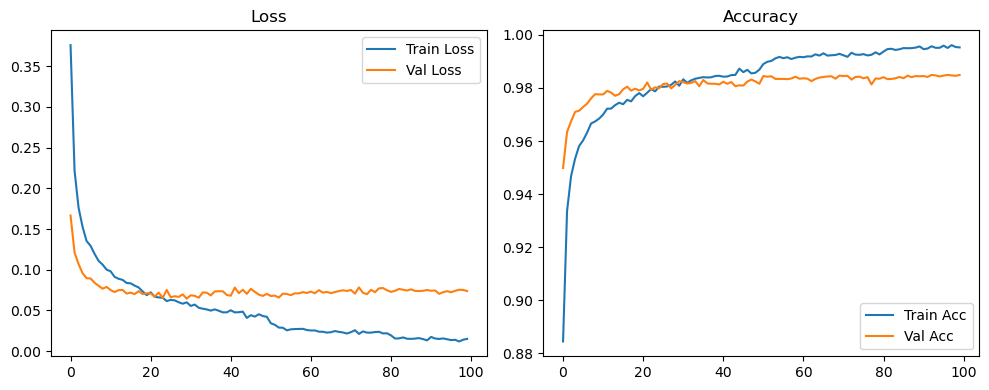

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2284, Acc: 0.9292 | Val Loss: 0.1459, Acc: 0.9547


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1094, Acc: 0.9661 | Val Loss: 0.1081, Acc: 0.9665


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9746 | Val Loss: 0.0933, Acc: 0.9709


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9800 | Val Loss: 0.0859, Acc: 0.9736


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9846 | Val Loss: 0.0930, Acc: 0.9732


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9870 | Val Loss: 0.0857, Acc: 0.9759


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 0.0875, Acc: 0.9762


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0774, Acc: 0.9781


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0860, Acc: 0.9781


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0896, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0903, Acc: 0.9779


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.0858, Acc: 0.9802


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0918, Acc: 0.9791


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0923, Acc: 0.9788


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1022, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0903, Acc: 0.9798


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0835, Acc: 0.9817


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1010, Acc: 0.9780


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0976, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1071, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1115, Acc: 0.9767


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0940, Acc: 0.9806


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0968, Acc: 0.9808


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0801, Acc: 0.9818


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0828, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0976, Acc: 0.9792


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1342, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0996, Acc: 0.9801


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0996, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1193, Acc: 0.9756


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0973, Acc: 0.9804


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1005, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1016, Acc: 0.9809


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1048, Acc: 0.9813


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0986, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1001, Acc: 0.9809


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1187, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1181, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1090, Acc: 0.9821


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1045, Acc: 0.9807


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0957, Acc: 0.9825


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0973, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0930, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1053, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0960, Acc: 0.9825


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0927, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1048, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0962, Acc: 0.9839


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1070, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1272, Acc: 0.9808


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0955, Acc: 0.9839


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0988, Acc: 0.9841


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0993, Acc: 0.9843


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1009, Acc: 0.9842


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1018, Acc: 0.9841


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1062, Acc: 0.9849


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1047, Acc: 0.9841


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1110, Acc: 0.9828


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1144, Acc: 0.9835


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1094, Acc: 0.9845


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1091, Acc: 0.9843


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1077, Acc: 0.9835


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1007, Acc: 0.9858


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1082, Acc: 0.9850


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1091, Acc: 0.9845


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1077, Acc: 0.9855


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1135, Acc: 0.9839


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1137, Acc: 0.9844


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1265, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1093, Acc: 0.9827


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1115, Acc: 0.9828


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1150, Acc: 0.9831


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1156, Acc: 0.9829


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1082, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1168, Acc: 0.9836


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1112, Acc: 0.9851


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1194, Acc: 0.9828


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1289, Acc: 0.9827


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1185, Acc: 0.9838


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1200, Acc: 0.9819


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1122, Acc: 0.9833


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1128, Acc: 0.9839


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1112, Acc: 0.9839


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1059, Acc: 0.9844


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1084, Acc: 0.9845


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1085, Acc: 0.9846


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1085, Acc: 0.9847


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1121, Acc: 0.9844


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1126, Acc: 0.9842


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1111, Acc: 0.9849


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1164, Acc: 0.9838


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1173, Acc: 0.9847


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1150, Acc: 0.9843


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1159, Acc: 0.9848


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1170, Acc: 0.9845


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1153, Acc: 0.9850


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1278, Acc: 0.9835


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1210, Acc: 0.9842


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1259, Acc: 0.9839


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1251, Acc: 0.9844


Final Test Loss: 0.1094 Accuracy: 0.9848


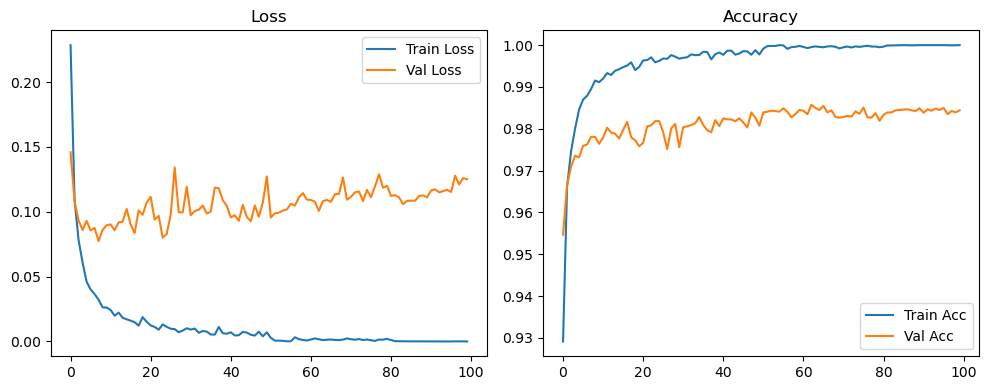

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2637, Acc: 0.9183 | Val Loss: 0.1454, Acc: 0.9562


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1360, Acc: 0.9581 | Val Loss: 0.1065, Acc: 0.9680


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1061, Acc: 0.9666 | Val Loss: 0.1044, Acc: 0.9688


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9738 | Val Loss: 0.0792, Acc: 0.9751


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9774 | Val Loss: 0.0903, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9790 | Val Loss: 0.0736, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9809 | Val Loss: 0.0789, Acc: 0.9779


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9842 | Val Loss: 0.0743, Acc: 0.9776


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9843 | Val Loss: 0.0798, Acc: 0.9785


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9854 | Val Loss: 0.0749, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.0835, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.0751, Acc: 0.9798


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.0766, Acc: 0.9798


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0765, Acc: 0.9802


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.0768, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9892 | Val Loss: 0.0803, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0781, Acc: 0.9811


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 0.0802, Acc: 0.9797


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.0737, Acc: 0.9819


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9912 | Val Loss: 0.0839, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0789, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0869, Acc: 0.9811


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.0823, Acc: 0.9808


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0851, Acc: 0.9806


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0909, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0875, Acc: 0.9805


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0788, Acc: 0.9806


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0892, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0796, Acc: 0.9820


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.0974, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0740, Acc: 0.9819


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0802, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.0775, Acc: 0.9829


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9947 | Val Loss: 0.0925, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0807, Acc: 0.9821


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0822, Acc: 0.9837


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0877, Acc: 0.9826


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0729, Acc: 0.9836


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0815, Acc: 0.9823


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0941, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.0802, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0887, Acc: 0.9828


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0880, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0883, Acc: 0.9826


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9961 | Val Loss: 0.0876, Acc: 0.9826


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0858, Acc: 0.9823


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0839, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0904, Acc: 0.9823


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.0972, Acc: 0.9803


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0960, Acc: 0.9800


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0848, Acc: 0.9835


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0876, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0792, Acc: 0.9844


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0819, Acc: 0.9841


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0899, Acc: 0.9842


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0911, Acc: 0.9842


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0959, Acc: 0.9840


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0982, Acc: 0.9839


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1004, Acc: 0.9838


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1015, Acc: 0.9833


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1004, Acc: 0.9839


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1120, Acc: 0.9828


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0949, Acc: 0.9836


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0989, Acc: 0.9829


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0999, Acc: 0.9832


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0962, Acc: 0.9846


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0979, Acc: 0.9837


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0940, Acc: 0.9839


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0943, Acc: 0.9833


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0957, Acc: 0.9841


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1023, Acc: 0.9830


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1025, Acc: 0.9835


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0996, Acc: 0.9848


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1029, Acc: 0.9839


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0952, Acc: 0.9841


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0953, Acc: 0.9844


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0919, Acc: 0.9856


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0943, Acc: 0.9847


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0930, Acc: 0.9862


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0952, Acc: 0.9850


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0904, Acc: 0.9854


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0883, Acc: 0.9858


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0874, Acc: 0.9854


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0838, Acc: 0.9861


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0839, Acc: 0.9858


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0838, Acc: 0.9862


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0862, Acc: 0.9860


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0854, Acc: 0.9858


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0889, Acc: 0.9853


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0857, Acc: 0.9865


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0907, Acc: 0.9855


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0897, Acc: 0.9854


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0886, Acc: 0.9855


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0890, Acc: 0.9850


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0900, Acc: 0.9855


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0860, Acc: 0.9857


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0910, Acc: 0.9854


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.0904, Acc: 0.9855


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0905, Acc: 0.9858


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0919, Acc: 0.9855


Final Test Loss: 0.0889 Accuracy: 0.9856


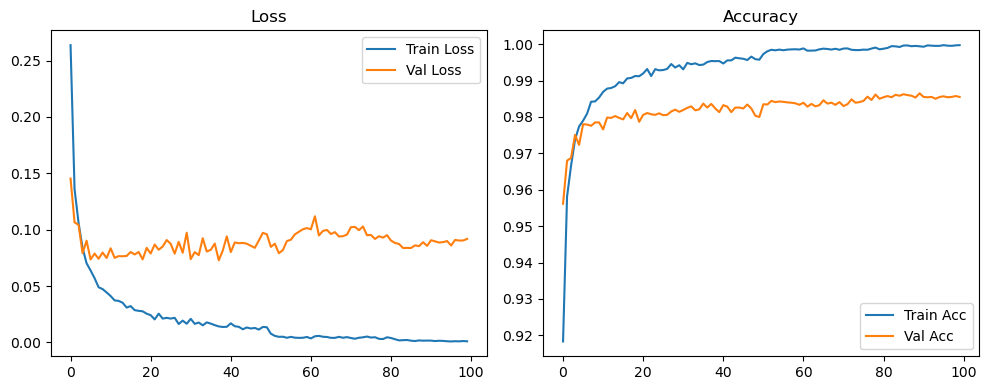

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3758, Acc: 0.8845 | Val Loss: 0.1666, Acc: 0.9498


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2216, Acc: 0.9336 | Val Loss: 0.1212, Acc: 0.9634


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1762, Acc: 0.9467 | Val Loss: 0.1070, Acc: 0.9674


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1527, Acc: 0.9533 | Val Loss: 0.0958, Acc: 0.9710


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9581 | Val Loss: 0.0896, Acc: 0.9714


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9603 | Val Loss: 0.0893, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9632 | Val Loss: 0.0840, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9666 | Val Loss: 0.0803, Acc: 0.9761


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1063, Acc: 0.9674 | Val Loss: 0.0767, Acc: 0.9777


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9685 | Val Loss: 0.0789, Acc: 0.9776


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9700 | Val Loss: 0.0750, Acc: 0.9776


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9722 | Val Loss: 0.0726, Acc: 0.9789


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.0750, Acc: 0.9782


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9735 | Val Loss: 0.0752, Acc: 0.9771


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0837, Acc: 0.9744 | Val Loss: 0.0707, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9739 | Val Loss: 0.0719, Acc: 0.9795


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9755 | Val Loss: 0.0701, Acc: 0.9805


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9750 | Val Loss: 0.0737, Acc: 0.9790


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9769 | Val Loss: 0.0702, Acc: 0.9798


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9781 | Val Loss: 0.0710, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9769 | Val Loss: 0.0710, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9782 | Val Loss: 0.0669, Acc: 0.9821


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9796 | Val Loss: 0.0719, Acc: 0.9793


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9788 | Val Loss: 0.0654, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9806 | Val Loss: 0.0752, Acc: 0.9799


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9804 | Val Loss: 0.0662, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9806 | Val Loss: 0.0675, Acc: 0.9817


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.0667, Acc: 0.9798


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9825 | Val Loss: 0.0698, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9808 | Val Loss: 0.0645, Acc: 0.9826


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9833 | Val Loss: 0.0686, Acc: 0.9822


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9820 | Val Loss: 0.0680, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9829 | Val Loss: 0.0656, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.0721, Acc: 0.9826


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9838 | Val Loss: 0.0718, Acc: 0.9807


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 0.0685, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9840 | Val Loss: 0.0734, Acc: 0.9818


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9840 | Val Loss: 0.0737, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9845 | Val Loss: 0.0736, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0690, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9842 | Val Loss: 0.0681, Acc: 0.9823


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.0782, Acc: 0.9816


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.0712, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.0754, Acc: 0.9807


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9873 | Val Loss: 0.0704, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9860 | Val Loss: 0.0766, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.0729, Acc: 0.9824


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9855 | Val Loss: 0.0695, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9857 | Val Loss: 0.0679, Acc: 0.9825


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.0703, Acc: 0.9816


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0678, Acc: 0.9845


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9899 | Val Loss: 0.0682, Acc: 0.9842


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.0659, Acc: 0.9844


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9912 | Val Loss: 0.0707, Acc: 0.9834


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0702, Acc: 0.9834


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0688, Acc: 0.9834


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9916 | Val Loss: 0.0711, Acc: 0.9833


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0709, Acc: 0.9836


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9914 | Val Loss: 0.0726, Acc: 0.9842


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0714, Acc: 0.9835


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.0732, Acc: 0.9837


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9919 | Val Loss: 0.0711, Acc: 0.9835


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0750, Acc: 0.9826


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9927 | Val Loss: 0.0719, Acc: 0.9834


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0727, Acc: 0.9839


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9931 | Val Loss: 0.0713, Acc: 0.9842


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9922 | Val Loss: 0.0726, Acc: 0.9843


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.0738, Acc: 0.9844


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9924 | Val Loss: 0.0748, Acc: 0.9835


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.0740, Acc: 0.9847


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0751, Acc: 0.9845


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0707, Acc: 0.9846


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0783, Acc: 0.9832


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9926 | Val Loss: 0.0716, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0700, Acc: 0.9842


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.0753, Acc: 0.9837


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0725, Acc: 0.9841


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9925 | Val Loss: 0.0772, Acc: 0.9813


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9934 | Val Loss: 0.0775, Acc: 0.9836


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0748, Acc: 0.9835


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0724, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.0728, Acc: 0.9842


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0745, Acc: 0.9838


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0737, Acc: 0.9846


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0730, Acc: 0.9842


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0738, Acc: 0.9842


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0724, Acc: 0.9849


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0732, Acc: 0.9846


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0730, Acc: 0.9844


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0730, Acc: 0.9844


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0728, Acc: 0.9847


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.0732, Acc: 0.9848


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9958 | Val Loss: 0.0703, Acc: 0.9858


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0712, Acc: 0.9850


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0728, Acc: 0.9845


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0716, Acc: 0.9849


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9953 | Val Loss: 0.0728, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0737, Acc: 0.9851


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0738, Acc: 0.9852


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0743, Acc: 0.9848


Final Test Loss: 0.0658 Accuracy: 0.9856


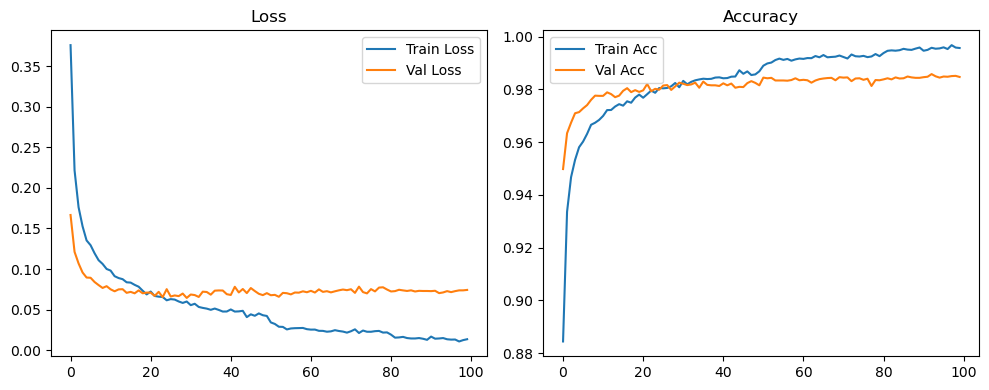

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2284, Acc: 0.9292 | Val Loss: 0.1459, Acc: 0.9547


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1094, Acc: 0.9661 | Val Loss: 0.1081, Acc: 0.9665


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9746 | Val Loss: 0.0933, Acc: 0.9709


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0609, Acc: 0.9800 | Val Loss: 0.0859, Acc: 0.9736


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9846 | Val Loss: 0.0930, Acc: 0.9732


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9870 | Val Loss: 0.0857, Acc: 0.9759


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9879 | Val Loss: 0.0875, Acc: 0.9762


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9895 | Val Loss: 0.0774, Acc: 0.9781


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.0860, Acc: 0.9781


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0896, Acc: 0.9764


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0903, Acc: 0.9779


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.0858, Acc: 0.9802


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0918, Acc: 0.9791


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0923, Acc: 0.9788


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1022, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0903, Acc: 0.9798


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0835, Acc: 0.9817


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1010, Acc: 0.9780


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.0976, Acc: 0.9772


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.1071, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9963 | Val Loss: 0.1115, Acc: 0.9767


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0940, Acc: 0.9806


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0968, Acc: 0.9808


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.0801, Acc: 0.9818


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0828, Acc: 0.9818


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0976, Acc: 0.9792


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1342, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0996, Acc: 0.9801


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0996, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1193, Acc: 0.9756


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0973, Acc: 0.9804


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.1005, Acc: 0.9806


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1016, Acc: 0.9809


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1048, Acc: 0.9813


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0986, Acc: 0.9828


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1001, Acc: 0.9809


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1187, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1181, Acc: 0.9792


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1090, Acc: 0.9821


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1045, Acc: 0.9807


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0957, Acc: 0.9825


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.0973, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0930, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1053, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0960, Acc: 0.9825


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.0927, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1048, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0962, Acc: 0.9839


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1070, Acc: 0.9827


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1272, Acc: 0.9808


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0941, Acc: 0.9834


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0968, Acc: 0.9845


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0967, Acc: 0.9842


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0969, Acc: 0.9843


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0966, Acc: 0.9846


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0976, Acc: 0.9845


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1000, Acc: 0.9851


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0977, Acc: 0.9851


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1012, Acc: 0.9847


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1022, Acc: 0.9858


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1069, Acc: 0.9856


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1084, Acc: 0.9853


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1095, Acc: 0.9863


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1091, Acc: 0.9854


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1174, Acc: 0.9847


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1138, Acc: 0.9850


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1150, Acc: 0.9859


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1142, Acc: 0.9858


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1162, Acc: 0.9858


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1221, Acc: 0.9852


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1240, Acc: 0.9854


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1264, Acc: 0.9845


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1269, Acc: 0.9851


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1282, Acc: 0.9851


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1283, Acc: 0.9848


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1303, Acc: 0.9842


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1239, Acc: 0.9844


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1270, Acc: 0.9843


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1308, Acc: 0.9845


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1265, Acc: 0.9851


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1288, Acc: 0.9852


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1289, Acc: 0.9849


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1312, Acc: 0.9843


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1290, Acc: 0.9849


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1282, Acc: 0.9850


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1280, Acc: 0.9854


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1367, Acc: 0.9847


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1312, Acc: 0.9851


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1316, Acc: 0.9845


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1335, Acc: 0.9842


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1392, Acc: 0.9839


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1363, Acc: 0.9849


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1365, Acc: 0.9848


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1389, Acc: 0.9842


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1385, Acc: 0.9847


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1338, Acc: 0.9851


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1355, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1330, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1354, Acc: 0.9847


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1345, Acc: 0.9850


Final Test Loss: 0.1115 Accuracy: 0.9864


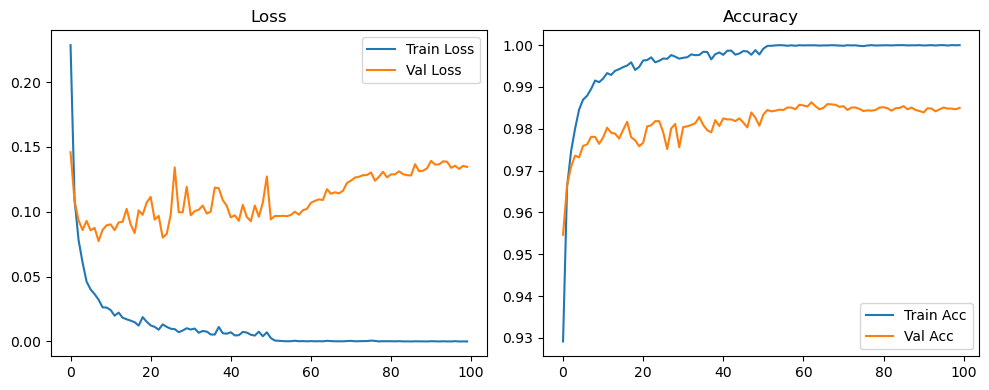

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2637, Acc: 0.9183 | Val Loss: 0.1454, Acc: 0.9562


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1360, Acc: 0.9581 | Val Loss: 0.1065, Acc: 0.9680


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1061, Acc: 0.9666 | Val Loss: 0.1044, Acc: 0.9688


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0839, Acc: 0.9738 | Val Loss: 0.0792, Acc: 0.9751


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0703, Acc: 0.9774 | Val Loss: 0.0903, Acc: 0.9723


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0639, Acc: 0.9790 | Val Loss: 0.0736, Acc: 0.9780


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9809 | Val Loss: 0.0789, Acc: 0.9779


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0490, Acc: 0.9842 | Val Loss: 0.0743, Acc: 0.9776


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9843 | Val Loss: 0.0798, Acc: 0.9785


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0444, Acc: 0.9854 | Val Loss: 0.0749, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9869 | Val Loss: 0.0835, Acc: 0.9766


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9878 | Val Loss: 0.0751, Acc: 0.9798


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.0766, Acc: 0.9798


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0765, Acc: 0.9802


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0310, Acc: 0.9896 | Val Loss: 0.0768, Acc: 0.9798


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9892 | Val Loss: 0.0803, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9906 | Val Loss: 0.0781, Acc: 0.9811


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9907 | Val Loss: 0.0802, Acc: 0.9797


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9912 | Val Loss: 0.0737, Acc: 0.9819


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9912 | Val Loss: 0.0839, Acc: 0.9787


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0789, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0869, Acc: 0.9811


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.0823, Acc: 0.9808


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0851, Acc: 0.9806


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0909, Acc: 0.9810


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0875, Acc: 0.9805


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9932 | Val Loss: 0.0788, Acc: 0.9806


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0892, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0796, Acc: 0.9820


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.0974, Acc: 0.9814


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0740, Acc: 0.9819


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0802, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9945 | Val Loss: 0.0775, Acc: 0.9829


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9947 | Val Loss: 0.0925, Acc: 0.9818


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0807, Acc: 0.9821


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0822, Acc: 0.9837


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0877, Acc: 0.9826


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0729, Acc: 0.9836


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0815, Acc: 0.9823


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0941, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9947 | Val Loss: 0.0802, Acc: 0.9832


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0887, Acc: 0.9828


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0880, Acc: 0.9813


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0883, Acc: 0.9826


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9961 | Val Loss: 0.0876, Acc: 0.9826


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0858, Acc: 0.9823


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0839, Acc: 0.9834


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0904, Acc: 0.9823


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.0972, Acc: 0.9803


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0960, Acc: 0.9800


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0810, Acc: 0.9838


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0811, Acc: 0.9842


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0799, Acc: 0.9834


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0793, Acc: 0.9839


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0808, Acc: 0.9845


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0797, Acc: 0.9841


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0836, Acc: 0.9837


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0856, Acc: 0.9847


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0843, Acc: 0.9855


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0900, Acc: 0.9848


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0877, Acc: 0.9847


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0890, Acc: 0.9849


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0883, Acc: 0.9850


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0849, Acc: 0.9848


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0852, Acc: 0.9852


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0906, Acc: 0.9844


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0896, Acc: 0.9850


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0927, Acc: 0.9852


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0927, Acc: 0.9843


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0929, Acc: 0.9850


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0965, Acc: 0.9852


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0964, Acc: 0.9856


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0968, Acc: 0.9852


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0941, Acc: 0.9855


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0932, Acc: 0.9852


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0967, Acc: 0.9850


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0974, Acc: 0.9849


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0969, Acc: 0.9853


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0926, Acc: 0.9852


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0952, Acc: 0.9848


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0946, Acc: 0.9852


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0944, Acc: 0.9855


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0940, Acc: 0.9855


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0910, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0926, Acc: 0.9860


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.0907, Acc: 0.9866


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0932, Acc: 0.9855


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0950, Acc: 0.9849


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0979, Acc: 0.9852


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0945, Acc: 0.9858


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0969, Acc: 0.9856


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0970, Acc: 0.9848


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0933, Acc: 0.9854


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0933, Acc: 0.9855


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.0914, Acc: 0.9849


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0895, Acc: 0.9854


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0949, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0983, Acc: 0.9852


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0926, Acc: 0.9862


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0942, Acc: 0.9860


Final Test Loss: 0.0937 Accuracy: 0.9862


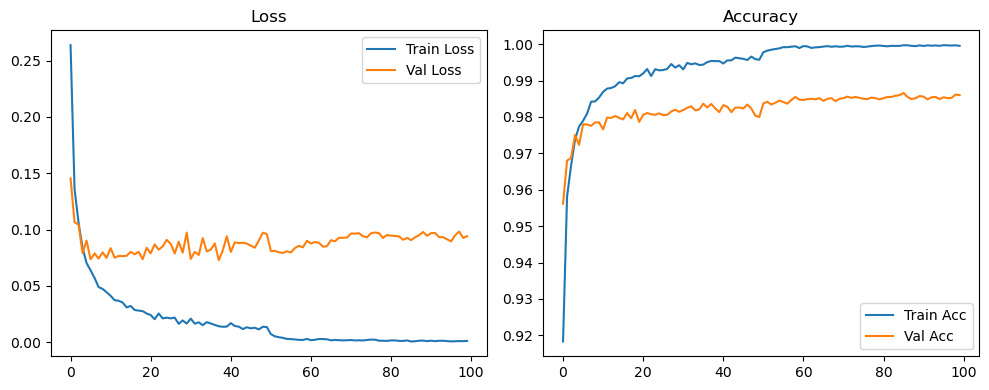

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3758, Acc: 0.8845 | Val Loss: 0.1666, Acc: 0.9498


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2216, Acc: 0.9336 | Val Loss: 0.1212, Acc: 0.9634


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1762, Acc: 0.9467 | Val Loss: 0.1070, Acc: 0.9674


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1527, Acc: 0.9533 | Val Loss: 0.0958, Acc: 0.9710


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1353, Acc: 0.9581 | Val Loss: 0.0896, Acc: 0.9714


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1294, Acc: 0.9603 | Val Loss: 0.0893, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9632 | Val Loss: 0.0840, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1109, Acc: 0.9666 | Val Loss: 0.0803, Acc: 0.9761


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1063, Acc: 0.9674 | Val Loss: 0.0767, Acc: 0.9777


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1001, Acc: 0.9685 | Val Loss: 0.0789, Acc: 0.9776


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0981, Acc: 0.9700 | Val Loss: 0.0750, Acc: 0.9776


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9722 | Val Loss: 0.0726, Acc: 0.9789


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0889, Acc: 0.9722 | Val Loss: 0.0750, Acc: 0.9782


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0875, Acc: 0.9735 | Val Loss: 0.0752, Acc: 0.9771


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0837, Acc: 0.9744 | Val Loss: 0.0707, Acc: 0.9777


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0833, Acc: 0.9739 | Val Loss: 0.0719, Acc: 0.9795


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9755 | Val Loss: 0.0701, Acc: 0.9805


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0782, Acc: 0.9750 | Val Loss: 0.0737, Acc: 0.9790


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9769 | Val Loss: 0.0702, Acc: 0.9798


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0688, Acc: 0.9781 | Val Loss: 0.0710, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9769 | Val Loss: 0.0710, Acc: 0.9797


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0668, Acc: 0.9782 | Val Loss: 0.0669, Acc: 0.9821


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9796 | Val Loss: 0.0719, Acc: 0.9793


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0656, Acc: 0.9788 | Val Loss: 0.0654, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9806 | Val Loss: 0.0752, Acc: 0.9799


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9804 | Val Loss: 0.0662, Acc: 0.9815


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0624, Acc: 0.9806 | Val Loss: 0.0675, Acc: 0.9817


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9812 | Val Loss: 0.0667, Acc: 0.9798


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0583, Acc: 0.9825 | Val Loss: 0.0698, Acc: 0.9812


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9808 | Val Loss: 0.0645, Acc: 0.9826


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9833 | Val Loss: 0.0686, Acc: 0.9822


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9820 | Val Loss: 0.0680, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9829 | Val Loss: 0.0656, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0522, Acc: 0.9835 | Val Loss: 0.0721, Acc: 0.9826


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9838 | Val Loss: 0.0718, Acc: 0.9807


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 0.0685, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9840 | Val Loss: 0.0734, Acc: 0.9818


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9840 | Val Loss: 0.0737, Acc: 0.9816


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9845 | Val Loss: 0.0736, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0690, Acc: 0.9813


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9842 | Val Loss: 0.0681, Acc: 0.9823


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.0782, Acc: 0.9816


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.0712, Acc: 0.9822


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9849 | Val Loss: 0.0754, Acc: 0.9807


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0408, Acc: 0.9873 | Val Loss: 0.0704, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9860 | Val Loss: 0.0766, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.0729, Acc: 0.9824


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9855 | Val Loss: 0.0695, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0431, Acc: 0.9857 | Val Loss: 0.0679, Acc: 0.9825


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.0703, Acc: 0.9816


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.0655, Acc: 0.9837


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9902 | Val Loss: 0.0670, Acc: 0.9837


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0655, Acc: 0.9845


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.0672, Acc: 0.9839


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0675, Acc: 0.9834


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0672, Acc: 0.9838


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.0685, Acc: 0.9842


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9923 | Val Loss: 0.0673, Acc: 0.9846


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9923 | Val Loss: 0.0698, Acc: 0.9844


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9927 | Val Loss: 0.0699, Acc: 0.9837


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.0694, Acc: 0.9848


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9937 | Val Loss: 0.0690, Acc: 0.9850


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.0707, Acc: 0.9837


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9940 | Val Loss: 0.0713, Acc: 0.9842


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.0702, Acc: 0.9842


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9943 | Val Loss: 0.0698, Acc: 0.9838


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0682, Acc: 0.9841


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0696, Acc: 0.9850


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.0689, Acc: 0.9845


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.0693, Acc: 0.9853


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0731, Acc: 0.9845


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9943 | Val Loss: 0.0720, Acc: 0.9848


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9949 | Val Loss: 0.0721, Acc: 0.9842


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0707, Acc: 0.9845


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0711, Acc: 0.9849


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.0734, Acc: 0.9842


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0702, Acc: 0.9846


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0729, Acc: 0.9841


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.0720, Acc: 0.9843


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.0718, Acc: 0.9844


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0716, Acc: 0.9843


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0717, Acc: 0.9850


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0733, Acc: 0.9849


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0733, Acc: 0.9845


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0721, Acc: 0.9841


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.0720, Acc: 0.9846


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0710, Acc: 0.9851


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.0730, Acc: 0.9844


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0725, Acc: 0.9849


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0729, Acc: 0.9852


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0737, Acc: 0.9847


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0732, Acc: 0.9846


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9960 | Val Loss: 0.0703, Acc: 0.9855


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0720, Acc: 0.9854


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0730, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.0719, Acc: 0.9850


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9950 | Val Loss: 0.0730, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0744, Acc: 0.9844


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0739, Acc: 0.9844


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.0739, Acc: 0.9848


Final Test Loss: 0.0647 Accuracy: 0.9857


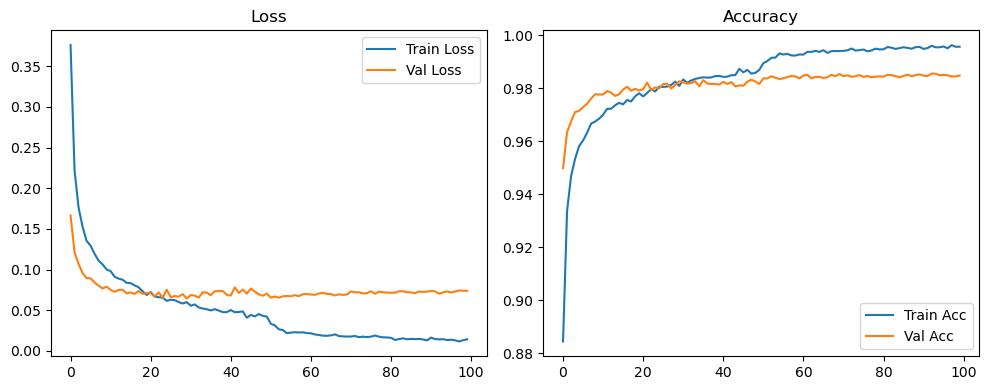

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2186, Acc: 0.9324 | Val Loss: 0.1405, Acc: 0.9563


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1059, Acc: 0.9675 | Val Loss: 0.1061, Acc: 0.9669


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9763 | Val Loss: 0.0984, Acc: 0.9700


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9809 | Val Loss: 0.0879, Acc: 0.9727


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9853 | Val Loss: 0.0903, Acc: 0.9739


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9874 | Val Loss: 0.0910, Acc: 0.9760


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9886 | Val Loss: 0.0889, Acc: 0.9756


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0919, Acc: 0.9758


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0864, Acc: 0.9773


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0875, Acc: 0.9794


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0847, Acc: 0.9781


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0842, Acc: 0.9805


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9942 | Val Loss: 0.0826, Acc: 0.9792


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.0939, Acc: 0.9787


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.1009, Acc: 0.9779


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0987, Acc: 0.9792


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0980, Acc: 0.9813


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.1075, Acc: 0.9767


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0962, Acc: 0.9782


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0838, Acc: 0.9808


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0927, Acc: 0.9799


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1066, Acc: 0.9778


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0912, Acc: 0.9808


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1029, Acc: 0.9797


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0908, Acc: 0.9815


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0977, Acc: 0.9812


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0897, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0998, Acc: 0.9781


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0962, Acc: 0.9808


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0990, Acc: 0.9794


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0996, Acc: 0.9788


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0824, Acc: 0.9828


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0856, Acc: 0.9822


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0979, Acc: 0.9818


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0991, Acc: 0.9798


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1169, Acc: 0.9791


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0944, Acc: 0.9812


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1042, Acc: 0.9803


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0952, Acc: 0.9821


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1039, Acc: 0.9827


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1029, Acc: 0.9811


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1016, Acc: 0.9818


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1027, Acc: 0.9825


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1116, Acc: 0.9805


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1042, Acc: 0.9809


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1088, Acc: 0.9805


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1132, Acc: 0.9808


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1056, Acc: 0.9827


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1290, Acc: 0.9824


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1108, Acc: 0.9810


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1100, Acc: 0.9812


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1121, Acc: 0.9806


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1020, Acc: 0.9820


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0969, Acc: 0.9835


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1009, Acc: 0.9825


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1135, Acc: 0.9818


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1027, Acc: 0.9816


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1067, Acc: 0.9799


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1215, Acc: 0.9818


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1053, Acc: 0.9832


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0982, Acc: 0.9838


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1102, Acc: 0.9814


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1122, Acc: 0.9807


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0968, Acc: 0.9837


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1004, Acc: 0.9828


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1101, Acc: 0.9824


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1123, Acc: 0.9802


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1091, Acc: 0.9821


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1125, Acc: 0.9827


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1119, Acc: 0.9818


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1174, Acc: 0.9808


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1195, Acc: 0.9811


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1139, Acc: 0.9824


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1095, Acc: 0.9832


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1121, Acc: 0.9830


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1050, Acc: 0.9835


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1022, Acc: 0.9841


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9986 | Val Loss: 0.1046, Acc: 0.9818


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1020, Acc: 0.9828


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1138, Acc: 0.9819


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1136, Acc: 0.9838


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1106, Acc: 0.9820


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1171, Acc: 0.9818


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1079, Acc: 0.9822


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1118, Acc: 0.9810


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1090, Acc: 0.9824


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0998, Acc: 0.9838


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.1100, Acc: 0.9828


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1062, Acc: 0.9833


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1032, Acc: 0.9836


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1226, Acc: 0.9814


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1280, Acc: 0.9807


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1086, Acc: 0.9812


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1157, Acc: 0.9818


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1051, Acc: 0.9832


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1096, Acc: 0.9828


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1222, Acc: 0.9814


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1061, Acc: 0.9834


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1138, Acc: 0.9825


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1147, Acc: 0.9830


Final Test Loss: 0.1124 Accuracy: 0.9821


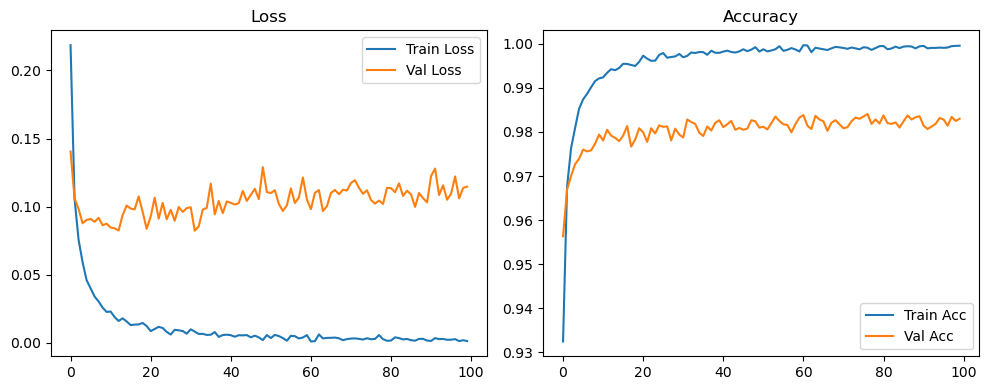

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2539, Acc: 0.9210 | Val Loss: 0.1501, Acc: 0.9533


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1350, Acc: 0.9589 | Val Loss: 0.1039, Acc: 0.9696


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1050, Acc: 0.9676 | Val Loss: 0.0994, Acc: 0.9688


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0821, Acc: 0.9740 | Val Loss: 0.0799, Acc: 0.9752


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0696, Acc: 0.9775 | Val Loss: 0.0797, Acc: 0.9753


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9790 | Val Loss: 0.0716, Acc: 0.9788


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9828 | Val Loss: 0.0740, Acc: 0.9784


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9840 | Val Loss: 0.0776, Acc: 0.9775


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9855 | Val Loss: 0.0758, Acc: 0.9784


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9866 | Val Loss: 0.0929, Acc: 0.9743


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9875 | Val Loss: 0.0783, Acc: 0.9786


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9876 | Val Loss: 0.0727, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.0703, Acc: 0.9806


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.0844, Acc: 0.9791


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.0768, Acc: 0.9808


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9906 | Val Loss: 0.0797, Acc: 0.9800


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0750, Acc: 0.9814


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9908 | Val Loss: 0.0709, Acc: 0.9809


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9911 | Val Loss: 0.0765, Acc: 0.9793


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0778, Acc: 0.9817


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0739, Acc: 0.9820


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.0747, Acc: 0.9823


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0801, Acc: 0.9795


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.0724, Acc: 0.9825


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.0824, Acc: 0.9802


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.0824, Acc: 0.9809


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0802, Acc: 0.9811


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0870, Acc: 0.9807


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9940 | Val Loss: 0.0825, Acc: 0.9812


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9941 | Val Loss: 0.0835, Acc: 0.9805


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0880, Acc: 0.9803


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0808, Acc: 0.9826


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0833, Acc: 0.9828


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0791, Acc: 0.9828


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0814, Acc: 0.9821


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0842, Acc: 0.9812


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0844, Acc: 0.9813


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0880, Acc: 0.9815


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0903, Acc: 0.9816


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0838, Acc: 0.9828


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9957 | Val Loss: 0.0863, Acc: 0.9832


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0783, Acc: 0.9842


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0883, Acc: 0.9821


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0882, Acc: 0.9823


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0930, Acc: 0.9819


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0841, Acc: 0.9833


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0836, Acc: 0.9819


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0923, Acc: 0.9815


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0923, Acc: 0.9819


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0827, Acc: 0.9836


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0788, Acc: 0.9822


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0883, Acc: 0.9820


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0828, Acc: 0.9836


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0881, Acc: 0.9824


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0829, Acc: 0.9834


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0818, Acc: 0.9829


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0900, Acc: 0.9827


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0977, Acc: 0.9826


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0945, Acc: 0.9815


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0899, Acc: 0.9830


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0878, Acc: 0.9836


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0923, Acc: 0.9830


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0959, Acc: 0.9825


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0913, Acc: 0.9828


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.0926, Acc: 0.9835


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0967, Acc: 0.9838


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0921, Acc: 0.9828


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1014, Acc: 0.9828


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1095, Acc: 0.9812


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0965, Acc: 0.9835


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0944, Acc: 0.9832


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1058, Acc: 0.9818


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.0893, Acc: 0.9828


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9974 | Val Loss: 0.1016, Acc: 0.9825


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0910, Acc: 0.9836


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0951, Acc: 0.9822


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0936, Acc: 0.9849


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1060, Acc: 0.9823


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0914, Acc: 0.9841


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0952, Acc: 0.9826


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1013, Acc: 0.9836


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0926, Acc: 0.9838


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1016, Acc: 0.9829


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9973 | Val Loss: 0.0936, Acc: 0.9833


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0895, Acc: 0.9840


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0947, Acc: 0.9842


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0989, Acc: 0.9832


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0881, Acc: 0.9828


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0899, Acc: 0.9838


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0855, Acc: 0.9840


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0944, Acc: 0.9832


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0949, Acc: 0.9838


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0927, Acc: 0.9838


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0906, Acc: 0.9845


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0951, Acc: 0.9832


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1007, Acc: 0.9830


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1017, Acc: 0.9828


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0938, Acc: 0.9832


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0907, Acc: 0.9828


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0986, Acc: 0.9827


Final Test Loss: 0.0812 Accuracy: 0.9848


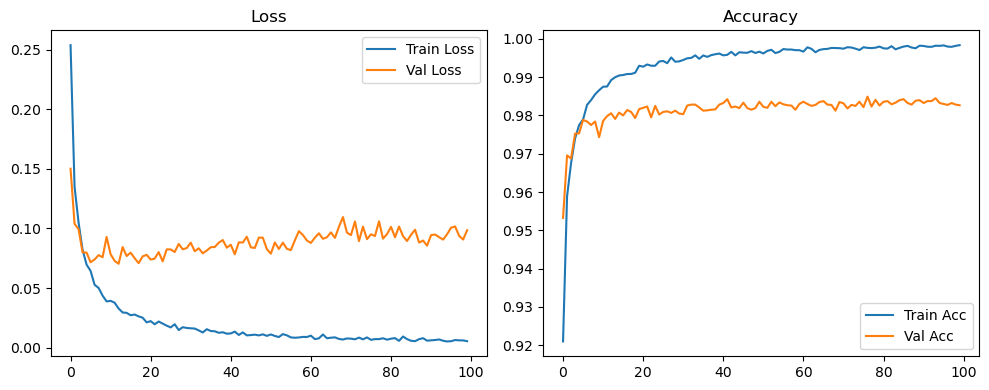

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3674, Acc: 0.8884 | Val Loss: 0.1718, Acc: 0.9478


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2177, Acc: 0.9338 | Val Loss: 0.1265, Acc: 0.9620


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1720, Acc: 0.9481 | Val Loss: 0.1116, Acc: 0.9660


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1527, Acc: 0.9544 | Val Loss: 0.1004, Acc: 0.9704


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1354, Acc: 0.9595 | Val Loss: 0.0983, Acc: 0.9708


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1272, Acc: 0.9605 | Val Loss: 0.0870, Acc: 0.9748


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1151, Acc: 0.9644 | Val Loss: 0.0796, Acc: 0.9767


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1074, Acc: 0.9667 | Val Loss: 0.0809, Acc: 0.9761


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1029, Acc: 0.9687 | Val Loss: 0.0796, Acc: 0.9771


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0973, Acc: 0.9695 | Val Loss: 0.0781, Acc: 0.9772


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0940, Acc: 0.9707 | Val Loss: 0.0794, Acc: 0.9770


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0869, Acc: 0.9726 | Val Loss: 0.0756, Acc: 0.9772


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9740 | Val Loss: 0.0781, Acc: 0.9780


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0830, Acc: 0.9741 | Val Loss: 0.0748, Acc: 0.9775


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0773, Acc: 0.9753 | Val Loss: 0.0715, Acc: 0.9778


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0766, Acc: 0.9759 | Val Loss: 0.0728, Acc: 0.9798


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0748, Acc: 0.9760 | Val Loss: 0.0691, Acc: 0.9797


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9782 | Val Loss: 0.0761, Acc: 0.9787


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9781 | Val Loss: 0.0729, Acc: 0.9792


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0671, Acc: 0.9785 | Val Loss: 0.0703, Acc: 0.9789


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0647, Acc: 0.9796 | Val Loss: 0.0723, Acc: 0.9802


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0633, Acc: 0.9794 | Val Loss: 0.0669, Acc: 0.9797


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9799 | Val Loss: 0.0715, Acc: 0.9794


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9809 | Val Loss: 0.0686, Acc: 0.9818


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9825 | Val Loss: 0.0645, Acc: 0.9812


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9825 | Val Loss: 0.0676, Acc: 0.9818


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9817 | Val Loss: 0.0672, Acc: 0.9814


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9825 | Val Loss: 0.0701, Acc: 0.9801


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9825 | Val Loss: 0.0707, Acc: 0.9816


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9840 | Val Loss: 0.0701, Acc: 0.9812


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9830 | Val Loss: 0.0673, Acc: 0.9812


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9835 | Val Loss: 0.0684, Acc: 0.9812


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9850 | Val Loss: 0.0656, Acc: 0.9822


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9833 | Val Loss: 0.0711, Acc: 0.9816


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9852 | Val Loss: 0.0672, Acc: 0.9826


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9843 | Val Loss: 0.0676, Acc: 0.9826


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9853 | Val Loss: 0.0699, Acc: 0.9819


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9860 | Val Loss: 0.0728, Acc: 0.9811


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9851 | Val Loss: 0.0700, Acc: 0.9813


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9861 | Val Loss: 0.0705, Acc: 0.9809


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9852 | Val Loss: 0.0662, Acc: 0.9822


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9870 | Val Loss: 0.0647, Acc: 0.9827


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9871 | Val Loss: 0.0735, Acc: 0.9812


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.0703, Acc: 0.9812


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.0677, Acc: 0.9815


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9877 | Val Loss: 0.0735, Acc: 0.9818


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.0706, Acc: 0.9812


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9871 | Val Loss: 0.0730, Acc: 0.9818


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9872 | Val Loss: 0.0753, Acc: 0.9799


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9883 | Val Loss: 0.0729, Acc: 0.9815


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9883 | Val Loss: 0.0757, Acc: 0.9808


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.0703, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9881 | Val Loss: 0.0687, Acc: 0.9813


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0368, Acc: 0.9880 | Val Loss: 0.0704, Acc: 0.9813


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9888 | Val Loss: 0.0735, Acc: 0.9808


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9894 | Val Loss: 0.0742, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0739, Acc: 0.9822


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.0694, Acc: 0.9823


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9891 | Val Loss: 0.0737, Acc: 0.9818


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9893 | Val Loss: 0.0708, Acc: 0.9822


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.0708, Acc: 0.9824


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9891 | Val Loss: 0.0708, Acc: 0.9823


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.0729, Acc: 0.9824


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9904 | Val Loss: 0.0753, Acc: 0.9817


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0729, Acc: 0.9821


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9899 | Val Loss: 0.0682, Acc: 0.9832


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9900 | Val Loss: 0.0680, Acc: 0.9829


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.0713, Acc: 0.9818


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0705, Acc: 0.9831


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0738, Acc: 0.9829


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0715, Acc: 0.9828


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9905 | Val Loss: 0.0746, Acc: 0.9825


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.0718, Acc: 0.9829


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9905 | Val Loss: 0.0692, Acc: 0.9828


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9904 | Val Loss: 0.0693, Acc: 0.9826


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.0737, Acc: 0.9834


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0698, Acc: 0.9834


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.0669, Acc: 0.9833


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9909 | Val Loss: 0.0679, Acc: 0.9829


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.0685, Acc: 0.9830


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0733, Acc: 0.9818


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0691, Acc: 0.9832


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9912 | Val Loss: 0.0718, Acc: 0.9843


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.0717, Acc: 0.9836


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9917 | Val Loss: 0.0718, Acc: 0.9835


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9917 | Val Loss: 0.0741, Acc: 0.9828


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9907 | Val Loss: 0.0692, Acc: 0.9838


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.0712, Acc: 0.9832


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0759, Acc: 0.9828


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0744, Acc: 0.9839


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.0714, Acc: 0.9835


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0734, Acc: 0.9832


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.0695, Acc: 0.9842


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9928 | Val Loss: 0.0761, Acc: 0.9835


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9926 | Val Loss: 0.0748, Acc: 0.9832


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0708, Acc: 0.9837


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.0781, Acc: 0.9832


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.0769, Acc: 0.9829


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.0773, Acc: 0.9828


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0740, Acc: 0.9838


Final Test Loss: 0.0683 Accuracy: 0.9842


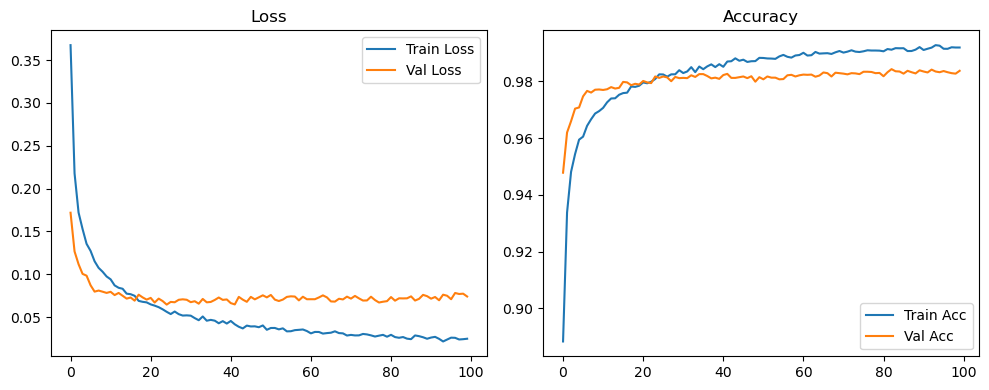

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2186, Acc: 0.9324 | Val Loss: 0.1405, Acc: 0.9563


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1059, Acc: 0.9675 | Val Loss: 0.1061, Acc: 0.9669


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0757, Acc: 0.9763 | Val Loss: 0.0984, Acc: 0.9700


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9809 | Val Loss: 0.0879, Acc: 0.9727


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9853 | Val Loss: 0.0903, Acc: 0.9739


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9874 | Val Loss: 0.0910, Acc: 0.9760


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9886 | Val Loss: 0.0889, Acc: 0.9756


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0919, Acc: 0.9758


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0864, Acc: 0.9773


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.0875, Acc: 0.9794


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0847, Acc: 0.9781


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0842, Acc: 0.9805


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9942 | Val Loss: 0.0826, Acc: 0.9792


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.0939, Acc: 0.9787


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.1009, Acc: 0.9779


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0987, Acc: 0.9792


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0980, Acc: 0.9813


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.1075, Acc: 0.9767


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.0962, Acc: 0.9782


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0838, Acc: 0.9808


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0927, Acc: 0.9799


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1066, Acc: 0.9778


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0912, Acc: 0.9808


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1029, Acc: 0.9797


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0908, Acc: 0.9815


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0977, Acc: 0.9812


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0897, Acc: 0.9812


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0998, Acc: 0.9781


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0962, Acc: 0.9808


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0990, Acc: 0.9794


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0996, Acc: 0.9788


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0824, Acc: 0.9828


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0856, Acc: 0.9822


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0979, Acc: 0.9818


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0991, Acc: 0.9798


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1169, Acc: 0.9791


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0944, Acc: 0.9812


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1042, Acc: 0.9803


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0952, Acc: 0.9821


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1039, Acc: 0.9827


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1029, Acc: 0.9811


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1016, Acc: 0.9818


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1027, Acc: 0.9825


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1116, Acc: 0.9805


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1042, Acc: 0.9809


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1088, Acc: 0.9805


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1132, Acc: 0.9808


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1056, Acc: 0.9827


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1290, Acc: 0.9824


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1108, Acc: 0.9810


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0981, Acc: 0.9828


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0983, Acc: 0.9841


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0957, Acc: 0.9840


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0971, Acc: 0.9842


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0964, Acc: 0.9841


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0981, Acc: 0.9849


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1004, Acc: 0.9850


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1070, Acc: 0.9845


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1070, Acc: 0.9840


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1032, Acc: 0.9842


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1071, Acc: 0.9834


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1133, Acc: 0.9844


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1086, Acc: 0.9848


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1138, Acc: 0.9838


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1196, Acc: 0.9821


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1127, Acc: 0.9823


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1141, Acc: 0.9827


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1111, Acc: 0.9837


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1114, Acc: 0.9838


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1117, Acc: 0.9836


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1218, Acc: 0.9831


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1257, Acc: 0.9825


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9997 | Val Loss: 0.1250, Acc: 0.9832


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1182, Acc: 0.9847


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1105, Acc: 0.9842


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1084, Acc: 0.9846


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1052, Acc: 0.9846


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1104, Acc: 0.9839


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1191, Acc: 0.9837


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1101, Acc: 0.9846


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1075, Acc: 0.9846


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1051, Acc: 0.9847


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1095, Acc: 0.9851


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1081, Acc: 0.9852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1116, Acc: 0.9849


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1088, Acc: 0.9853


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1095, Acc: 0.9849


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1138, Acc: 0.9851


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1147, Acc: 0.9848


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1119, Acc: 0.9842


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1203, Acc: 0.9846


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1209, Acc: 0.9845


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1150, Acc: 0.9843


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1145, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1190, Acc: 0.9851


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1185, Acc: 0.9843


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1216, Acc: 0.9849


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1178, Acc: 0.9852


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1194, Acc: 0.9852


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1238, Acc: 0.9842


Final Test Loss: 0.1202 Accuracy: 0.9851


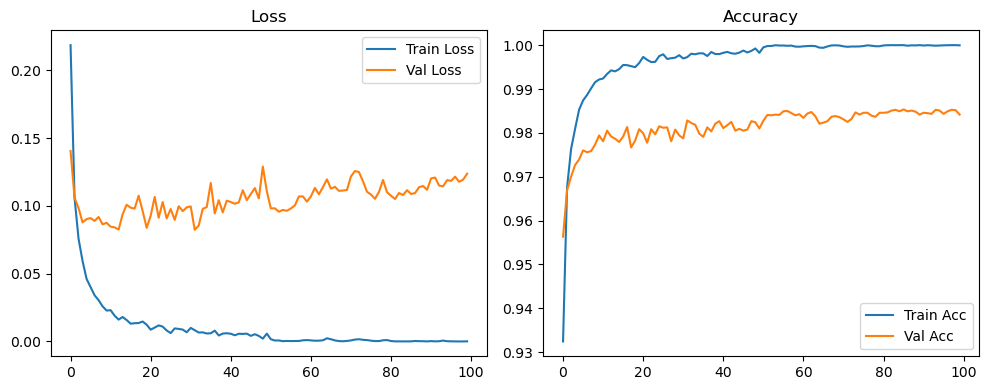

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2539, Acc: 0.9210 | Val Loss: 0.1501, Acc: 0.9533


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1350, Acc: 0.9589 | Val Loss: 0.1039, Acc: 0.9696


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1050, Acc: 0.9676 | Val Loss: 0.0994, Acc: 0.9688


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0821, Acc: 0.9740 | Val Loss: 0.0799, Acc: 0.9752


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0696, Acc: 0.9775 | Val Loss: 0.0797, Acc: 0.9753


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9790 | Val Loss: 0.0716, Acc: 0.9788


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0527, Acc: 0.9828 | Val Loss: 0.0740, Acc: 0.9784


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0501, Acc: 0.9840 | Val Loss: 0.0776, Acc: 0.9775


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0436, Acc: 0.9855 | Val Loss: 0.0758, Acc: 0.9784


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9866 | Val Loss: 0.0929, Acc: 0.9743


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9875 | Val Loss: 0.0783, Acc: 0.9786


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9876 | Val Loss: 0.0727, Acc: 0.9798


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9892 | Val Loss: 0.0703, Acc: 0.9806


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.0844, Acc: 0.9791


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9904 | Val Loss: 0.0768, Acc: 0.9808


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9906 | Val Loss: 0.0797, Acc: 0.9800


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.0750, Acc: 0.9814


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9908 | Val Loss: 0.0709, Acc: 0.9809


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9911 | Val Loss: 0.0765, Acc: 0.9793


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.0778, Acc: 0.9817


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0739, Acc: 0.9820


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.0747, Acc: 0.9823


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.0801, Acc: 0.9795


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.0724, Acc: 0.9825


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.0824, Acc: 0.9802


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.0824, Acc: 0.9809


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0802, Acc: 0.9811


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0870, Acc: 0.9807


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9940 | Val Loss: 0.0825, Acc: 0.9812


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9941 | Val Loss: 0.0835, Acc: 0.9805


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0880, Acc: 0.9803


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0808, Acc: 0.9826


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0833, Acc: 0.9828


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0791, Acc: 0.9828


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0814, Acc: 0.9821


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0842, Acc: 0.9812


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0844, Acc: 0.9813


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0880, Acc: 0.9815


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0903, Acc: 0.9816


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0838, Acc: 0.9828


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9957 | Val Loss: 0.0863, Acc: 0.9832


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0783, Acc: 0.9842


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0883, Acc: 0.9821


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0882, Acc: 0.9823


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0930, Acc: 0.9819


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0841, Acc: 0.9833


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0836, Acc: 0.9819


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0923, Acc: 0.9815


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0923, Acc: 0.9819


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0827, Acc: 0.9836


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0790, Acc: 0.9836


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0819, Acc: 0.9841


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0820, Acc: 0.9850


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0836, Acc: 0.9849


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0835, Acc: 0.9849


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0835, Acc: 0.9852


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0846, Acc: 0.9851


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0843, Acc: 0.9856


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0905, Acc: 0.9852


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0873, Acc: 0.9853


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0883, Acc: 0.9852


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0870, Acc: 0.9849


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0979, Acc: 0.9847


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.0969, Acc: 0.9829


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0911, Acc: 0.9847


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0917, Acc: 0.9842


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0981, Acc: 0.9832


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0952, Acc: 0.9834


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.0989, Acc: 0.9829


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0945, Acc: 0.9848


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0933, Acc: 0.9845


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0986, Acc: 0.9840


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0970, Acc: 0.9845


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0908, Acc: 0.9848


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0938, Acc: 0.9844


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0930, Acc: 0.9848


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9990 | Val Loss: 0.0981, Acc: 0.9843


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1036, Acc: 0.9847


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0991, Acc: 0.9844


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0977, Acc: 0.9849


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0957, Acc: 0.9850


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0957, Acc: 0.9844


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0987, Acc: 0.9841


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0940, Acc: 0.9857


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0969, Acc: 0.9847


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0972, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1003, Acc: 0.9857


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1005, Acc: 0.9860


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0993, Acc: 0.9857


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0936, Acc: 0.9862


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.0965, Acc: 0.9851


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0962, Acc: 0.9862


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0989, Acc: 0.9861


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0993, Acc: 0.9858


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1003, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0999, Acc: 0.9852


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1023, Acc: 0.9842


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1018, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1034, Acc: 0.9848


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1009, Acc: 0.9846


Final Test Loss: 0.0859 Accuracy: 0.9862


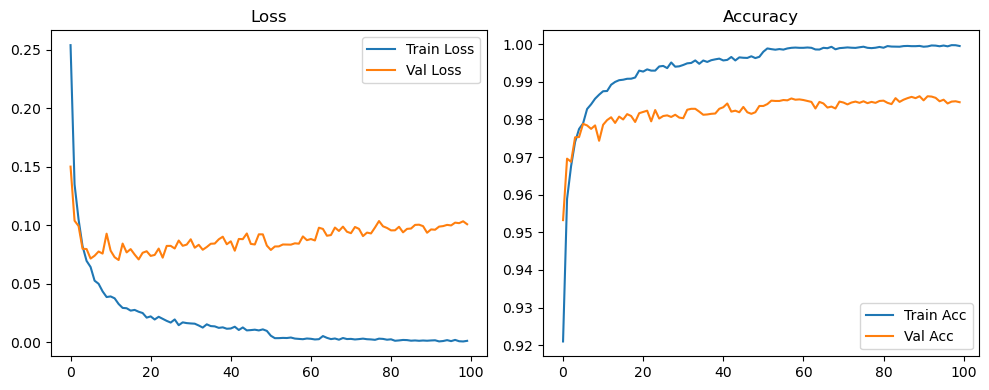

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3674, Acc: 0.8884 | Val Loss: 0.1718, Acc: 0.9478


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2177, Acc: 0.9338 | Val Loss: 0.1265, Acc: 0.9620


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1720, Acc: 0.9481 | Val Loss: 0.1116, Acc: 0.9660


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1527, Acc: 0.9544 | Val Loss: 0.1004, Acc: 0.9704


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1354, Acc: 0.9595 | Val Loss: 0.0983, Acc: 0.9708


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1272, Acc: 0.9605 | Val Loss: 0.0870, Acc: 0.9748


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1151, Acc: 0.9644 | Val Loss: 0.0796, Acc: 0.9767


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1074, Acc: 0.9667 | Val Loss: 0.0809, Acc: 0.9761


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1029, Acc: 0.9687 | Val Loss: 0.0796, Acc: 0.9771


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0973, Acc: 0.9695 | Val Loss: 0.0781, Acc: 0.9772


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0940, Acc: 0.9707 | Val Loss: 0.0794, Acc: 0.9770


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0869, Acc: 0.9726 | Val Loss: 0.0756, Acc: 0.9772


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0841, Acc: 0.9740 | Val Loss: 0.0781, Acc: 0.9780


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0830, Acc: 0.9741 | Val Loss: 0.0748, Acc: 0.9775


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0773, Acc: 0.9753 | Val Loss: 0.0715, Acc: 0.9778


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0766, Acc: 0.9759 | Val Loss: 0.0728, Acc: 0.9798


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0748, Acc: 0.9760 | Val Loss: 0.0691, Acc: 0.9797


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9782 | Val Loss: 0.0761, Acc: 0.9787


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0677, Acc: 0.9781 | Val Loss: 0.0729, Acc: 0.9792


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0671, Acc: 0.9785 | Val Loss: 0.0703, Acc: 0.9789


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0647, Acc: 0.9796 | Val Loss: 0.0723, Acc: 0.9802


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0633, Acc: 0.9794 | Val Loss: 0.0669, Acc: 0.9797


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0615, Acc: 0.9799 | Val Loss: 0.0715, Acc: 0.9794


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0590, Acc: 0.9809 | Val Loss: 0.0686, Acc: 0.9818


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9825 | Val Loss: 0.0645, Acc: 0.9812


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0534, Acc: 0.9825 | Val Loss: 0.0676, Acc: 0.9818


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0564, Acc: 0.9817 | Val Loss: 0.0672, Acc: 0.9814


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9825 | Val Loss: 0.0701, Acc: 0.9801


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9825 | Val Loss: 0.0707, Acc: 0.9816


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9840 | Val Loss: 0.0701, Acc: 0.9812


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9830 | Val Loss: 0.0673, Acc: 0.9812


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9835 | Val Loss: 0.0684, Acc: 0.9812


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0463, Acc: 0.9850 | Val Loss: 0.0656, Acc: 0.9822


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9833 | Val Loss: 0.0711, Acc: 0.9816


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9852 | Val Loss: 0.0672, Acc: 0.9826


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0467, Acc: 0.9843 | Val Loss: 0.0676, Acc: 0.9826


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0457, Acc: 0.9853 | Val Loss: 0.0699, Acc: 0.9819


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9860 | Val Loss: 0.0728, Acc: 0.9811


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9851 | Val Loss: 0.0700, Acc: 0.9813


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9861 | Val Loss: 0.0705, Acc: 0.9809


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9852 | Val Loss: 0.0662, Acc: 0.9822


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0415, Acc: 0.9870 | Val Loss: 0.0647, Acc: 0.9827


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9871 | Val Loss: 0.0735, Acc: 0.9812


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0367, Acc: 0.9881 | Val Loss: 0.0703, Acc: 0.9812


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9873 | Val Loss: 0.0677, Acc: 0.9815


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9877 | Val Loss: 0.0735, Acc: 0.9818


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9869 | Val Loss: 0.0706, Acc: 0.9812


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9871 | Val Loss: 0.0730, Acc: 0.9818


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0402, Acc: 0.9872 | Val Loss: 0.0753, Acc: 0.9799


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9883 | Val Loss: 0.0729, Acc: 0.9815


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9900 | Val Loss: 0.0694, Acc: 0.9821


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9911 | Val Loss: 0.0690, Acc: 0.9827


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0679, Acc: 0.9822


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0682, Acc: 0.9826


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9922 | Val Loss: 0.0693, Acc: 0.9829


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.0703, Acc: 0.9833


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0728, Acc: 0.9838


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.0695, Acc: 0.9842


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9926 | Val Loss: 0.0702, Acc: 0.9838


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9930 | Val Loss: 0.0697, Acc: 0.9840


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.0708, Acc: 0.9843


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.0686, Acc: 0.9842


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0685, Acc: 0.9833


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.0737, Acc: 0.9838


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9936 | Val Loss: 0.0703, Acc: 0.9838


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.0706, Acc: 0.9836


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0688, Acc: 0.9842


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0708, Acc: 0.9836


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0701, Acc: 0.9842


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0715, Acc: 0.9839


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0740, Acc: 0.9832


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.0753, Acc: 0.9835


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9940 | Val Loss: 0.0724, Acc: 0.9839


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.0706, Acc: 0.9841


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.0688, Acc: 0.9848


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.0694, Acc: 0.9846


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0679, Acc: 0.9844


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0691, Acc: 0.9842


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0715, Acc: 0.9832


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9948 | Val Loss: 0.0695, Acc: 0.9841


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0711, Acc: 0.9837


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0697, Acc: 0.9838


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0728, Acc: 0.9843


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9950 | Val Loss: 0.0701, Acc: 0.9848


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0703, Acc: 0.9842


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0704, Acc: 0.9845


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0704, Acc: 0.9848


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0720, Acc: 0.9838


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0726, Acc: 0.9838


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.0728, Acc: 0.9842


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0730, Acc: 0.9844


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0716, Acc: 0.9842


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0712, Acc: 0.9843


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0730, Acc: 0.9842


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0724, Acc: 0.9846


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0706, Acc: 0.9842


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0735, Acc: 0.9847


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0746, Acc: 0.9841


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0753, Acc: 0.9837


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.0747, Acc: 0.9848


Final Test Loss: 0.0682 Accuracy: 0.9865


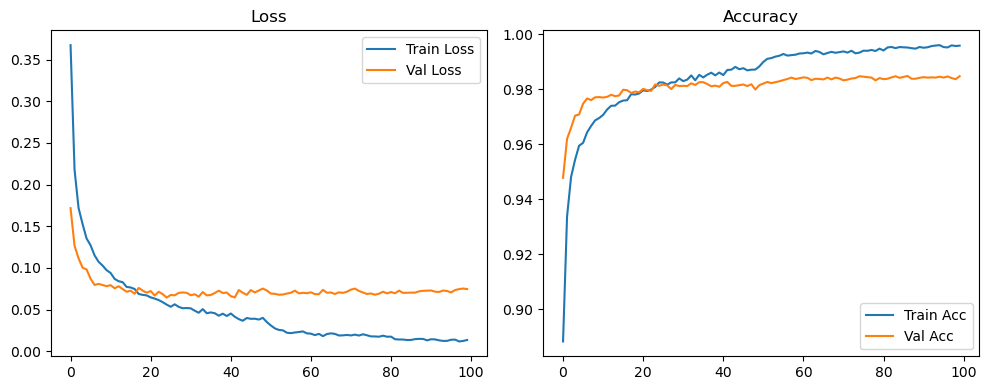

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2101, Acc: 0.9366 | Val Loss: 0.1241, Acc: 0.9615


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0970, Acc: 0.9702 | Val Loss: 0.0977, Acc: 0.9692


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0711, Acc: 0.9772 | Val Loss: 0.0878, Acc: 0.9727


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0542, Acc: 0.9823 | Val Loss: 0.0838, Acc: 0.9738


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9861 | Val Loss: 0.0908, Acc: 0.9724


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9884 | Val Loss: 0.0846, Acc: 0.9760


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0922, Acc: 0.9737


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9905 | Val Loss: 0.0870, Acc: 0.9779


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.0873, Acc: 0.9761


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.0849, Acc: 0.9767


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.0912, Acc: 0.9782


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0794, Acc: 0.9819


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9941 | Val Loss: 0.0960, Acc: 0.9763


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0769, Acc: 0.9793


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0978, Acc: 0.9780


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0961, Acc: 0.9758


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0904, Acc: 0.9791


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0856, Acc: 0.9815


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.1017, Acc: 0.9786


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9955 | Val Loss: 0.0912, Acc: 0.9807


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1013, Acc: 0.9788


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0977, Acc: 0.9779


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0982, Acc: 0.9791


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0990, Acc: 0.9790


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0895, Acc: 0.9818


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0876, Acc: 0.9800


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1073, Acc: 0.9786


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0880, Acc: 0.9808


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1061, Acc: 0.9797


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0945, Acc: 0.9813


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0881, Acc: 0.9820


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.0959, Acc: 0.9800


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0867, Acc: 0.9833


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0920, Acc: 0.9818


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1012, Acc: 0.9799


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1013, Acc: 0.9786


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0869, Acc: 0.9818


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0911, Acc: 0.9816


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0927, Acc: 0.9824


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0900, Acc: 0.9818


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0916, Acc: 0.9824


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0932, Acc: 0.9821


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0938, Acc: 0.9823


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1021, Acc: 0.9819


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1176, Acc: 0.9787


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0919, Acc: 0.9822


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1035, Acc: 0.9816


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1320, Acc: 0.9773


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1204, Acc: 0.9808


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1149, Acc: 0.9804


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0934, Acc: 0.9823


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0921, Acc: 0.9832


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1064, Acc: 0.9832


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1072, Acc: 0.9809


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0975, Acc: 0.9828


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1025, Acc: 0.9828


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1062, Acc: 0.9812


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1057, Acc: 0.9821


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1154, Acc: 0.9806


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1099, Acc: 0.9816


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.1042, Acc: 0.9827


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0984, Acc: 0.9836


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1061, Acc: 0.9828


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.1066, Acc: 0.9812


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0966, Acc: 0.9832


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1078, Acc: 0.9818


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1096, Acc: 0.9814


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.1282, Acc: 0.9796


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1090, Acc: 0.9822


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1002, Acc: 0.9820


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1047, Acc: 0.9825


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1066, Acc: 0.9826


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0996, Acc: 0.9833


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1084, Acc: 0.9814


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1048, Acc: 0.9828


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1118, Acc: 0.9815


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1104, Acc: 0.9813


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1090, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1028, Acc: 0.9837


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1161, Acc: 0.9803


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1046, Acc: 0.9819


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1046, Acc: 0.9830


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1017, Acc: 0.9850


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1039, Acc: 0.9835


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1030, Acc: 0.9836


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0957, Acc: 0.9840


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1055, Acc: 0.9834


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0995, Acc: 0.9830


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1176, Acc: 0.9818


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0965, Acc: 0.9835


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1066, Acc: 0.9832


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1039, Acc: 0.9838


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1108, Acc: 0.9819


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1006, Acc: 0.9837


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1025, Acc: 0.9839


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1103, Acc: 0.9825


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1029, Acc: 0.9832


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1100, Acc: 0.9828


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1096, Acc: 0.9820


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1248, Acc: 0.9802


Final Test Loss: 0.1091 Accuracy: 0.9842


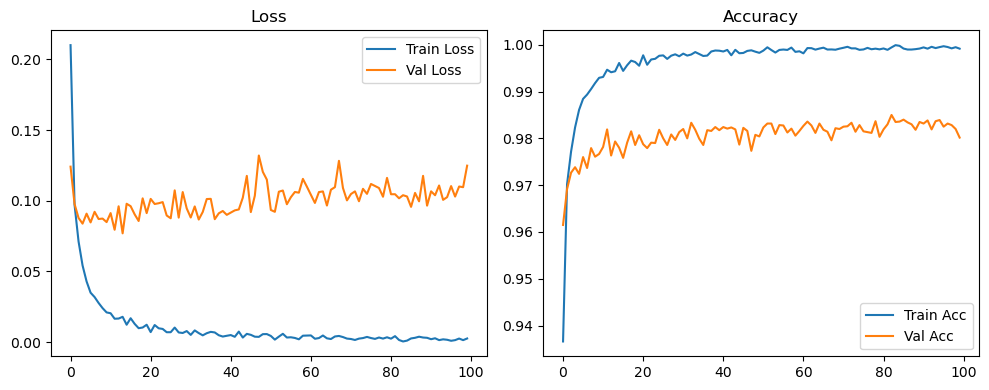

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2552, Acc: 0.9233 | Val Loss: 0.1394, Acc: 0.9570


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1315, Acc: 0.9592 | Val Loss: 0.1025, Acc: 0.9694


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1035, Acc: 0.9681 | Val Loss: 0.0952, Acc: 0.9708


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0841, Acc: 0.9731 | Val Loss: 0.0804, Acc: 0.9745


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0700, Acc: 0.9777 | Val Loss: 0.0816, Acc: 0.9748


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0648, Acc: 0.9790 | Val Loss: 0.0762, Acc: 0.9771


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9821 | Val Loss: 0.0735, Acc: 0.9766


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0512, Acc: 0.9835 | Val Loss: 0.0740, Acc: 0.9772


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9851 | Val Loss: 0.0842, Acc: 0.9770


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.0733, Acc: 0.9801


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.0706, Acc: 0.9808


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9877 | Val Loss: 0.0728, Acc: 0.9792


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9893 | Val Loss: 0.0730, Acc: 0.9795


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.0776, Acc: 0.9789


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9902 | Val Loss: 0.0753, Acc: 0.9808


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9908 | Val Loss: 0.0775, Acc: 0.9808


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.0745, Acc: 0.9815


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9922 | Val Loss: 0.0697, Acc: 0.9815


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9910 | Val Loss: 0.0769, Acc: 0.9789


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0203, Acc: 0.9927 | Val Loss: 0.0718, Acc: 0.9819


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0751, Acc: 0.9800


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9938 | Val Loss: 0.0729, Acc: 0.9822


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0839, Acc: 0.9801


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0751, Acc: 0.9828


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9934 | Val Loss: 0.0779, Acc: 0.9819


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0777, Acc: 0.9820


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0747, Acc: 0.9828


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0740, Acc: 0.9828


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0784, Acc: 0.9822


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0764, Acc: 0.9819


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9947 | Val Loss: 0.0749, Acc: 0.9830


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.0796, Acc: 0.9827


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0781, Acc: 0.9828


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0779, Acc: 0.9828


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0764, Acc: 0.9818


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0746, Acc: 0.9832


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0770, Acc: 0.9813


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.0743, Acc: 0.9824


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0793, Acc: 0.9819


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0820, Acc: 0.9825


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.0796, Acc: 0.9818


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0778, Acc: 0.9828


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0799, Acc: 0.9828


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0749, Acc: 0.9822


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0815, Acc: 0.9832


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0785, Acc: 0.9831


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.0779, Acc: 0.9833


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0740, Acc: 0.9847


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.0866, Acc: 0.9832


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0804, Acc: 0.9841


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0864, Acc: 0.9819


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0852, Acc: 0.9827


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0813, Acc: 0.9828


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0814, Acc: 0.9829


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0834, Acc: 0.9826


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0792, Acc: 0.9830


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0851, Acc: 0.9828


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0863, Acc: 0.9829


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0883, Acc: 0.9832


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0830, Acc: 0.9826


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0879, Acc: 0.9823


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0857, Acc: 0.9827


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0801, Acc: 0.9836


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0856, Acc: 0.9842


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0854, Acc: 0.9835


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0814, Acc: 0.9850


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0848, Acc: 0.9843


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0839, Acc: 0.9837


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0902, Acc: 0.9829


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0875, Acc: 0.9831


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0926, Acc: 0.9830


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0905, Acc: 0.9831


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0895, Acc: 0.9836


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0932, Acc: 0.9829


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0856, Acc: 0.9830


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0878, Acc: 0.9832


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0837, Acc: 0.9844


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0866, Acc: 0.9841


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0857, Acc: 0.9847


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0833, Acc: 0.9842


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0840, Acc: 0.9835


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0832, Acc: 0.9843


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0912, Acc: 0.9833


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0923, Acc: 0.9826


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0949, Acc: 0.9834


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0935, Acc: 0.9838


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0890, Acc: 0.9837


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.0912, Acc: 0.9839


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0947, Acc: 0.9830


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0866, Acc: 0.9842


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0920, Acc: 0.9836


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0956, Acc: 0.9833


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0847, Acc: 0.9844


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0839, Acc: 0.9838


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0839, Acc: 0.9852


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0836, Acc: 0.9846


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0866, Acc: 0.9856


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0907, Acc: 0.9849


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0969, Acc: 0.9835


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0878, Acc: 0.9848


Final Test Loss: 0.0838 Accuracy: 0.9839


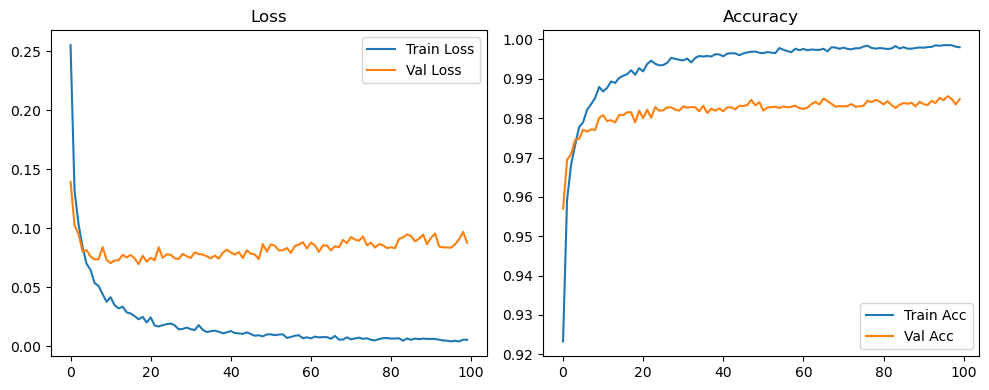

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3897, Acc: 0.8838 | Val Loss: 0.1654, Acc: 0.9503


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2239, Acc: 0.9323 | Val Loss: 0.1279, Acc: 0.9627


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1811, Acc: 0.9452 | Val Loss: 0.1146, Acc: 0.9634


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1600, Acc: 0.9506 | Val Loss: 0.1007, Acc: 0.9693


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1417, Acc: 0.9570 | Val Loss: 0.0964, Acc: 0.9691


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1295, Acc: 0.9602 | Val Loss: 0.0893, Acc: 0.9715


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1199, Acc: 0.9631 | Val Loss: 0.0824, Acc: 0.9742


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1101, Acc: 0.9657 | Val Loss: 0.0847, Acc: 0.9748


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1048, Acc: 0.9675 | Val Loss: 0.0805, Acc: 0.9756


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0983, Acc: 0.9685 | Val Loss: 0.0808, Acc: 0.9759


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0965, Acc: 0.9690 | Val Loss: 0.0808, Acc: 0.9759


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0924, Acc: 0.9700 | Val Loss: 0.0754, Acc: 0.9777


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0836, Acc: 0.9744 | Val Loss: 0.0782, Acc: 0.9776


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0885, Acc: 0.9717 | Val Loss: 0.0753, Acc: 0.9777


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0799, Acc: 0.9741 | Val Loss: 0.0730, Acc: 0.9779


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0768, Acc: 0.9753 | Val Loss: 0.0702, Acc: 0.9791


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0758, Acc: 0.9754 | Val Loss: 0.0711, Acc: 0.9780


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0731, Acc: 0.9762 | Val Loss: 0.0724, Acc: 0.9780


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0728, Acc: 0.9773 | Val Loss: 0.0680, Acc: 0.9795


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0670, Acc: 0.9781 | Val Loss: 0.0682, Acc: 0.9801


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0629, Acc: 0.9795 | Val Loss: 0.0708, Acc: 0.9794


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0647, Acc: 0.9789 | Val Loss: 0.0684, Acc: 0.9811


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9796 | Val Loss: 0.0717, Acc: 0.9801


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0615, Acc: 0.9795 | Val Loss: 0.0656, Acc: 0.9806


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9818 | Val Loss: 0.0659, Acc: 0.9809


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0563, Acc: 0.9824 | Val Loss: 0.0674, Acc: 0.9812


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9807 | Val Loss: 0.0696, Acc: 0.9805


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9821 | Val Loss: 0.0651, Acc: 0.9807


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0515, Acc: 0.9828 | Val Loss: 0.0677, Acc: 0.9812


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0519, Acc: 0.9823 | Val Loss: 0.0694, Acc: 0.9820


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0537, Acc: 0.9824 | Val Loss: 0.0664, Acc: 0.9816


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9838 | Val Loss: 0.0669, Acc: 0.9806


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0479, Acc: 0.9839 | Val Loss: 0.0692, Acc: 0.9806


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9834 | Val Loss: 0.0662, Acc: 0.9821


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0459, Acc: 0.9849 | Val Loss: 0.0653, Acc: 0.9820


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9847 | Val Loss: 0.0665, Acc: 0.9812


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9845 | Val Loss: 0.0668, Acc: 0.9823


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0443, Acc: 0.9855 | Val Loss: 0.0699, Acc: 0.9806


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9855 | Val Loss: 0.0691, Acc: 0.9811


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9866 | Val Loss: 0.0689, Acc: 0.9812


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9859 | Val Loss: 0.0697, Acc: 0.9808


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9869 | Val Loss: 0.0668, Acc: 0.9821


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9868 | Val Loss: 0.0704, Acc: 0.9813


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9862 | Val Loss: 0.0655, Acc: 0.9809


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9867 | Val Loss: 0.0697, Acc: 0.9795


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9867 | Val Loss: 0.0687, Acc: 0.9808


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.0704, Acc: 0.9812


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0376, Acc: 0.9879 | Val Loss: 0.0688, Acc: 0.9816


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0663, Acc: 0.9822


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9876 | Val Loss: 0.0683, Acc: 0.9818


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9876 | Val Loss: 0.0670, Acc: 0.9817


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9880 | Val Loss: 0.0665, Acc: 0.9823


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9880 | Val Loss: 0.0647, Acc: 0.9832


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0369, Acc: 0.9874 | Val Loss: 0.0695, Acc: 0.9822


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9880 | Val Loss: 0.0696, Acc: 0.9831


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9880 | Val Loss: 0.0680, Acc: 0.9827


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.0700, Acc: 0.9808


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9903 | Val Loss: 0.0717, Acc: 0.9822


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9890 | Val Loss: 0.0724, Acc: 0.9828


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9894 | Val Loss: 0.0666, Acc: 0.9840


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9888 | Val Loss: 0.0734, Acc: 0.9826


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0714, Acc: 0.9818


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 0.0736, Acc: 0.9822


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.0742, Acc: 0.9815


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9890 | Val Loss: 0.0715, Acc: 0.9832


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9902 | Val Loss: 0.0723, Acc: 0.9824


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9896 | Val Loss: 0.0738, Acc: 0.9820


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.0746, Acc: 0.9813


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9902 | Val Loss: 0.0765, Acc: 0.9817


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0289, Acc: 0.9901 | Val Loss: 0.0718, Acc: 0.9827


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9900 | Val Loss: 0.0715, Acc: 0.9811


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9897 | Val Loss: 0.0748, Acc: 0.9809


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0740, Acc: 0.9818


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9910 | Val Loss: 0.0739, Acc: 0.9818


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0288, Acc: 0.9910 | Val Loss: 0.0691, Acc: 0.9820


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.0714, Acc: 0.9828


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0741, Acc: 0.9828


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.0744, Acc: 0.9818


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9905 | Val Loss: 0.0698, Acc: 0.9836


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9905 | Val Loss: 0.0701, Acc: 0.9827


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9905 | Val Loss: 0.0732, Acc: 0.9824


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0722, Acc: 0.9819


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9912 | Val Loss: 0.0766, Acc: 0.9822


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.0771, Acc: 0.9822


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9912 | Val Loss: 0.0770, Acc: 0.9826


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.0808, Acc: 0.9814


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.0730, Acc: 0.9829


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0759, Acc: 0.9817


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0756, Acc: 0.9821


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.0758, Acc: 0.9826


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.0771, Acc: 0.9829


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0242, Acc: 0.9915 | Val Loss: 0.0710, Acc: 0.9835


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.0718, Acc: 0.9829


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9930 | Val Loss: 0.0748, Acc: 0.9823


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0749, Acc: 0.9820


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.0718, Acc: 0.9829


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.0768, Acc: 0.9818


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.0812, Acc: 0.9821


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9921 | Val Loss: 0.0797, Acc: 0.9803


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0765, Acc: 0.9825


Final Test Loss: 0.0696 Accuracy: 0.9849


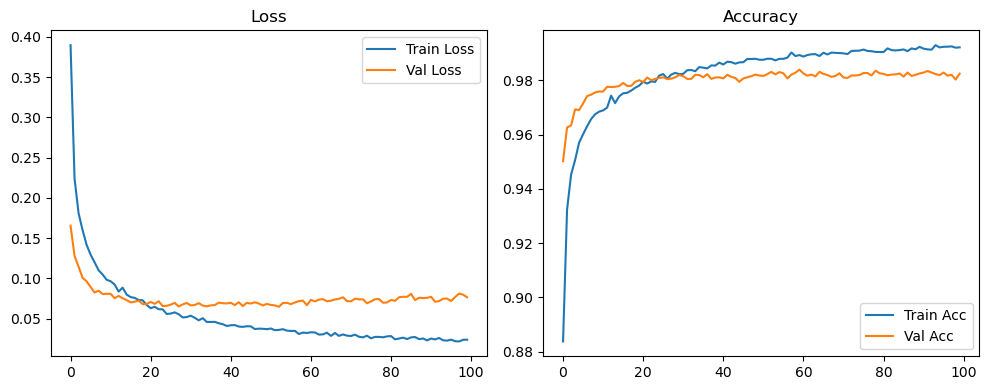

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2164, Acc: 0.9385 | Val Loss: 0.1165, Acc: 0.9659


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0909, Acc: 0.9722 | Val Loss: 0.0924, Acc: 0.9720


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0649, Acc: 0.9794 | Val Loss: 0.0910, Acc: 0.9711


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9839 | Val Loss: 0.0781, Acc: 0.9750


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9879 | Val Loss: 0.0781, Acc: 0.9767


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 0.0828, Acc: 0.9762


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9901 | Val Loss: 0.0863, Acc: 0.9755


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9928 | Val Loss: 0.0778, Acc: 0.9789


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0849, Acc: 0.9778


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9930 | Val Loss: 0.0911, Acc: 0.9758


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0855, Acc: 0.9778


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0842, Acc: 0.9792


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0918, Acc: 0.9781


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9943 | Val Loss: 0.0825, Acc: 0.9778


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0923, Acc: 0.9781


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0808, Acc: 0.9805


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0808, Acc: 0.9811


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0902, Acc: 0.9793


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0808, Acc: 0.9801


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0851, Acc: 0.9795


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.0850, Acc: 0.9787


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0861, Acc: 0.9798


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0847, Acc: 0.9804


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9796


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0960, Acc: 0.9788


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0966, Acc: 0.9788


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0987, Acc: 0.9808


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0960, Acc: 0.9794


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0852, Acc: 0.9824


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0953, Acc: 0.9806


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0838, Acc: 0.9810


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0985, Acc: 0.9799


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1032, Acc: 0.9802


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0950, Acc: 0.9812


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0935, Acc: 0.9804


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0908, Acc: 0.9825


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0980, Acc: 0.9809


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0954, Acc: 0.9805


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0855, Acc: 0.9831


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0963, Acc: 0.9816


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1040, Acc: 0.9795


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0872, Acc: 0.9820


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0915, Acc: 0.9824


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0815, Acc: 0.9828


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0895, Acc: 0.9832


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0927, Acc: 0.9815


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1053, Acc: 0.9800


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0952, Acc: 0.9832


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0886, Acc: 0.9838


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0860, Acc: 0.9839


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0945, Acc: 0.9811


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0875, Acc: 0.9832


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0901, Acc: 0.9831


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0910, Acc: 0.9829


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0988, Acc: 0.9817


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0936, Acc: 0.9816


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1047, Acc: 0.9823


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1006, Acc: 0.9818


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1037, Acc: 0.9818


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0966, Acc: 0.9834


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1050, Acc: 0.9822


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0971, Acc: 0.9832


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1058, Acc: 0.9823


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1026, Acc: 0.9820


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1053, Acc: 0.9813


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1071, Acc: 0.9821


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1004, Acc: 0.9828


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0937, Acc: 0.9825


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0972, Acc: 0.9831


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0972, Acc: 0.9828


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0987, Acc: 0.9828


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0982, Acc: 0.9821


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0976, Acc: 0.9818


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1005, Acc: 0.9823


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1006, Acc: 0.9825


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0944, Acc: 0.9833


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0921, Acc: 0.9848


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1157, Acc: 0.9806


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1059, Acc: 0.9819


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0999, Acc: 0.9827


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1070, Acc: 0.9832


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1076, Acc: 0.9828


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1040, Acc: 0.9850


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1091, Acc: 0.9841


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1072, Acc: 0.9832


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1052, Acc: 0.9837


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1058, Acc: 0.9838


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1112, Acc: 0.9835


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1094, Acc: 0.9835


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1098, Acc: 0.9828


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1098, Acc: 0.9830


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1019, Acc: 0.9842


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1038, Acc: 0.9842


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0989, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1111, Acc: 0.9828


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1035, Acc: 0.9841


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1048, Acc: 0.9827


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.0971, Acc: 0.9832


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0983, Acc: 0.9839


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1004, Acc: 0.9839


Final Test Loss: 0.0945 Accuracy: 0.9849


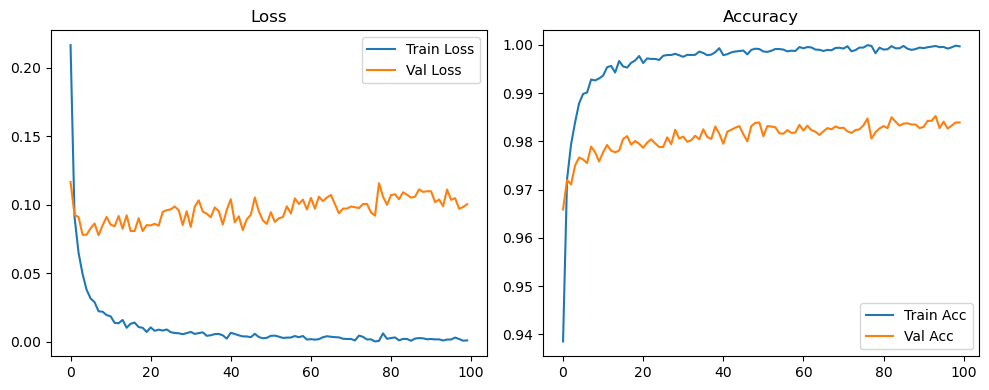

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2758, Acc: 0.9207 | Val Loss: 0.1314, Acc: 0.9605


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1306, Acc: 0.9606 | Val Loss: 0.1036, Acc: 0.9695


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1028, Acc: 0.9685 | Val Loss: 0.0975, Acc: 0.9720


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0851, Acc: 0.9730 | Val Loss: 0.0821, Acc: 0.9742


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0698, Acc: 0.9776 | Val Loss: 0.0822, Acc: 0.9743


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0646, Acc: 0.9783 | Val Loss: 0.0777, Acc: 0.9767


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0549, Acc: 0.9815 | Val Loss: 0.0732, Acc: 0.9779


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0516, Acc: 0.9837 | Val Loss: 0.0761, Acc: 0.9777


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9841 | Val Loss: 0.0777, Acc: 0.9764


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9860 | Val Loss: 0.0688, Acc: 0.9792


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9870 | Val Loss: 0.0741, Acc: 0.9786


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9870 | Val Loss: 0.0695, Acc: 0.9804


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 0.0760, Acc: 0.9804


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9898 | Val Loss: 0.0749, Acc: 0.9801


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9891 | Val Loss: 0.0741, Acc: 0.9798


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9892 | Val Loss: 0.0783, Acc: 0.9792


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9911 | Val Loss: 0.0781, Acc: 0.9792


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.0703, Acc: 0.9805


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9910 | Val Loss: 0.0740, Acc: 0.9801


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9925 | Val Loss: 0.0719, Acc: 0.9812


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0227, Acc: 0.9919 | Val Loss: 0.0738, Acc: 0.9816


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0202, Acc: 0.9928 | Val Loss: 0.0724, Acc: 0.9812


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9930 | Val Loss: 0.0757, Acc: 0.9814


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9929 | Val Loss: 0.0732, Acc: 0.9807


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9936 | Val Loss: 0.0698, Acc: 0.9828


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9934 | Val Loss: 0.0742, Acc: 0.9817


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.0728, Acc: 0.9816


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0676, Acc: 0.9823


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9942 | Val Loss: 0.0743, Acc: 0.9819


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0688, Acc: 0.9845


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0705, Acc: 0.9827


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.0708, Acc: 0.9824


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0765, Acc: 0.9819


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0749, Acc: 0.9828


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0785, Acc: 0.9815


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0712, Acc: 0.9834


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.0737, Acc: 0.9815


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0719, Acc: 0.9835


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0784, Acc: 0.9822


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0793, Acc: 0.9816


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0733, Acc: 0.9834


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0733, Acc: 0.9827


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0763, Acc: 0.9817


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0744, Acc: 0.9835


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0726, Acc: 0.9832


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0764, Acc: 0.9830


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0812, Acc: 0.9817


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0779, Acc: 0.9832


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9961 | Val Loss: 0.0735, Acc: 0.9841


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0776, Acc: 0.9826


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0788, Acc: 0.9827


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.0837, Acc: 0.9822


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0794, Acc: 0.9833


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0753, Acc: 0.9830


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0784, Acc: 0.9834


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0837, Acc: 0.9814


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0782, Acc: 0.9835


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0854, Acc: 0.9832


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9969 | Val Loss: 0.0804, Acc: 0.9835


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0788, Acc: 0.9836


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0760, Acc: 0.9833


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0776, Acc: 0.9828


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0791, Acc: 0.9836


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0774, Acc: 0.9835


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0834, Acc: 0.9827


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0822, Acc: 0.9832


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0771, Acc: 0.9844


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.0837, Acc: 0.9828


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0763, Acc: 0.9842


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0846, Acc: 0.9832


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0806, Acc: 0.9839


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0826, Acc: 0.9828


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0833, Acc: 0.9822


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0851, Acc: 0.9834


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0826, Acc: 0.9830


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0841, Acc: 0.9832


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0868, Acc: 0.9844


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0885, Acc: 0.9830


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0851, Acc: 0.9837


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0839, Acc: 0.9822


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0895, Acc: 0.9823


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0876, Acc: 0.9818


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0847, Acc: 0.9840


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0806, Acc: 0.9851


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0877, Acc: 0.9813


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0848, Acc: 0.9817


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0853, Acc: 0.9840


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0870, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0821, Acc: 0.9839


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0851, Acc: 0.9836


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0870, Acc: 0.9842


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0862, Acc: 0.9835


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0862, Acc: 0.9843


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9980 | Val Loss: 0.0842, Acc: 0.9836


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0834, Acc: 0.9839


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0887, Acc: 0.9836


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0901, Acc: 0.9833


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0875, Acc: 0.9838


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0866, Acc: 0.9832


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0820, Acc: 0.9847


Final Test Loss: 0.0819 Accuracy: 0.9832


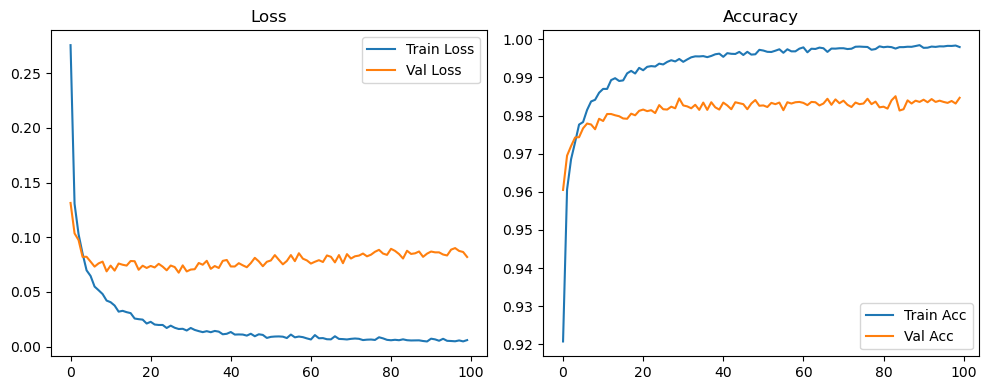

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4425, Acc: 0.8709 | Val Loss: 0.1789, Acc: 0.9467


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2324, Acc: 0.9295 | Val Loss: 0.1409, Acc: 0.9573


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1936, Acc: 0.9416 | Val Loss: 0.1219, Acc: 0.9624


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1677, Acc: 0.9485 | Val Loss: 0.1080, Acc: 0.9668


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1524, Acc: 0.9533 | Val Loss: 0.1041, Acc: 0.9678


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1385, Acc: 0.9571 | Val Loss: 0.0913, Acc: 0.9720


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1305, Acc: 0.9602 | Val Loss: 0.0881, Acc: 0.9715


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1196, Acc: 0.9625 | Val Loss: 0.0874, Acc: 0.9718


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1151, Acc: 0.9646 | Val Loss: 0.0821, Acc: 0.9739


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1080, Acc: 0.9659 | Val Loss: 0.0833, Acc: 0.9761


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1029, Acc: 0.9672 | Val Loss: 0.0802, Acc: 0.9771


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0975, Acc: 0.9694 | Val Loss: 0.0753, Acc: 0.9764


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0895, Acc: 0.9710 | Val Loss: 0.0773, Acc: 0.9760


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0943, Acc: 0.9696 | Val Loss: 0.0796, Acc: 0.9762


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0861, Acc: 0.9721 | Val Loss: 0.0729, Acc: 0.9772


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0811, Acc: 0.9743 | Val Loss: 0.0737, Acc: 0.9771


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0811, Acc: 0.9733 | Val Loss: 0.0735, Acc: 0.9770


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0801, Acc: 0.9752 | Val Loss: 0.0740, Acc: 0.9778


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0762, Acc: 0.9761 | Val Loss: 0.0713, Acc: 0.9790


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0709, Acc: 0.9765 | Val Loss: 0.0700, Acc: 0.9787


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0704, Acc: 0.9762 | Val Loss: 0.0751, Acc: 0.9782


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0701, Acc: 0.9771 | Val Loss: 0.0699, Acc: 0.9807


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0679, Acc: 0.9779 | Val Loss: 0.0731, Acc: 0.9796


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0640, Acc: 0.9795 | Val Loss: 0.0673, Acc: 0.9817


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0624, Acc: 0.9788 | Val Loss: 0.0731, Acc: 0.9790


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0605, Acc: 0.9793 | Val Loss: 0.0699, Acc: 0.9792


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0637, Acc: 0.9790 | Val Loss: 0.0711, Acc: 0.9787


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0595, Acc: 0.9798 | Val Loss: 0.0674, Acc: 0.9805


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0538, Acc: 0.9817 | Val Loss: 0.0668, Acc: 0.9808


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0576, Acc: 0.9817 | Val Loss: 0.0685, Acc: 0.9808


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0573, Acc: 0.9810 | Val Loss: 0.0691, Acc: 0.9798


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0561, Acc: 0.9815 | Val Loss: 0.0704, Acc: 0.9798


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0534, Acc: 0.9824 | Val Loss: 0.0695, Acc: 0.9798


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0520, Acc: 0.9828 | Val Loss: 0.0703, Acc: 0.9814


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0505, Acc: 0.9832 | Val Loss: 0.0697, Acc: 0.9814


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0499, Acc: 0.9838 | Val Loss: 0.0687, Acc: 0.9808


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9826 | Val Loss: 0.0679, Acc: 0.9808


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9837 | Val Loss: 0.0701, Acc: 0.9798


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9846 | Val Loss: 0.0713, Acc: 0.9808


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0472, Acc: 0.9837 | Val Loss: 0.0704, Acc: 0.9799


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0478, Acc: 0.9838 | Val Loss: 0.0673, Acc: 0.9807


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9849 | Val Loss: 0.0667, Acc: 0.9818


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0435, Acc: 0.9853 | Val Loss: 0.0679, Acc: 0.9812


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0413, Acc: 0.9853 | Val Loss: 0.0688, Acc: 0.9823


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0454, Acc: 0.9845 | Val Loss: 0.0673, Acc: 0.9818


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9851 | Val Loss: 0.0676, Acc: 0.9818


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9870 | Val Loss: 0.0670, Acc: 0.9811


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9867 | Val Loss: 0.0659, Acc: 0.9823


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.0700, Acc: 0.9822


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9856 | Val Loss: 0.0646, Acc: 0.9818


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9863 | Val Loss: 0.0655, Acc: 0.9834


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9870 | Val Loss: 0.0678, Acc: 0.9827


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9866 | Val Loss: 0.0622, Acc: 0.9824


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9872 | Val Loss: 0.0682, Acc: 0.9826


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9878 | Val Loss: 0.0685, Acc: 0.9818


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9876 | Val Loss: 0.0673, Acc: 0.9822


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9868 | Val Loss: 0.0667, Acc: 0.9815


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.0697, Acc: 0.9815


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9887 | Val Loss: 0.0689, Acc: 0.9818


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9880 | Val Loss: 0.0682, Acc: 0.9832


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9888 | Val Loss: 0.0686, Acc: 0.9825


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9883 | Val Loss: 0.0698, Acc: 0.9818


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0344, Acc: 0.9884 | Val Loss: 0.0719, Acc: 0.9812


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.0690, Acc: 0.9828


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9892 | Val Loss: 0.0707, Acc: 0.9823


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9891 | Val Loss: 0.0703, Acc: 0.9821


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9888 | Val Loss: 0.0678, Acc: 0.9823


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9888 | Val Loss: 0.0707, Acc: 0.9822


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9886 | Val Loss: 0.0706, Acc: 0.9825


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9896 | Val Loss: 0.0687, Acc: 0.9827


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.0705, Acc: 0.9832


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9890 | Val Loss: 0.0725, Acc: 0.9829


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9905 | Val Loss: 0.0722, Acc: 0.9822


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9894 | Val Loss: 0.0705, Acc: 0.9825


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9898 | Val Loss: 0.0680, Acc: 0.9822


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9907 | Val Loss: 0.0687, Acc: 0.9828


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.0685, Acc: 0.9825


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9899 | Val Loss: 0.0703, Acc: 0.9828


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.0681, Acc: 0.9819


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9902 | Val Loss: 0.0709, Acc: 0.9823


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9891 | Val Loss: 0.0701, Acc: 0.9822


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.0689, Acc: 0.9819


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 0.0718, Acc: 0.9831


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.0688, Acc: 0.9832


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9908 | Val Loss: 0.0719, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.0720, Acc: 0.9823


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9909 | Val Loss: 0.0699, Acc: 0.9828


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9904 | Val Loss: 0.0727, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9914 | Val Loss: 0.0709, Acc: 0.9822


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.0717, Acc: 0.9826


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.0729, Acc: 0.9821


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.0691, Acc: 0.9825


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.0717, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9917 | Val Loss: 0.0714, Acc: 0.9829


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0726, Acc: 0.9826


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.0709, Acc: 0.9826


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.0739, Acc: 0.9819


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.0721, Acc: 0.9827


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9917 | Val Loss: 0.0746, Acc: 0.9821


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.0725, Acc: 0.9822


Final Test Loss: 0.0694 Accuracy: 0.9841


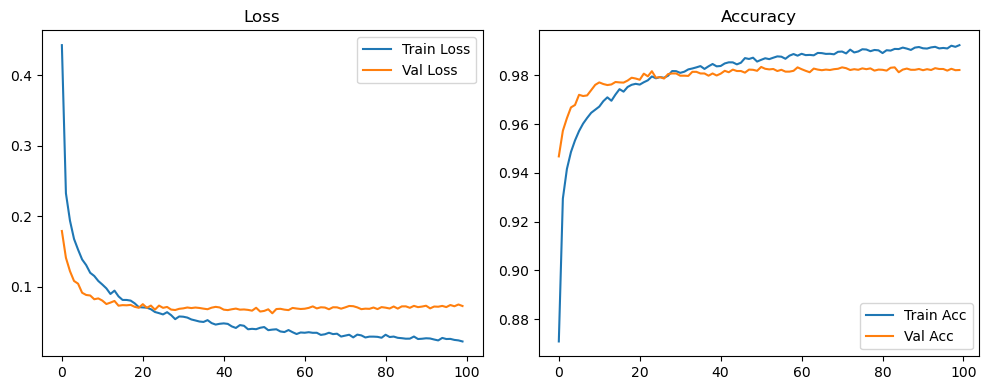

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2270, Acc: 0.9294 | Val Loss: 0.1337, Acc: 0.9597


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1050, Acc: 0.9671 | Val Loss: 0.1103, Acc: 0.9674


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9770 | Val Loss: 0.1123, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9816 | Val Loss: 0.1155, Acc: 0.9676


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.0924, Acc: 0.9742


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9881 | Val Loss: 0.0882, Acc: 0.9743


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.1027, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9907 | Val Loss: 0.1042, Acc: 0.9753


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0939, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9932 | Val Loss: 0.1039, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.0934, Acc: 0.9776


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1094, Acc: 0.9747


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0932, Acc: 0.9785


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1113, Acc: 0.9747


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1035, Acc: 0.9772


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1095, Acc: 0.9784


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.0935, Acc: 0.9802


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0985, Acc: 0.9793


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.1048, Acc: 0.9788


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1147, Acc: 0.9798


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1034, Acc: 0.9787


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1258, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1033, Acc: 0.9797


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1070, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0997, Acc: 0.9809


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1081, Acc: 0.9799


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1027, Acc: 0.9793


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1127, Acc: 0.9781


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1059, Acc: 0.9808


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1044, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1069, Acc: 0.9810


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0997, Acc: 0.9809


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1117, Acc: 0.9790


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1069, Acc: 0.9804


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1223, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1122, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1005, Acc: 0.9818


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1000, Acc: 0.9829


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0992, Acc: 0.9830


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1199, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1097, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1091, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1184, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1043, Acc: 0.9828


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1004, Acc: 0.9833


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1028, Acc: 0.9819


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1059, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1083, Acc: 0.9809


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1084, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1093, Acc: 0.9818


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1010, Acc: 0.9818


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1159, Acc: 0.9806


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1245, Acc: 0.9782


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1120, Acc: 0.9809


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1055, Acc: 0.9832


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1264, Acc: 0.9796


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1071, Acc: 0.9810


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1047, Acc: 0.9812


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1162, Acc: 0.9812


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1175, Acc: 0.9815


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1028, Acc: 0.9811


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0987, Acc: 0.9822


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1232, Acc: 0.9801


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1056, Acc: 0.9823


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1219, Acc: 0.9815


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1015, Acc: 0.9816


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1105, Acc: 0.9818


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1204, Acc: 0.9816


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1268, Acc: 0.9792


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.1172, Acc: 0.9811


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1190, Acc: 0.9812


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9993 | Val Loss: 0.1197, Acc: 0.9799


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1281, Acc: 0.9806


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.1116, Acc: 0.9814


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1257, Acc: 0.9812


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1362, Acc: 0.9797


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1262, Acc: 0.9799


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1387, Acc: 0.9808


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1256, Acc: 0.9796


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1238, Acc: 0.9802


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1197, Acc: 0.9817


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1162, Acc: 0.9800


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1239, Acc: 0.9809


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1232, Acc: 0.9800


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1210, Acc: 0.9812


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1322, Acc: 0.9813


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1206, Acc: 0.9812


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1271, Acc: 0.9809


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1233, Acc: 0.9825


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1175, Acc: 0.9812


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1267, Acc: 0.9805


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1231, Acc: 0.9822


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1154, Acc: 0.9811


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1208, Acc: 0.9818


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1106, Acc: 0.9806


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1155, Acc: 0.9808


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1116, Acc: 0.9818


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1115, Acc: 0.9818


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1243, Acc: 0.9808


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1181, Acc: 0.9827


Final Test Loss: 0.1192 Accuracy: 0.9831


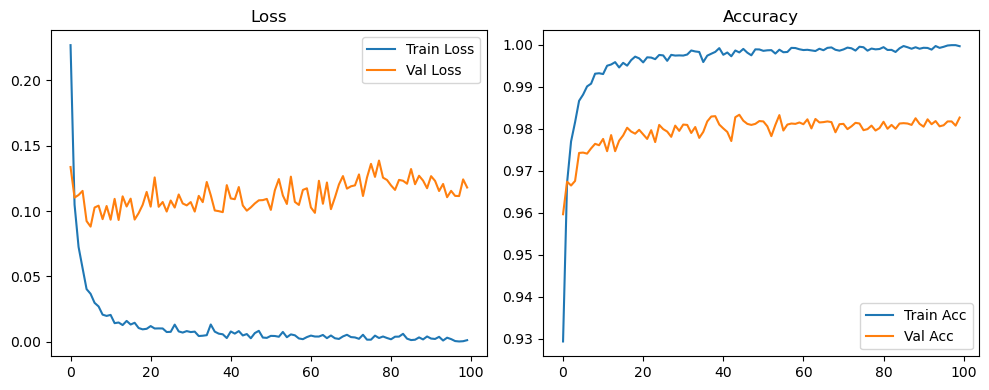

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2598, Acc: 0.9195 | Val Loss: 0.1341, Acc: 0.9595


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1334, Acc: 0.9592 | Val Loss: 0.1131, Acc: 0.9636


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9686 | Val Loss: 0.0991, Acc: 0.9707


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9747 | Val Loss: 0.0920, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9801 | Val Loss: 0.0889, Acc: 0.9743


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9813 | Val Loss: 0.0829, Acc: 0.9746


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9839 | Val Loss: 0.0811, Acc: 0.9753


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.0735, Acc: 0.9796


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0791, Acc: 0.9784


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.0839, Acc: 0.9775


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0818, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9890 | Val Loss: 0.0795, Acc: 0.9787


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.0884, Acc: 0.9786


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0839, Acc: 0.9786


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.0861, Acc: 0.9791


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.0871, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.0857, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0891, Acc: 0.9793


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9924 | Val Loss: 0.0874, Acc: 0.9775


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0789, Acc: 0.9822


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0926, Acc: 0.9796


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0839, Acc: 0.9792


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0827, Acc: 0.9810


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0908, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0951, Acc: 0.9793


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0873, Acc: 0.9820


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0840, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0907, Acc: 0.9819


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0882, Acc: 0.9825


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0959, Acc: 0.9797


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.0921, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0944, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0883, Acc: 0.9817


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0917, Acc: 0.9801


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0919, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0882, Acc: 0.9818


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0815, Acc: 0.9824


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0959, Acc: 0.9804


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0913, Acc: 0.9813


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0856, Acc: 0.9816


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0899, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0804, Acc: 0.9832


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0929, Acc: 0.9802


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0913, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0865, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0864, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0919, Acc: 0.9813


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0942, Acc: 0.9820


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0955, Acc: 0.9809


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0908, Acc: 0.9818


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0924, Acc: 0.9814


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9964 | Val Loss: 0.0922, Acc: 0.9819


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0920, Acc: 0.9825


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0981, Acc: 0.9810


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0997, Acc: 0.9822


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0921, Acc: 0.9823


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0960, Acc: 0.9823


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0930, Acc: 0.9815


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0947, Acc: 0.9822


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0991, Acc: 0.9832


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0976, Acc: 0.9833


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0940, Acc: 0.9820


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0902, Acc: 0.9836


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0940, Acc: 0.9827


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0895, Acc: 0.9847


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0887, Acc: 0.9832


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1054, Acc: 0.9814


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0980, Acc: 0.9828


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0879, Acc: 0.9829


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0944, Acc: 0.9818


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0926, Acc: 0.9826


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0986, Acc: 0.9818


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0948, Acc: 0.9828


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0980, Acc: 0.9832


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0963, Acc: 0.9837


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1032, Acc: 0.9832


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0974, Acc: 0.9839


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0924, Acc: 0.9843


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9982 | Val Loss: 0.0949, Acc: 0.9836


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0970, Acc: 0.9836


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0914, Acc: 0.9840


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0903, Acc: 0.9831


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0998, Acc: 0.9820


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1023, Acc: 0.9827


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0940, Acc: 0.9832


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0978, Acc: 0.9840


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0952, Acc: 0.9835


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1004, Acc: 0.9832


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0976, Acc: 0.9828


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1005, Acc: 0.9832


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1018, Acc: 0.9824


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1020, Acc: 0.9828


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0958, Acc: 0.9837


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0993, Acc: 0.9830


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1031, Acc: 0.9824


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1008, Acc: 0.9845


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0971, Acc: 0.9848


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0957, Acc: 0.9839


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0973, Acc: 0.9846


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1003, Acc: 0.9848


Final Test Loss: 0.0831 Accuracy: 0.9845


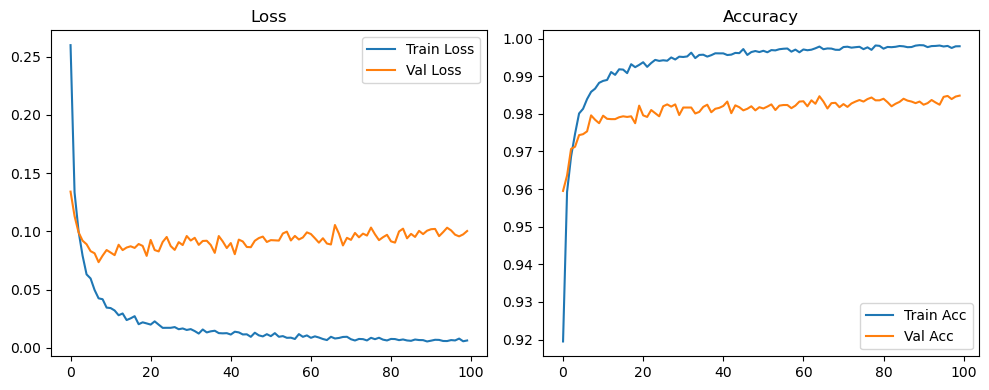

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3761, Acc: 0.8838 | Val Loss: 0.1618, Acc: 0.9521


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2142, Acc: 0.9369 | Val Loss: 0.1323, Acc: 0.9585


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1681, Acc: 0.9482 | Val Loss: 0.1027, Acc: 0.9693


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1419, Acc: 0.9562 | Val Loss: 0.1005, Acc: 0.9696


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9614 | Val Loss: 0.0883, Acc: 0.9719


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9628 | Val Loss: 0.0815, Acc: 0.9749


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9672 | Val Loss: 0.0858, Acc: 0.9733


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9683 | Val Loss: 0.0816, Acc: 0.9762


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9695 | Val Loss: 0.0773, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9716 | Val Loss: 0.0757, Acc: 0.9768


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9724 | Val Loss: 0.0728, Acc: 0.9788


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9744 | Val Loss: 0.0771, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9763 | Val Loss: 0.0755, Acc: 0.9792


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9754 | Val Loss: 0.0756, Acc: 0.9794


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9773 | Val Loss: 0.0737, Acc: 0.9797


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9773 | Val Loss: 0.0727, Acc: 0.9797


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9778 | Val Loss: 0.0710, Acc: 0.9791


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9795 | Val Loss: 0.0777, Acc: 0.9780


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9804 | Val Loss: 0.0738, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9799 | Val Loss: 0.0700, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9815 | Val Loss: 0.0751, Acc: 0.9798


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9807 | Val Loss: 0.0727, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9810 | Val Loss: 0.0711, Acc: 0.9790


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 0.0659, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9827 | Val Loss: 0.0725, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9831 | Val Loss: 0.0695, Acc: 0.9809


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.0702, Acc: 0.9819


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9833 | Val Loss: 0.0740, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.0696, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9844 | Val Loss: 0.0756, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 0.0699, Acc: 0.9816


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9847 | Val Loss: 0.0717, Acc: 0.9815


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9845 | Val Loss: 0.0761, Acc: 0.9793


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0821, Acc: 0.9791


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9852 | Val Loss: 0.0700, Acc: 0.9818


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 0.0693, Acc: 0.9809


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9853 | Val Loss: 0.0719, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9865 | Val Loss: 0.0757, Acc: 0.9815


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9863 | Val Loss: 0.0729, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9868 | Val Loss: 0.0718, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9871 | Val Loss: 0.0692, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9878 | Val Loss: 0.0703, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 0.0688, Acc: 0.9824


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9885 | Val Loss: 0.0710, Acc: 0.9812


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9867 | Val Loss: 0.0734, Acc: 0.9823


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0771, Acc: 0.9812


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9867 | Val Loss: 0.0734, Acc: 0.9822


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 0.0752, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9892 | Val Loss: 0.0761, Acc: 0.9832


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.0780, Acc: 0.9812


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9886 | Val Loss: 0.0747, Acc: 0.9813


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0701, Acc: 0.9816


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9885 | Val Loss: 0.0685, Acc: 0.9827


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9901 | Val Loss: 0.0804, Acc: 0.9815


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9886 | Val Loss: 0.0739, Acc: 0.9822


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.0703, Acc: 0.9825


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9895 | Val Loss: 0.0765, Acc: 0.9818


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9893 | Val Loss: 0.0757, Acc: 0.9828


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.0777, Acc: 0.9813


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9894 | Val Loss: 0.0747, Acc: 0.9817


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.0720, Acc: 0.9822


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9908 | Val Loss: 0.0748, Acc: 0.9828


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.0821, Acc: 0.9823


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0340, Acc: 0.9890 | Val Loss: 0.0746, Acc: 0.9832


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9906 | Val Loss: 0.0780, Acc: 0.9817


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9910 | Val Loss: 0.0768, Acc: 0.9835


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.0713, Acc: 0.9832


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 0.0788, Acc: 0.9828


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9902 | Val Loss: 0.0809, Acc: 0.9809


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0297, Acc: 0.9909 | Val Loss: 0.0756, Acc: 0.9828


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0292, Acc: 0.9905 | Val Loss: 0.0743, Acc: 0.9834


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9908 | Val Loss: 0.0813, Acc: 0.9813


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0299, Acc: 0.9905 | Val Loss: 0.0773, Acc: 0.9819


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9906 | Val Loss: 0.0811, Acc: 0.9821


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9908 | Val Loss: 0.0792, Acc: 0.9829


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.0827, Acc: 0.9814


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9913 | Val Loss: 0.0751, Acc: 0.9830


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9922 | Val Loss: 0.0856, Acc: 0.9818


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0842, Acc: 0.9825


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9916 | Val Loss: 0.0802, Acc: 0.9826


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9914 | Val Loss: 0.0822, Acc: 0.9818


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0807, Acc: 0.9825


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9916 | Val Loss: 0.0860, Acc: 0.9826


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.0780, Acc: 0.9832


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.0794, Acc: 0.9821


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0811, Acc: 0.9821


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.0807, Acc: 0.9827


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9924 | Val Loss: 0.0770, Acc: 0.9832


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9921 | Val Loss: 0.0829, Acc: 0.9822


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9921 | Val Loss: 0.0777, Acc: 0.9838


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9922 | Val Loss: 0.0788, Acc: 0.9842


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9920 | Val Loss: 0.0754, Acc: 0.9833


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0756, Acc: 0.9842


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0789, Acc: 0.9828


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0862, Acc: 0.9827


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.0795, Acc: 0.9827


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9926 | Val Loss: 0.0815, Acc: 0.9831


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9921 | Val Loss: 0.0777, Acc: 0.9828


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.0819, Acc: 0.9830


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0816, Acc: 0.9833


Final Test Loss: 0.0722 Accuracy: 0.9838


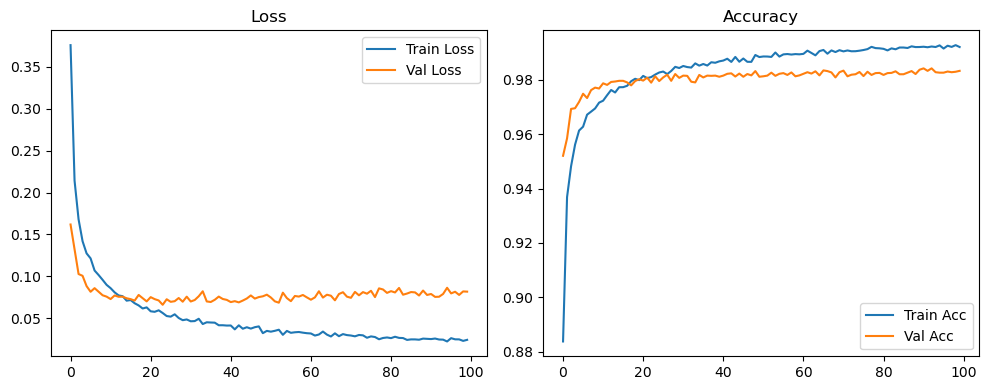

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2270, Acc: 0.9294 | Val Loss: 0.1337, Acc: 0.9597


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1050, Acc: 0.9671 | Val Loss: 0.1103, Acc: 0.9674


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9770 | Val Loss: 0.1123, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9816 | Val Loss: 0.1155, Acc: 0.9676


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.0924, Acc: 0.9742


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9881 | Val Loss: 0.0882, Acc: 0.9743


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.1027, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9907 | Val Loss: 0.1042, Acc: 0.9753


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0939, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9932 | Val Loss: 0.1039, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.0934, Acc: 0.9776


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1094, Acc: 0.9747


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0932, Acc: 0.9785


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1113, Acc: 0.9747


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1035, Acc: 0.9772


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1095, Acc: 0.9784


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.0935, Acc: 0.9802


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0985, Acc: 0.9793


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.1048, Acc: 0.9788


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1147, Acc: 0.9798


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1034, Acc: 0.9787


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1258, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1033, Acc: 0.9797


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1070, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0997, Acc: 0.9809


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1081, Acc: 0.9799


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1027, Acc: 0.9793


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1127, Acc: 0.9781


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1059, Acc: 0.9808


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1044, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1069, Acc: 0.9810


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0997, Acc: 0.9809


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1117, Acc: 0.9790


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1069, Acc: 0.9804


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1223, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1122, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1005, Acc: 0.9818


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1000, Acc: 0.9829


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0992, Acc: 0.9830


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1199, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1097, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1091, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1184, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1043, Acc: 0.9828


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1004, Acc: 0.9833


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1028, Acc: 0.9819


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1059, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1083, Acc: 0.9809


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1084, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1093, Acc: 0.9818


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0965, Acc: 0.9837


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0966, Acc: 0.9847


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0980, Acc: 0.9837


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0969, Acc: 0.9843


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0968, Acc: 0.9844


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0980, Acc: 0.9845


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1024, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0975, Acc: 0.9842


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0985, Acc: 0.9859


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0976, Acc: 0.9854


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1094, Acc: 0.9846


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1326, Acc: 0.9825


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1298, Acc: 0.9811


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1143, Acc: 0.9836


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1145, Acc: 0.9811


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1077, Acc: 0.9838


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1161, Acc: 0.9832


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1087, Acc: 0.9838


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1106, Acc: 0.9832


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1197, Acc: 0.9832


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1197, Acc: 0.9817


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1207, Acc: 0.9823


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1218, Acc: 0.9810


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1168, Acc: 0.9826


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1116, Acc: 0.9822


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1114, Acc: 0.9825


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1247, Acc: 0.9822


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1247, Acc: 0.9823


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1287, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1176, Acc: 0.9833


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1146, Acc: 0.9838


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1116, Acc: 0.9835


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1142, Acc: 0.9840


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1130, Acc: 0.9844


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1128, Acc: 0.9842


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1165, Acc: 0.9842


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1134, Acc: 0.9842


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1174, Acc: 0.9842


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1180, Acc: 0.9840


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1157, Acc: 0.9843


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1199, Acc: 0.9842


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1175, Acc: 0.9841


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1185, Acc: 0.9844


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1171, Acc: 0.9847


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1187, Acc: 0.9846


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1161, Acc: 0.9851


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1191, Acc: 0.9846


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1212, Acc: 0.9845


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1243, Acc: 0.9837


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1222, Acc: 0.9841


Final Test Loss: 0.1212 Accuracy: 0.9852


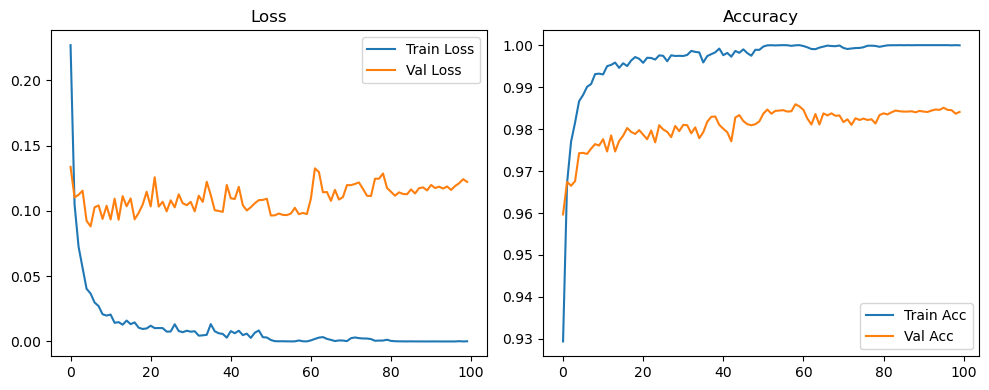

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2598, Acc: 0.9195 | Val Loss: 0.1341, Acc: 0.9595


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1334, Acc: 0.9592 | Val Loss: 0.1131, Acc: 0.9636


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9686 | Val Loss: 0.0991, Acc: 0.9707


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9747 | Val Loss: 0.0920, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9801 | Val Loss: 0.0889, Acc: 0.9743


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9813 | Val Loss: 0.0829, Acc: 0.9746


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9839 | Val Loss: 0.0811, Acc: 0.9753


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.0735, Acc: 0.9796


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0791, Acc: 0.9784


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.0839, Acc: 0.9775


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0818, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9890 | Val Loss: 0.0795, Acc: 0.9787


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.0884, Acc: 0.9786


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0839, Acc: 0.9786


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.0861, Acc: 0.9791


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.0871, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.0857, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0891, Acc: 0.9793


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9924 | Val Loss: 0.0874, Acc: 0.9775


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0789, Acc: 0.9822


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0926, Acc: 0.9796


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0839, Acc: 0.9792


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0827, Acc: 0.9810


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0908, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0951, Acc: 0.9793


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0873, Acc: 0.9820


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0840, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0907, Acc: 0.9819


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0882, Acc: 0.9825


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0959, Acc: 0.9797


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.0921, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0944, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0883, Acc: 0.9817


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0917, Acc: 0.9801


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0919, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0882, Acc: 0.9818


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0815, Acc: 0.9824


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0959, Acc: 0.9804


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0913, Acc: 0.9813


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0856, Acc: 0.9816


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0899, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0804, Acc: 0.9832


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0929, Acc: 0.9802


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0913, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0865, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0864, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0919, Acc: 0.9813


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0942, Acc: 0.9820


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0955, Acc: 0.9809


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0908, Acc: 0.9818


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0787, Acc: 0.9843


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0789, Acc: 0.9845


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0816, Acc: 0.9849


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0815, Acc: 0.9849


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0878, Acc: 0.9844


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0939, Acc: 0.9830


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0903, Acc: 0.9848


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0935, Acc: 0.9838


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0947, Acc: 0.9842


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0991, Acc: 0.9849


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0966, Acc: 0.9842


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0914, Acc: 0.9843


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1006, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0956, Acc: 0.9850


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1013, Acc: 0.9838


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0999, Acc: 0.9828


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1120, Acc: 0.9828


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1015, Acc: 0.9831


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0918, Acc: 0.9842


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0916, Acc: 0.9842


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0914, Acc: 0.9840


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0970, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0993, Acc: 0.9835


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0992, Acc: 0.9840


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0989, Acc: 0.9831


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1077, Acc: 0.9829


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1071, Acc: 0.9827


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1036, Acc: 0.9825


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1053, Acc: 0.9833


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1055, Acc: 0.9834


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1015, Acc: 0.9842


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0975, Acc: 0.9846


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0997, Acc: 0.9836


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1014, Acc: 0.9844


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0986, Acc: 0.9852


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0990, Acc: 0.9848


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0959, Acc: 0.9858


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1009, Acc: 0.9849


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1018, Acc: 0.9848


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1001, Acc: 0.9852


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1024, Acc: 0.9848


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1045, Acc: 0.9842


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1046, Acc: 0.9852


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1001, Acc: 0.9849


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1041, Acc: 0.9845


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1042, Acc: 0.9849


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1036, Acc: 0.9846


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1036, Acc: 0.9848


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1014, Acc: 0.9838


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1004, Acc: 0.9838


Final Test Loss: 0.0851 Accuracy: 0.9865


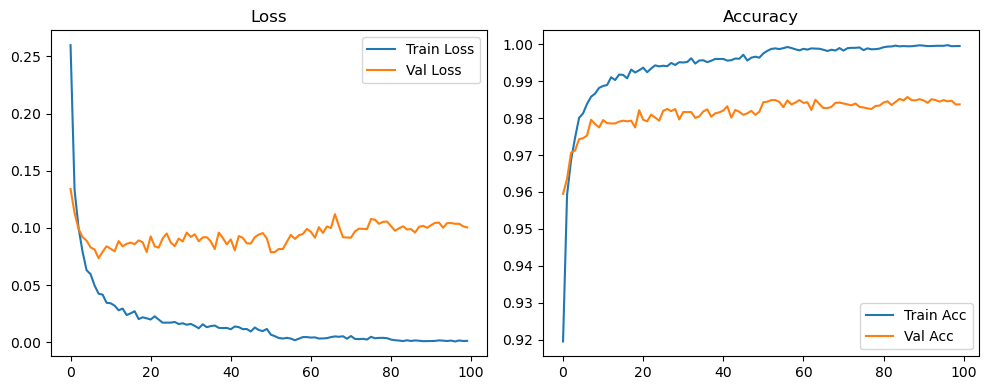

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3761, Acc: 0.8838 | Val Loss: 0.1618, Acc: 0.9521


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2142, Acc: 0.9369 | Val Loss: 0.1323, Acc: 0.9585


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1681, Acc: 0.9482 | Val Loss: 0.1027, Acc: 0.9693


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1419, Acc: 0.9562 | Val Loss: 0.1005, Acc: 0.9696


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9614 | Val Loss: 0.0883, Acc: 0.9719


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9628 | Val Loss: 0.0815, Acc: 0.9749


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9672 | Val Loss: 0.0858, Acc: 0.9733


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9683 | Val Loss: 0.0816, Acc: 0.9762


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9695 | Val Loss: 0.0773, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9716 | Val Loss: 0.0757, Acc: 0.9768


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9724 | Val Loss: 0.0728, Acc: 0.9788


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9744 | Val Loss: 0.0771, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9763 | Val Loss: 0.0755, Acc: 0.9792


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9754 | Val Loss: 0.0756, Acc: 0.9794


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9773 | Val Loss: 0.0737, Acc: 0.9797


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9773 | Val Loss: 0.0727, Acc: 0.9797


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9778 | Val Loss: 0.0710, Acc: 0.9791


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9795 | Val Loss: 0.0777, Acc: 0.9780


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9804 | Val Loss: 0.0738, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9799 | Val Loss: 0.0700, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9815 | Val Loss: 0.0751, Acc: 0.9798


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9807 | Val Loss: 0.0727, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9810 | Val Loss: 0.0711, Acc: 0.9790


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 0.0659, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9827 | Val Loss: 0.0725, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9831 | Val Loss: 0.0695, Acc: 0.9809


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.0702, Acc: 0.9819


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9833 | Val Loss: 0.0740, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.0696, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9844 | Val Loss: 0.0756, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 0.0699, Acc: 0.9816


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9847 | Val Loss: 0.0717, Acc: 0.9815


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9845 | Val Loss: 0.0761, Acc: 0.9793


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0821, Acc: 0.9791


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9852 | Val Loss: 0.0700, Acc: 0.9818


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 0.0693, Acc: 0.9809


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9853 | Val Loss: 0.0719, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9865 | Val Loss: 0.0757, Acc: 0.9815


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9863 | Val Loss: 0.0729, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9868 | Val Loss: 0.0718, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9871 | Val Loss: 0.0692, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9878 | Val Loss: 0.0703, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 0.0688, Acc: 0.9824


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9885 | Val Loss: 0.0710, Acc: 0.9812


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9867 | Val Loss: 0.0734, Acc: 0.9823


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0771, Acc: 0.9812


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9867 | Val Loss: 0.0734, Acc: 0.9822


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 0.0752, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9892 | Val Loss: 0.0761, Acc: 0.9832


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.0780, Acc: 0.9812


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0691, Acc: 0.9828


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0688, Acc: 0.9833


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 0.0676, Acc: 0.9834


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9930 | Val Loss: 0.0734, Acc: 0.9828


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0726, Acc: 0.9834


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9924 | Val Loss: 0.0705, Acc: 0.9839


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0700, Acc: 0.9840


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0698, Acc: 0.9834


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0723, Acc: 0.9832


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9922 | Val Loss: 0.0730, Acc: 0.9825


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.0744, Acc: 0.9833


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0766, Acc: 0.9832


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.0771, Acc: 0.9829


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0725, Acc: 0.9841


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0787, Acc: 0.9821


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.0784, Acc: 0.9825


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0785, Acc: 0.9824


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0788, Acc: 0.9839


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0776, Acc: 0.9833


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0778, Acc: 0.9837


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0758, Acc: 0.9833


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0797, Acc: 0.9837


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0797, Acc: 0.9829


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0776, Acc: 0.9835


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0759, Acc: 0.9843


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0785, Acc: 0.9833


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.0754, Acc: 0.9832


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0816, Acc: 0.9833


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0768, Acc: 0.9831


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9932 | Val Loss: 0.0766, Acc: 0.9833


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0753, Acc: 0.9832


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0759, Acc: 0.9842


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0777, Acc: 0.9836


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0764, Acc: 0.9848


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0747, Acc: 0.9842


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0743, Acc: 0.9836


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0764, Acc: 0.9835


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0796, Acc: 0.9836


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0810, Acc: 0.9838


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0825, Acc: 0.9837


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0840, Acc: 0.9831


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0810, Acc: 0.9832


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0804, Acc: 0.9843


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0801, Acc: 0.9834


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0805, Acc: 0.9840


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9961 | Val Loss: 0.0801, Acc: 0.9837


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0831, Acc: 0.9833


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0801, Acc: 0.9843


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0826, Acc: 0.9831


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0845, Acc: 0.9837


Final Test Loss: 0.0732 Accuracy: 0.9847


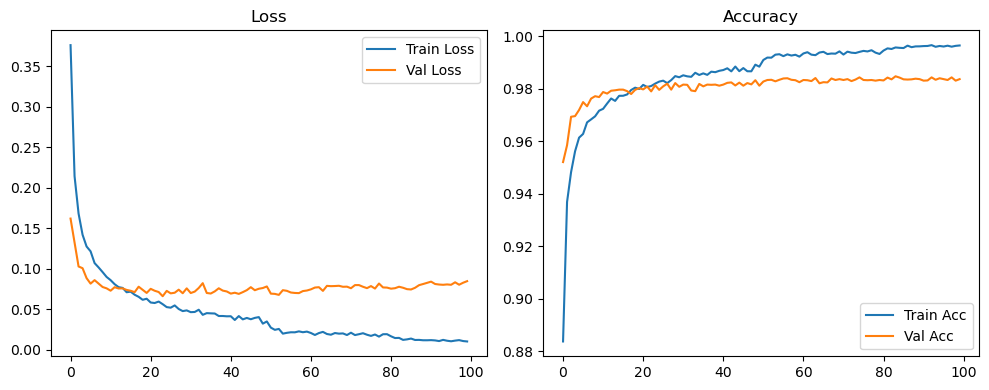

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2270, Acc: 0.9294 | Val Loss: 0.1337, Acc: 0.9597


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1050, Acc: 0.9671 | Val Loss: 0.1103, Acc: 0.9674


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9770 | Val Loss: 0.1123, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9816 | Val Loss: 0.1155, Acc: 0.9676


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.0924, Acc: 0.9742


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9881 | Val Loss: 0.0882, Acc: 0.9743


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.1027, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9907 | Val Loss: 0.1042, Acc: 0.9753


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0939, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9932 | Val Loss: 0.1039, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.0934, Acc: 0.9776


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1094, Acc: 0.9747


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0932, Acc: 0.9785


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1113, Acc: 0.9747


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1035, Acc: 0.9772


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1095, Acc: 0.9784


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.0935, Acc: 0.9802


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0985, Acc: 0.9793


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.1048, Acc: 0.9788


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1147, Acc: 0.9798


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1034, Acc: 0.9787


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1258, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1033, Acc: 0.9797


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1070, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0997, Acc: 0.9809


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1081, Acc: 0.9799


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1027, Acc: 0.9793


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1127, Acc: 0.9781


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1059, Acc: 0.9808


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1044, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1069, Acc: 0.9810


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0997, Acc: 0.9809


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1117, Acc: 0.9790


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1069, Acc: 0.9804


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1223, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1122, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1005, Acc: 0.9818


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1000, Acc: 0.9829


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0992, Acc: 0.9830


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1199, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1097, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1091, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1184, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1043, Acc: 0.9828


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1004, Acc: 0.9833


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1028, Acc: 0.9819


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1059, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1083, Acc: 0.9809


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1084, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1093, Acc: 0.9818


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0965, Acc: 0.9837


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0966, Acc: 0.9847


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0980, Acc: 0.9837


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0969, Acc: 0.9843


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0968, Acc: 0.9844


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0980, Acc: 0.9845


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1024, Acc: 0.9842


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0975, Acc: 0.9842


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0985, Acc: 0.9859


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0976, Acc: 0.9854


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1094, Acc: 0.9846


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1326, Acc: 0.9825


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1298, Acc: 0.9811


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1143, Acc: 0.9836


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1145, Acc: 0.9811


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1077, Acc: 0.9838


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1161, Acc: 0.9832


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1087, Acc: 0.9838


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1106, Acc: 0.9832


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1197, Acc: 0.9832


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1197, Acc: 0.9817


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1207, Acc: 0.9823


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1218, Acc: 0.9810


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1168, Acc: 0.9826


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1116, Acc: 0.9822


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1114, Acc: 0.9825


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1247, Acc: 0.9822


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1247, Acc: 0.9823


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1287, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1176, Acc: 0.9833


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1150, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1137, Acc: 0.9835


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1147, Acc: 0.9841


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1133, Acc: 0.9840


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1134, Acc: 0.9839


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1151, Acc: 0.9836


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1122, Acc: 0.9842


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1145, Acc: 0.9833


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1151, Acc: 0.9836


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1126, Acc: 0.9839


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1154, Acc: 0.9839


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1142, Acc: 0.9837


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1145, Acc: 0.9840


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1132, Acc: 0.9841


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1138, Acc: 0.9841


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1121, Acc: 0.9842


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1144, Acc: 0.9844


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1134, Acc: 0.9843


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1172, Acc: 0.9835


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1167, Acc: 0.9836


Final Test Loss: 0.1118 Accuracy: 0.9847


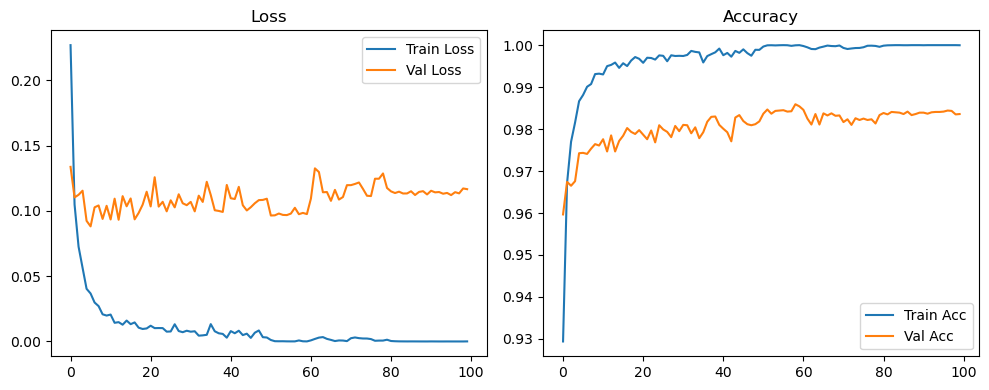

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2598, Acc: 0.9195 | Val Loss: 0.1341, Acc: 0.9595


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1334, Acc: 0.9592 | Val Loss: 0.1131, Acc: 0.9636


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9686 | Val Loss: 0.0991, Acc: 0.9707


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9747 | Val Loss: 0.0920, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9801 | Val Loss: 0.0889, Acc: 0.9743


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9813 | Val Loss: 0.0829, Acc: 0.9746


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9839 | Val Loss: 0.0811, Acc: 0.9753


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.0735, Acc: 0.9796


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0791, Acc: 0.9784


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.0839, Acc: 0.9775


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0818, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9890 | Val Loss: 0.0795, Acc: 0.9787


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.0884, Acc: 0.9786


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0839, Acc: 0.9786


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.0861, Acc: 0.9791


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.0871, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.0857, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0891, Acc: 0.9793


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9924 | Val Loss: 0.0874, Acc: 0.9775


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0789, Acc: 0.9822


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0926, Acc: 0.9796


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0839, Acc: 0.9792


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0827, Acc: 0.9810


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0908, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0951, Acc: 0.9793


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0873, Acc: 0.9820


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0840, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0907, Acc: 0.9819


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0882, Acc: 0.9825


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0959, Acc: 0.9797


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.0921, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0944, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0883, Acc: 0.9817


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0917, Acc: 0.9801


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0919, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0882, Acc: 0.9818


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0815, Acc: 0.9824


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0959, Acc: 0.9804


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0913, Acc: 0.9813


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0856, Acc: 0.9816


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0899, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0804, Acc: 0.9832


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0929, Acc: 0.9802


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0913, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0865, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0864, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0919, Acc: 0.9813


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0942, Acc: 0.9820


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0955, Acc: 0.9809


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0908, Acc: 0.9818


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0787, Acc: 0.9843


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0789, Acc: 0.9845


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0816, Acc: 0.9849


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0815, Acc: 0.9849


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0878, Acc: 0.9844


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0939, Acc: 0.9830


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0903, Acc: 0.9848


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0935, Acc: 0.9838


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0947, Acc: 0.9842


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0991, Acc: 0.9849


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0966, Acc: 0.9842


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0914, Acc: 0.9843


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1006, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0956, Acc: 0.9850


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1013, Acc: 0.9838


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0999, Acc: 0.9828


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1120, Acc: 0.9828


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1015, Acc: 0.9831


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0918, Acc: 0.9842


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0916, Acc: 0.9842


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0914, Acc: 0.9840


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0970, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0993, Acc: 0.9835


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0992, Acc: 0.9840


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0989, Acc: 0.9831


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1077, Acc: 0.9829


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1071, Acc: 0.9827


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1036, Acc: 0.9825


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1053, Acc: 0.9833


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1055, Acc: 0.9834


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1026, Acc: 0.9843


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0997, Acc: 0.9847


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0992, Acc: 0.9841


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0989, Acc: 0.9847


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0974, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0985, Acc: 0.9845


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0962, Acc: 0.9852


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0986, Acc: 0.9846


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0987, Acc: 0.9845


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0982, Acc: 0.9848


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0993, Acc: 0.9843


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1006, Acc: 0.9836


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0993, Acc: 0.9841


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0991, Acc: 0.9839


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1015, Acc: 0.9842


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1019, Acc: 0.9843


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1001, Acc: 0.9847


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1005, Acc: 0.9849


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0974, Acc: 0.9850


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0974, Acc: 0.9848


Final Test Loss: 0.0770 Accuracy: 0.9876


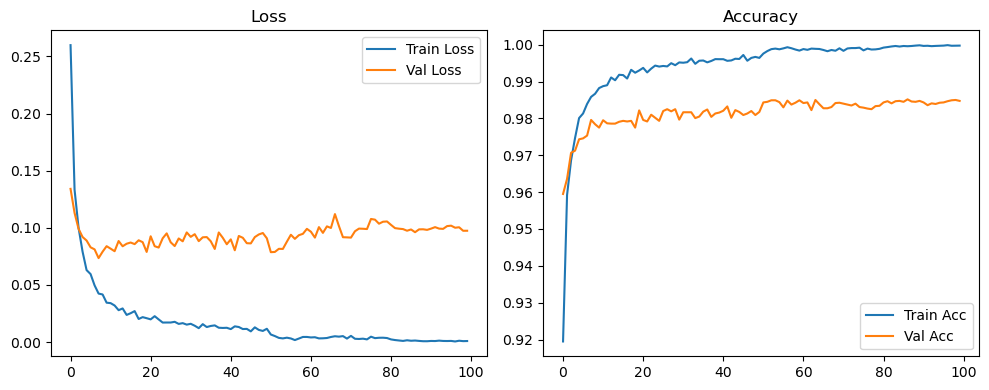

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3761, Acc: 0.8838 | Val Loss: 0.1618, Acc: 0.9521


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2142, Acc: 0.9369 | Val Loss: 0.1323, Acc: 0.9585


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1681, Acc: 0.9482 | Val Loss: 0.1027, Acc: 0.9693


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1419, Acc: 0.9562 | Val Loss: 0.1005, Acc: 0.9696


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9614 | Val Loss: 0.0883, Acc: 0.9719


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9628 | Val Loss: 0.0815, Acc: 0.9749


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9672 | Val Loss: 0.0858, Acc: 0.9733


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9683 | Val Loss: 0.0816, Acc: 0.9762


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9695 | Val Loss: 0.0773, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9716 | Val Loss: 0.0757, Acc: 0.9768


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9724 | Val Loss: 0.0728, Acc: 0.9788


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9744 | Val Loss: 0.0771, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9763 | Val Loss: 0.0755, Acc: 0.9792


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9754 | Val Loss: 0.0756, Acc: 0.9794


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9773 | Val Loss: 0.0737, Acc: 0.9797


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9773 | Val Loss: 0.0727, Acc: 0.9797


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9778 | Val Loss: 0.0710, Acc: 0.9791


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9795 | Val Loss: 0.0777, Acc: 0.9780


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9804 | Val Loss: 0.0738, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9799 | Val Loss: 0.0700, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9815 | Val Loss: 0.0751, Acc: 0.9798


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9807 | Val Loss: 0.0727, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9810 | Val Loss: 0.0711, Acc: 0.9790


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 0.0659, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9827 | Val Loss: 0.0725, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9831 | Val Loss: 0.0695, Acc: 0.9809


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.0702, Acc: 0.9819


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9833 | Val Loss: 0.0740, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.0696, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9844 | Val Loss: 0.0756, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 0.0699, Acc: 0.9816


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9847 | Val Loss: 0.0717, Acc: 0.9815


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9845 | Val Loss: 0.0761, Acc: 0.9793


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0821, Acc: 0.9791


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9852 | Val Loss: 0.0700, Acc: 0.9818


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 0.0693, Acc: 0.9809


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9853 | Val Loss: 0.0719, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9865 | Val Loss: 0.0757, Acc: 0.9815


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9863 | Val Loss: 0.0729, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9868 | Val Loss: 0.0718, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9871 | Val Loss: 0.0692, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9878 | Val Loss: 0.0703, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 0.0688, Acc: 0.9824


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9885 | Val Loss: 0.0710, Acc: 0.9812


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9867 | Val Loss: 0.0734, Acc: 0.9823


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0771, Acc: 0.9812


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9867 | Val Loss: 0.0734, Acc: 0.9822


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 0.0752, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9892 | Val Loss: 0.0761, Acc: 0.9832


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.0780, Acc: 0.9812


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.0691, Acc: 0.9828


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0688, Acc: 0.9833


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 0.0676, Acc: 0.9834


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9930 | Val Loss: 0.0734, Acc: 0.9828


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0726, Acc: 0.9834


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9924 | Val Loss: 0.0705, Acc: 0.9839


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.0700, Acc: 0.9840


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0698, Acc: 0.9834


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0723, Acc: 0.9832


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9922 | Val Loss: 0.0730, Acc: 0.9825


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.0744, Acc: 0.9833


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0766, Acc: 0.9832


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.0771, Acc: 0.9829


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0725, Acc: 0.9841


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0787, Acc: 0.9821


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.0784, Acc: 0.9825


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0785, Acc: 0.9824


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0788, Acc: 0.9839


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0776, Acc: 0.9833


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0778, Acc: 0.9837


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0758, Acc: 0.9833


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0797, Acc: 0.9837


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0797, Acc: 0.9829


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9936 | Val Loss: 0.0776, Acc: 0.9835


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0759, Acc: 0.9843


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0785, Acc: 0.9833


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.0754, Acc: 0.9832


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0816, Acc: 0.9833


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0768, Acc: 0.9831


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9932 | Val Loss: 0.0766, Acc: 0.9833


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.0745, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.0746, Acc: 0.9845


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0763, Acc: 0.9837


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0752, Acc: 0.9842


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0741, Acc: 0.9842


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0730, Acc: 0.9837


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.0744, Acc: 0.9837


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9958 | Val Loss: 0.0768, Acc: 0.9842


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0775, Acc: 0.9839


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0782, Acc: 0.9843


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0793, Acc: 0.9832


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0782, Acc: 0.9837


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0776, Acc: 0.9848


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0775, Acc: 0.9847


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0786, Acc: 0.9843


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0778, Acc: 0.9838


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0806, Acc: 0.9835


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0788, Acc: 0.9843


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0800, Acc: 0.9844


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9966 | Val Loss: 0.0812, Acc: 0.9842


Final Test Loss: 0.0723 Accuracy: 0.9851


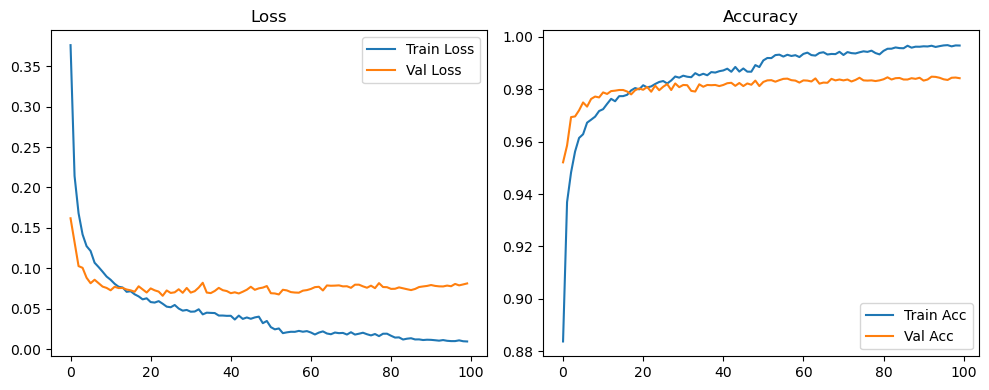

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2270, Acc: 0.9294 | Val Loss: 0.1337, Acc: 0.9597


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1050, Acc: 0.9671 | Val Loss: 0.1103, Acc: 0.9674


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0726, Acc: 0.9770 | Val Loss: 0.1123, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9816 | Val Loss: 0.1155, Acc: 0.9676


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.0924, Acc: 0.9742


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9881 | Val Loss: 0.0882, Acc: 0.9743


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.1027, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9907 | Val Loss: 0.1042, Acc: 0.9753


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0939, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9932 | Val Loss: 0.1039, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.0934, Acc: 0.9776


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1094, Acc: 0.9747


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9953 | Val Loss: 0.0932, Acc: 0.9785


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1113, Acc: 0.9747


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1035, Acc: 0.9772


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.1095, Acc: 0.9784


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.0935, Acc: 0.9802


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0985, Acc: 0.9793


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.1048, Acc: 0.9788


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1147, Acc: 0.9798


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1034, Acc: 0.9787


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1258, Acc: 0.9776


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1033, Acc: 0.9797


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1070, Acc: 0.9768


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0997, Acc: 0.9809


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1081, Acc: 0.9799


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9962 | Val Loss: 0.1027, Acc: 0.9793


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1127, Acc: 0.9781


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.1059, Acc: 0.9808


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1044, Acc: 0.9795


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1069, Acc: 0.9810


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0997, Acc: 0.9809


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1117, Acc: 0.9790


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1069, Acc: 0.9804


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1223, Acc: 0.9778


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.1122, Acc: 0.9792


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1005, Acc: 0.9818


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1000, Acc: 0.9829


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0992, Acc: 0.9830


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1199, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1097, Acc: 0.9801


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1091, Acc: 0.9792


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1184, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1043, Acc: 0.9828


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1004, Acc: 0.9833


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1028, Acc: 0.9819


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1059, Acc: 0.9812


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1083, Acc: 0.9809


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1084, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1093, Acc: 0.9818


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0959, Acc: 0.9836


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0942, Acc: 0.9841


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0945, Acc: 0.9834


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0946, Acc: 0.9842


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0929, Acc: 0.9847


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0931, Acc: 0.9844


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0945, Acc: 0.9847


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0940, Acc: 0.9847


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0950, Acc: 0.9853


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0948, Acc: 0.9851


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0947, Acc: 0.9854


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0966, Acc: 0.9855


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0975, Acc: 0.9852


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0970, Acc: 0.9854


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0987, Acc: 0.9850


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0981, Acc: 0.9851


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1010, Acc: 0.9848


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1027, Acc: 0.9851


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1018, Acc: 0.9852


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1040, Acc: 0.9848


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1028, Acc: 0.9854


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1093, Acc: 0.9850


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1088, Acc: 0.9856


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1056, Acc: 0.9854


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1080, Acc: 0.9855


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1084, Acc: 0.9856


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1150, Acc: 0.9845


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1207, Acc: 0.9838


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1199, Acc: 0.9841


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1164, Acc: 0.9848


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1172, Acc: 0.9848


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1140, Acc: 0.9848


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1150, Acc: 0.9849


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1164, Acc: 0.9852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1133, Acc: 0.9850


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1151, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1135, Acc: 0.9854


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1149, Acc: 0.9849


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1152, Acc: 0.9852


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1120, Acc: 0.9858


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1149, Acc: 0.9852


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1152, Acc: 0.9850


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1144, Acc: 0.9858


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1137, Acc: 0.9858


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1114, Acc: 0.9858


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1131, Acc: 0.9854


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1157, Acc: 0.9858


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1128, Acc: 0.9860


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1220, Acc: 0.9851


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1200, Acc: 0.9852


Final Test Loss: 0.1172 Accuracy: 0.9862


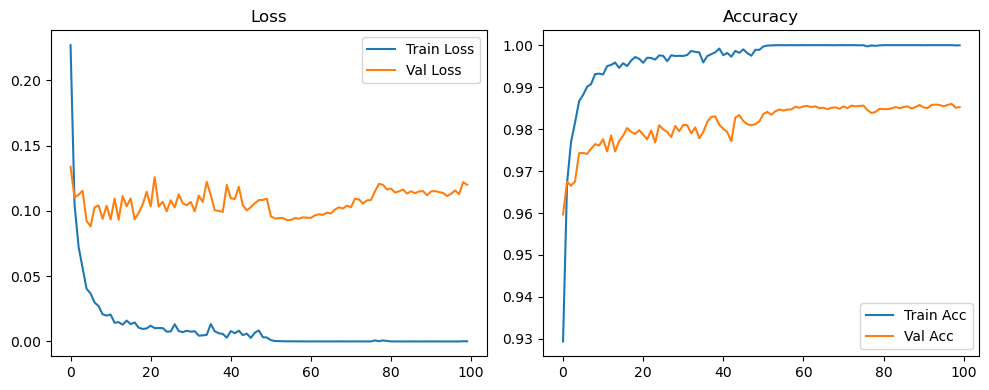

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2598, Acc: 0.9195 | Val Loss: 0.1341, Acc: 0.9595


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1334, Acc: 0.9592 | Val Loss: 0.1131, Acc: 0.9636


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1000, Acc: 0.9686 | Val Loss: 0.0991, Acc: 0.9707


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0791, Acc: 0.9747 | Val Loss: 0.0920, Acc: 0.9712


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9801 | Val Loss: 0.0889, Acc: 0.9743


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9813 | Val Loss: 0.0829, Acc: 0.9746


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0496, Acc: 0.9839 | Val Loss: 0.0811, Acc: 0.9753


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9858 | Val Loss: 0.0735, Acc: 0.9796


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9867 | Val Loss: 0.0791, Acc: 0.9784


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.0839, Acc: 0.9775


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0818, Acc: 0.9795


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9890 | Val Loss: 0.0795, Acc: 0.9787


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9911 | Val Loss: 0.0884, Acc: 0.9786


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9904 | Val Loss: 0.0839, Acc: 0.9786


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.0861, Acc: 0.9791


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.0871, Acc: 0.9793


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.0857, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0891, Acc: 0.9793


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9924 | Val Loss: 0.0874, Acc: 0.9775


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.0789, Acc: 0.9822


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9937 | Val Loss: 0.0926, Acc: 0.9796


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.0839, Acc: 0.9792


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0827, Acc: 0.9810


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0908, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0951, Acc: 0.9793


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0873, Acc: 0.9820


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0840, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.0907, Acc: 0.9819


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0882, Acc: 0.9825


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0959, Acc: 0.9797


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.0921, Acc: 0.9817


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.0944, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0883, Acc: 0.9817


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0917, Acc: 0.9801


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0919, Acc: 0.9805


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0882, Acc: 0.9818


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0815, Acc: 0.9824


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0959, Acc: 0.9804


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0913, Acc: 0.9813


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0856, Acc: 0.9816


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0899, Acc: 0.9821


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0804, Acc: 0.9832


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0929, Acc: 0.9802


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0913, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0865, Acc: 0.9818


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9972 | Val Loss: 0.0864, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0919, Acc: 0.9813


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0942, Acc: 0.9820


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0955, Acc: 0.9809


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0908, Acc: 0.9818


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.0792, Acc: 0.9842


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.0770, Acc: 0.9846


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0760, Acc: 0.9854


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0779, Acc: 0.9848


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0771, Acc: 0.9850


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0797, Acc: 0.9852


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0810, Acc: 0.9855


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0797, Acc: 0.9852


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0824, Acc: 0.9854


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0824, Acc: 0.9853


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0848, Acc: 0.9852


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0839, Acc: 0.9861


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.0849, Acc: 0.9859


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0871, Acc: 0.9860


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0901, Acc: 0.9854


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0904, Acc: 0.9852


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0891, Acc: 0.9848


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0920, Acc: 0.9846


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0913, Acc: 0.9852


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0918, Acc: 0.9861


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0917, Acc: 0.9858


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0984, Acc: 0.9852


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0979, Acc: 0.9850


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0995, Acc: 0.9846


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0962, Acc: 0.9858


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0984, Acc: 0.9856


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1008, Acc: 0.9860


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1009, Acc: 0.9848


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1042, Acc: 0.9832


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0997, Acc: 0.9846


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0991, Acc: 0.9855


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0996, Acc: 0.9857


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1001, Acc: 0.9855


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1020, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1018, Acc: 0.9857


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1041, Acc: 0.9856


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0985, Acc: 0.9863


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1011, Acc: 0.9857


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1002, Acc: 0.9856


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1008, Acc: 0.9858


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1015, Acc: 0.9858


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1011, Acc: 0.9854


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1030, Acc: 0.9858


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1028, Acc: 0.9865


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1052, Acc: 0.9854


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.1041, Acc: 0.9858


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1026, Acc: 0.9861


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1001, Acc: 0.9853


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0984, Acc: 0.9859


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.0978, Acc: 0.9858


Final Test Loss: 0.0896 Accuracy: 0.9863


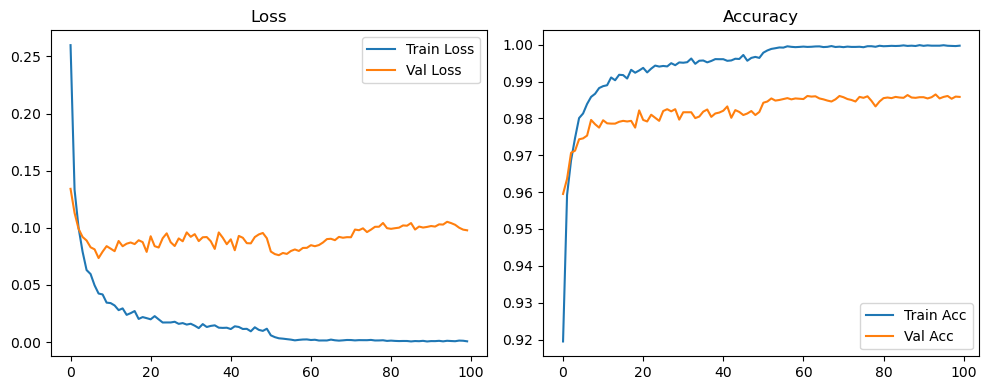

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3761, Acc: 0.8838 | Val Loss: 0.1618, Acc: 0.9521


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2142, Acc: 0.9369 | Val Loss: 0.1323, Acc: 0.9585


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1681, Acc: 0.9482 | Val Loss: 0.1027, Acc: 0.9693


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1419, Acc: 0.9562 | Val Loss: 0.1005, Acc: 0.9696


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9614 | Val Loss: 0.0883, Acc: 0.9719


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1214, Acc: 0.9628 | Val Loss: 0.0815, Acc: 0.9749


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9672 | Val Loss: 0.0858, Acc: 0.9733


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1015, Acc: 0.9683 | Val Loss: 0.0816, Acc: 0.9762


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9695 | Val Loss: 0.0773, Acc: 0.9772


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0897, Acc: 0.9716 | Val Loss: 0.0757, Acc: 0.9768


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9724 | Val Loss: 0.0728, Acc: 0.9788


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9744 | Val Loss: 0.0771, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9763 | Val Loss: 0.0755, Acc: 0.9792


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9754 | Val Loss: 0.0756, Acc: 0.9794


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0709, Acc: 0.9773 | Val Loss: 0.0737, Acc: 0.9797


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0716, Acc: 0.9773 | Val Loss: 0.0727, Acc: 0.9797


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0678, Acc: 0.9778 | Val Loss: 0.0710, Acc: 0.9791


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0652, Acc: 0.9795 | Val Loss: 0.0777, Acc: 0.9780


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0615, Acc: 0.9804 | Val Loss: 0.0738, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0628, Acc: 0.9799 | Val Loss: 0.0700, Acc: 0.9802


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0582, Acc: 0.9815 | Val Loss: 0.0751, Acc: 0.9798


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9807 | Val Loss: 0.0727, Acc: 0.9808


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0593, Acc: 0.9810 | Val Loss: 0.0711, Acc: 0.9790


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0561, Acc: 0.9820 | Val Loss: 0.0659, Acc: 0.9813


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9827 | Val Loss: 0.0725, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0518, Acc: 0.9831 | Val Loss: 0.0695, Acc: 0.9809


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.0702, Acc: 0.9819


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9833 | Val Loss: 0.0740, Acc: 0.9797


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0476, Acc: 0.9848 | Val Loss: 0.0696, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0484, Acc: 0.9844 | Val Loss: 0.0756, Acc: 0.9808


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9851 | Val Loss: 0.0699, Acc: 0.9816


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9847 | Val Loss: 0.0717, Acc: 0.9815


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9845 | Val Loss: 0.0761, Acc: 0.9793


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0821, Acc: 0.9791


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0451, Acc: 0.9852 | Val Loss: 0.0700, Acc: 0.9818


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 0.0693, Acc: 0.9809


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9853 | Val Loss: 0.0719, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9865 | Val Loss: 0.0757, Acc: 0.9815


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9863 | Val Loss: 0.0729, Acc: 0.9816


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9868 | Val Loss: 0.0718, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9871 | Val Loss: 0.0692, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9878 | Val Loss: 0.0703, Acc: 0.9822


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9866 | Val Loss: 0.0688, Acc: 0.9824


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0374, Acc: 0.9885 | Val Loss: 0.0710, Acc: 0.9812


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9867 | Val Loss: 0.0734, Acc: 0.9823


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9879 | Val Loss: 0.0771, Acc: 0.9812


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9867 | Val Loss: 0.0734, Acc: 0.9822


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 0.0752, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9892 | Val Loss: 0.0761, Acc: 0.9832


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.0780, Acc: 0.9812


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.0701, Acc: 0.9826


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.0699, Acc: 0.9833


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0687, Acc: 0.9831


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9934 | Val Loss: 0.0690, Acc: 0.9833


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0691, Acc: 0.9835


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.0677, Acc: 0.9838


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0678, Acc: 0.9842


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.0685, Acc: 0.9832


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.0702, Acc: 0.9834


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0720, Acc: 0.9835


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9939 | Val Loss: 0.0725, Acc: 0.9839


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0732, Acc: 0.9839


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0740, Acc: 0.9828


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0702, Acc: 0.9838


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0737, Acc: 0.9832


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0743, Acc: 0.9838


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0752, Acc: 0.9832


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9948 | Val Loss: 0.0736, Acc: 0.9843


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.0743, Acc: 0.9842


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0757, Acc: 0.9845


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9950 | Val Loss: 0.0751, Acc: 0.9838


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0770, Acc: 0.9842


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0761, Acc: 0.9839


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0748, Acc: 0.9840


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9953 | Val Loss: 0.0739, Acc: 0.9842


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0751, Acc: 0.9838


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0759, Acc: 0.9837


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0778, Acc: 0.9838


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0764, Acc: 0.9839


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9952 | Val Loss: 0.0774, Acc: 0.9836


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.0755, Acc: 0.9837


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0760, Acc: 0.9845


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0790, Acc: 0.9838


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0757, Acc: 0.9844


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0753, Acc: 0.9837


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0745, Acc: 0.9839


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0762, Acc: 0.9841


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0780, Acc: 0.9842


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0778, Acc: 0.9838


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0784, Acc: 0.9842


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0795, Acc: 0.9837


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.0783, Acc: 0.9843


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0763, Acc: 0.9847


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0762, Acc: 0.9846


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0769, Acc: 0.9842


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.0787, Acc: 0.9834


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0804, Acc: 0.9840


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0785, Acc: 0.9845


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0807, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9960 | Val Loss: 0.0819, Acc: 0.9837


Final Test Loss: 0.0715 Accuracy: 0.9854


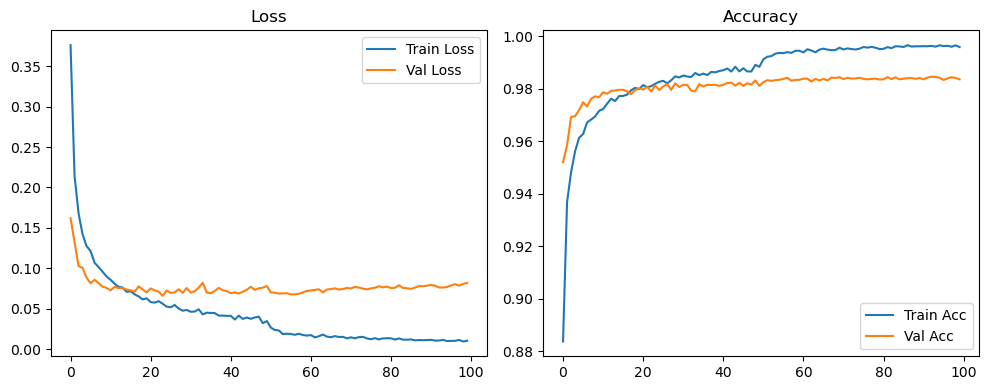

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2158, Acc: 0.9339 | Val Loss: 0.1346, Acc: 0.9601


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0992, Acc: 0.9689 | Val Loss: 0.1056, Acc: 0.9686


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0694, Acc: 0.9781 | Val Loss: 0.1017, Acc: 0.9693


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9828 | Val Loss: 0.1059, Acc: 0.9684


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9879 | Val Loss: 0.0917, Acc: 0.9725


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9884 | Val Loss: 0.0864, Acc: 0.9754


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9897 | Val Loss: 0.1031, Acc: 0.9724


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.0850, Acc: 0.9778


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.1011, Acc: 0.9757


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0996, Acc: 0.9752


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0978, Acc: 0.9769


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0899, Acc: 0.9800


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1015, Acc: 0.9763


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9961 | Val Loss: 0.0991, Acc: 0.9776


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1051, Acc: 0.9770


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0999, Acc: 0.9803


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1016, Acc: 0.9772


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1041, Acc: 0.9775


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0940, Acc: 0.9805


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0913, Acc: 0.9792


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0946, Acc: 0.9802


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0921, Acc: 0.9802


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1006, Acc: 0.9806


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0985, Acc: 0.9811


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0969, Acc: 0.9810


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0990, Acc: 0.9801


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.1037, Acc: 0.9794


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1018, Acc: 0.9792


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0920, Acc: 0.9816


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0940, Acc: 0.9810


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1081, Acc: 0.9793


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1227, Acc: 0.9771


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0927, Acc: 0.9812


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0953, Acc: 0.9824


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0955, Acc: 0.9836


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0968, Acc: 0.9827


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1109, Acc: 0.9812


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1278, Acc: 0.9789


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1311, Acc: 0.9753


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1086, Acc: 0.9795


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1115, Acc: 0.9784


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0930, Acc: 0.9815


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0945, Acc: 0.9823


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1040, Acc: 0.9818


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1009, Acc: 0.9821


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1001, Acc: 0.9824


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0999, Acc: 0.9825


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1071, Acc: 0.9804


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1070, Acc: 0.9806


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1082, Acc: 0.9807


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1103, Acc: 0.9815


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1077, Acc: 0.9816


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1018, Acc: 0.9823


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1080, Acc: 0.9818


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1063, Acc: 0.9821


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1157, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1021, Acc: 0.9814


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1120, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1079, Acc: 0.9822


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1048, Acc: 0.9822


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1010, Acc: 0.9833


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1246, Acc: 0.9793


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1018, Acc: 0.9830


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1162, Acc: 0.9801


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1077, Acc: 0.9811


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1001, Acc: 0.9837


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1033, Acc: 0.9828


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0993, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1045, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0983, Acc: 0.9836


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1110, Acc: 0.9815


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1340, Acc: 0.9792


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0984, Acc: 0.9834


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1044, Acc: 0.9829


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1289, Acc: 0.9782


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1142, Acc: 0.9813


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.1072, Acc: 0.9820


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1147, Acc: 0.9827


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1094, Acc: 0.9829


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1059, Acc: 0.9828


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1035, Acc: 0.9837


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1052, Acc: 0.9824


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1117, Acc: 0.9818


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1058, Acc: 0.9821


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1072, Acc: 0.9843


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1055, Acc: 0.9852


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1180, Acc: 0.9817


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1299, Acc: 0.9790


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1182, Acc: 0.9818


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1055, Acc: 0.9828


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1115, Acc: 0.9819


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1016, Acc: 0.9841


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1080, Acc: 0.9839


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1120, Acc: 0.9832


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1190, Acc: 0.9821


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1083, Acc: 0.9824


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1067, Acc: 0.9834


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1143, Acc: 0.9819


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1086, Acc: 0.9818


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1073, Acc: 0.9830


Final Test Loss: 0.1214 Accuracy: 0.9815


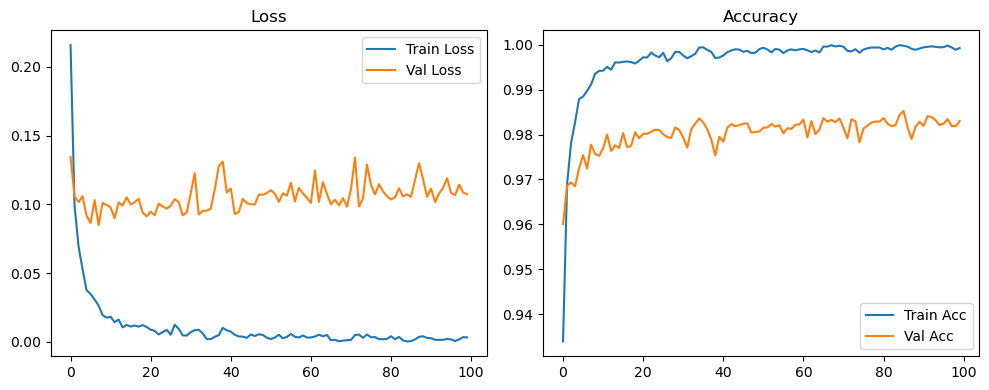

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2534, Acc: 0.9221 | Val Loss: 0.1366, Acc: 0.9599


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1323, Acc: 0.9584 | Val Loss: 0.1046, Acc: 0.9673


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0980, Acc: 0.9681 | Val Loss: 0.0935, Acc: 0.9707


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9749 | Val Loss: 0.1024, Acc: 0.9679


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9791 | Val Loss: 0.0864, Acc: 0.9736


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9806 | Val Loss: 0.0759, Acc: 0.9768


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9840 | Val Loss: 0.0746, Acc: 0.9774


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9851 | Val Loss: 0.0800, Acc: 0.9762


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9869 | Val Loss: 0.0775, Acc: 0.9768


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.0886, Acc: 0.9763


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9884 | Val Loss: 0.0701, Acc: 0.9807


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9899 | Val Loss: 0.0716, Acc: 0.9806


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9903 | Val Loss: 0.0858, Acc: 0.9782


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0866, Acc: 0.9793


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.0793, Acc: 0.9803


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0723, Acc: 0.9808


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0776, Acc: 0.9803


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0784, Acc: 0.9812


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9918 | Val Loss: 0.0786, Acc: 0.9804


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0777, Acc: 0.9815


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.0858, Acc: 0.9808


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9936 | Val Loss: 0.0796, Acc: 0.9811


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0864, Acc: 0.9811


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0807, Acc: 0.9806


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0742, Acc: 0.9823


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0888, Acc: 0.9808


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0881, Acc: 0.9805


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0801, Acc: 0.9823


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9952 | Val Loss: 0.0759, Acc: 0.9824


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0817, Acc: 0.9820


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0758, Acc: 0.9818


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0724, Acc: 0.9824


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0826, Acc: 0.9802


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0815, Acc: 0.9820


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0813, Acc: 0.9818


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9954 | Val Loss: 0.0786, Acc: 0.9822


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0886, Acc: 0.9810


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0771, Acc: 0.9830


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.0775, Acc: 0.9818


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0793, Acc: 0.9822


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0794, Acc: 0.9818


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0807, Acc: 0.9815


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0808, Acc: 0.9828


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0860, Acc: 0.9820


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0854, Acc: 0.9823


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0836, Acc: 0.9822


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0837, Acc: 0.9820


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0860, Acc: 0.9822


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0861, Acc: 0.9825


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0771, Acc: 0.9843


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0844, Acc: 0.9822


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0815, Acc: 0.9821


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0941, Acc: 0.9823


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0845, Acc: 0.9831


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.0870, Acc: 0.9835


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.0867, Acc: 0.9835


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0940, Acc: 0.9819


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0916, Acc: 0.9818


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0933, Acc: 0.9809


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0966, Acc: 0.9824


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0813, Acc: 0.9845


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0860, Acc: 0.9832


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0944, Acc: 0.9827


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0916, Acc: 0.9822


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0930, Acc: 0.9823


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0860, Acc: 0.9827


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0885, Acc: 0.9820


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0928, Acc: 0.9825


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0824, Acc: 0.9837


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0779, Acc: 0.9836


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0918, Acc: 0.9824


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0940, Acc: 0.9832


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0912, Acc: 0.9842


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0975, Acc: 0.9814


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0953, Acc: 0.9825


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0996, Acc: 0.9823


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0934, Acc: 0.9817


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0987, Acc: 0.9816


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0911, Acc: 0.9832


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0893, Acc: 0.9830


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0870, Acc: 0.9836


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0936, Acc: 0.9831


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1066, Acc: 0.9815


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0951, Acc: 0.9841


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0953, Acc: 0.9824


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0840, Acc: 0.9841


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0891, Acc: 0.9831


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0904, Acc: 0.9836


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0914, Acc: 0.9838


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0908, Acc: 0.9835


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0920, Acc: 0.9831


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0905, Acc: 0.9818


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0953, Acc: 0.9832


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1027, Acc: 0.9830


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0937, Acc: 0.9827


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0960, Acc: 0.9822


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0970, Acc: 0.9828


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0926, Acc: 0.9832


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0971, Acc: 0.9831


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1061, Acc: 0.9828


Final Test Loss: 0.0937 Accuracy: 0.9844


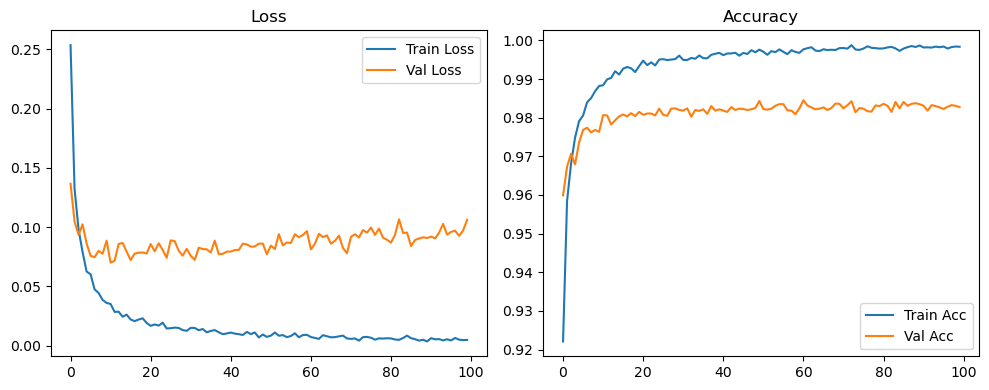

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3774, Acc: 0.8846 | Val Loss: 0.1620, Acc: 0.9512


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2171, Acc: 0.9341 | Val Loss: 0.1271, Acc: 0.9607


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1717, Acc: 0.9478 | Val Loss: 0.1111, Acc: 0.9660


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1485, Acc: 0.9551 | Val Loss: 0.1055, Acc: 0.9692


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1292, Acc: 0.9613 | Val Loss: 0.0924, Acc: 0.9716


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1216, Acc: 0.9614 | Val Loss: 0.0844, Acc: 0.9740


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1085, Acc: 0.9669 | Val Loss: 0.0853, Acc: 0.9735


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1035, Acc: 0.9678 | Val Loss: 0.0795, Acc: 0.9763


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0948, Acc: 0.9701 | Val Loss: 0.0786, Acc: 0.9768


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0919, Acc: 0.9714 | Val Loss: 0.0752, Acc: 0.9772


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0857, Acc: 0.9734 | Val Loss: 0.0745, Acc: 0.9788


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0852, Acc: 0.9733 | Val Loss: 0.0712, Acc: 0.9789


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9749 | Val Loss: 0.0754, Acc: 0.9790


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9748 | Val Loss: 0.0746, Acc: 0.9788


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9773 | Val Loss: 0.0723, Acc: 0.9788


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9780 | Val Loss: 0.0730, Acc: 0.9799


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9781 | Val Loss: 0.0727, Acc: 0.9796


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9793 | Val Loss: 0.0734, Acc: 0.9791


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9802 | Val Loss: 0.0755, Acc: 0.9785


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9807 | Val Loss: 0.0703, Acc: 0.9795


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9819 | Val Loss: 0.0762, Acc: 0.9800


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9810 | Val Loss: 0.0702, Acc: 0.9794


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9811 | Val Loss: 0.0710, Acc: 0.9796


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9833 | Val Loss: 0.0689, Acc: 0.9798


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9826 | Val Loss: 0.0675, Acc: 0.9803


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9834 | Val Loss: 0.0725, Acc: 0.9799


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9812 | Val Loss: 0.0695, Acc: 0.9799


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9847 | Val Loss: 0.0724, Acc: 0.9801


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0729, Acc: 0.9808


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9840 | Val Loss: 0.0743, Acc: 0.9805


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9848 | Val Loss: 0.0705, Acc: 0.9812


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9851 | Val Loss: 0.0688, Acc: 0.9818


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9848 | Val Loss: 0.0732, Acc: 0.9800


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9854 | Val Loss: 0.0698, Acc: 0.9808


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9861 | Val Loss: 0.0734, Acc: 0.9802


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9859 | Val Loss: 0.0691, Acc: 0.9814


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9860 | Val Loss: 0.0703, Acc: 0.9819


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9860 | Val Loss: 0.0710, Acc: 0.9822


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9865 | Val Loss: 0.0717, Acc: 0.9822


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9870 | Val Loss: 0.0725, Acc: 0.9819


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.0731, Acc: 0.9813


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9872 | Val Loss: 0.0706, Acc: 0.9814


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.0708, Acc: 0.9811


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.0715, Acc: 0.9808


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.0754, Acc: 0.9798


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9883 | Val Loss: 0.0700, Acc: 0.9812


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.0746, Acc: 0.9804


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9882 | Val Loss: 0.0650, Acc: 0.9823


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.0718, Acc: 0.9822


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9889 | Val Loss: 0.0742, Acc: 0.9816


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9897 | Val Loss: 0.0685, Acc: 0.9818


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9887 | Val Loss: 0.0684, Acc: 0.9836


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9892 | Val Loss: 0.0658, Acc: 0.9837


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.0734, Acc: 0.9818


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9897 | Val Loss: 0.0702, Acc: 0.9820


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9901 | Val Loss: 0.0728, Acc: 0.9826


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0301, Acc: 0.9902 | Val Loss: 0.0712, Acc: 0.9833


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0307, Acc: 0.9898 | Val Loss: 0.0702, Acc: 0.9825


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.0736, Acc: 0.9819


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9893 | Val Loss: 0.0734, Acc: 0.9818


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9895 | Val Loss: 0.0733, Acc: 0.9832


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9907 | Val Loss: 0.0703, Acc: 0.9826


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9908 | Val Loss: 0.0726, Acc: 0.9825


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9913 | Val Loss: 0.0749, Acc: 0.9827


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9905 | Val Loss: 0.0730, Acc: 0.9828


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0720, Acc: 0.9835


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9900 | Val Loss: 0.0730, Acc: 0.9820


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.0740, Acc: 0.9828


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9908 | Val Loss: 0.0764, Acc: 0.9828


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.0766, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0736, Acc: 0.9824


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.0710, Acc: 0.9822


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0747, Acc: 0.9830


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.0715, Acc: 0.9812


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9914 | Val Loss: 0.0703, Acc: 0.9830


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0741, Acc: 0.9827


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0739, Acc: 0.9833


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.0766, Acc: 0.9830


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9909 | Val Loss: 0.0721, Acc: 0.9832


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9923 | Val Loss: 0.0775, Acc: 0.9817


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.0776, Acc: 0.9822


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0805, Acc: 0.9810


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.0763, Acc: 0.9824


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9926 | Val Loss: 0.0794, Acc: 0.9823


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9926 | Val Loss: 0.0708, Acc: 0.9829


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9929 | Val Loss: 0.0754, Acc: 0.9828


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9926 | Val Loss: 0.0778, Acc: 0.9820


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9922 | Val Loss: 0.0724, Acc: 0.9826


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.0749, Acc: 0.9826


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0715, Acc: 0.9829


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9920 | Val Loss: 0.0831, Acc: 0.9814


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0751, Acc: 0.9826


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9926 | Val Loss: 0.0785, Acc: 0.9818


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.0746, Acc: 0.9832


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9934 | Val Loss: 0.0760, Acc: 0.9823


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9927 | Val Loss: 0.0794, Acc: 0.9828


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.0764, Acc: 0.9831


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9933 | Val Loss: 0.0774, Acc: 0.9826


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9928 | Val Loss: 0.0785, Acc: 0.9833


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9929 | Val Loss: 0.0762, Acc: 0.9832


Final Test Loss: 0.0678 Accuracy: 0.9843


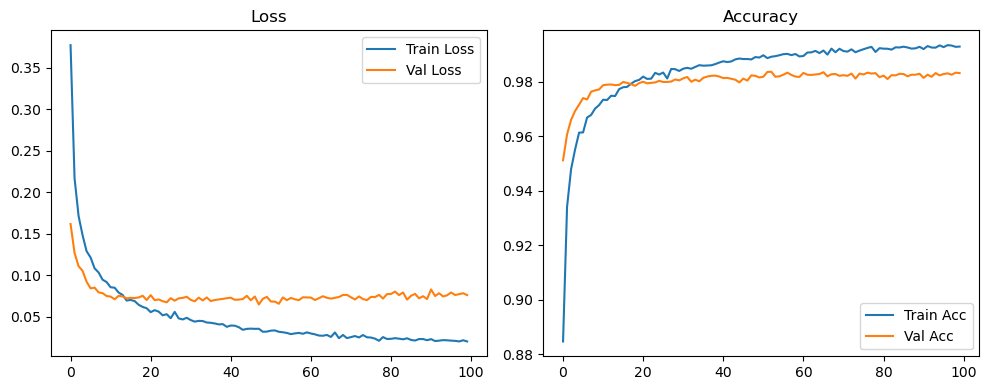

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2158, Acc: 0.9339 | Val Loss: 0.1346, Acc: 0.9601


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.0992, Acc: 0.9689 | Val Loss: 0.1056, Acc: 0.9686


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0694, Acc: 0.9781 | Val Loss: 0.1017, Acc: 0.9693


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0529, Acc: 0.9828 | Val Loss: 0.1059, Acc: 0.9684


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9879 | Val Loss: 0.0917, Acc: 0.9725


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9884 | Val Loss: 0.0864, Acc: 0.9754


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9897 | Val Loss: 0.1031, Acc: 0.9724


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.0850, Acc: 0.9778


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.1011, Acc: 0.9757


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0996, Acc: 0.9752


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0978, Acc: 0.9769


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0899, Acc: 0.9800


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1015, Acc: 0.9763


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9961 | Val Loss: 0.0991, Acc: 0.9776


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1051, Acc: 0.9770


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0999, Acc: 0.9803


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1016, Acc: 0.9772


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1041, Acc: 0.9775


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0940, Acc: 0.9805


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0913, Acc: 0.9792


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0946, Acc: 0.9802


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0921, Acc: 0.9802


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1006, Acc: 0.9806


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0985, Acc: 0.9811


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.0969, Acc: 0.9810


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0990, Acc: 0.9801


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.1037, Acc: 0.9794


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1018, Acc: 0.9792


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0920, Acc: 0.9816


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0940, Acc: 0.9810


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1081, Acc: 0.9793


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1227, Acc: 0.9771


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0927, Acc: 0.9812


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0953, Acc: 0.9824


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0955, Acc: 0.9836


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0968, Acc: 0.9827


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1109, Acc: 0.9812


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1278, Acc: 0.9789


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1311, Acc: 0.9753


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1086, Acc: 0.9795


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1115, Acc: 0.9784


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0930, Acc: 0.9815


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0945, Acc: 0.9823


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1040, Acc: 0.9818


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1009, Acc: 0.9821


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1001, Acc: 0.9824


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0999, Acc: 0.9825


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1071, Acc: 0.9804


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1070, Acc: 0.9806


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1082, Acc: 0.9807


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0938, Acc: 0.9830


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0946, Acc: 0.9836


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0948, Acc: 0.9836


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0940, Acc: 0.9838


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0930, Acc: 0.9843


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0949, Acc: 0.9839


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0944, Acc: 0.9845


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0936, Acc: 0.9843


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0939, Acc: 0.9842


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0940, Acc: 0.9843


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0946, Acc: 0.9850


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0953, Acc: 0.9847


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0973, Acc: 0.9843


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0994, Acc: 0.9847


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1057, Acc: 0.9850


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1076, Acc: 0.9840


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1089, Acc: 0.9826


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1108, Acc: 0.9828


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1125, Acc: 0.9837


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1097, Acc: 0.9828


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1017, Acc: 0.9844


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1123, Acc: 0.9832


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1057, Acc: 0.9841


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1036, Acc: 0.9842


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1097, Acc: 0.9848


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1156, Acc: 0.9841


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1099, Acc: 0.9846


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1127, Acc: 0.9840


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1132, Acc: 0.9847


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1148, Acc: 0.9840


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1144, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1126, Acc: 0.9841


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1129, Acc: 0.9849


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1132, Acc: 0.9849


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1122, Acc: 0.9842


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1109, Acc: 0.9849


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1110, Acc: 0.9846


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1116, Acc: 0.9846


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1122, Acc: 0.9848


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1128, Acc: 0.9853


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1097, Acc: 0.9852


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1083, Acc: 0.9858


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1081, Acc: 0.9854


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1076, Acc: 0.9853


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1088, Acc: 0.9860


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1083, Acc: 0.9852


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1091, Acc: 0.9853


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1094, Acc: 0.9848


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1115, Acc: 0.9856


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1155, Acc: 0.9851


Final Test Loss: 0.1085 Accuracy: 0.9842


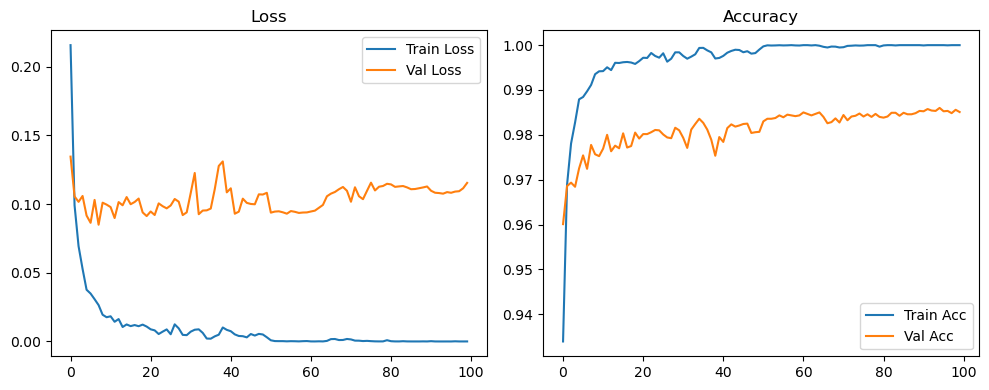

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2534, Acc: 0.9221 | Val Loss: 0.1366, Acc: 0.9599


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1323, Acc: 0.9584 | Val Loss: 0.1046, Acc: 0.9673


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0980, Acc: 0.9681 | Val Loss: 0.0935, Acc: 0.9707


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9749 | Val Loss: 0.1024, Acc: 0.9679


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0626, Acc: 0.9791 | Val Loss: 0.0864, Acc: 0.9736


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0602, Acc: 0.9806 | Val Loss: 0.0759, Acc: 0.9768


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9840 | Val Loss: 0.0746, Acc: 0.9774


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9851 | Val Loss: 0.0800, Acc: 0.9762


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9869 | Val Loss: 0.0775, Acc: 0.9768


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9882 | Val Loss: 0.0886, Acc: 0.9763


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0352, Acc: 0.9884 | Val Loss: 0.0701, Acc: 0.9807


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9899 | Val Loss: 0.0716, Acc: 0.9806


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9903 | Val Loss: 0.0858, Acc: 0.9782


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9920 | Val Loss: 0.0866, Acc: 0.9793


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.0793, Acc: 0.9803


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9927 | Val Loss: 0.0723, Acc: 0.9808


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.0776, Acc: 0.9803


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0784, Acc: 0.9812


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9918 | Val Loss: 0.0786, Acc: 0.9804


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0777, Acc: 0.9815


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.0858, Acc: 0.9808


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9936 | Val Loss: 0.0796, Acc: 0.9811


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0864, Acc: 0.9811


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0807, Acc: 0.9806


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0742, Acc: 0.9823


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0888, Acc: 0.9808


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9949 | Val Loss: 0.0881, Acc: 0.9805


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0801, Acc: 0.9823


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9952 | Val Loss: 0.0759, Acc: 0.9824


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0817, Acc: 0.9820


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0758, Acc: 0.9818


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0724, Acc: 0.9824


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0826, Acc: 0.9802


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0815, Acc: 0.9820


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0813, Acc: 0.9818


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9954 | Val Loss: 0.0786, Acc: 0.9822


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0886, Acc: 0.9810


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0771, Acc: 0.9830


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9965 | Val Loss: 0.0775, Acc: 0.9818


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0793, Acc: 0.9822


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0794, Acc: 0.9818


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0807, Acc: 0.9815


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0808, Acc: 0.9828


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0860, Acc: 0.9820


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0854, Acc: 0.9823


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0836, Acc: 0.9822


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0837, Acc: 0.9820


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0860, Acc: 0.9822


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0861, Acc: 0.9825


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0771, Acc: 0.9843


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0720, Acc: 0.9850


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0679, Acc: 0.9856


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0748, Acc: 0.9846


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0728, Acc: 0.9855


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0730, Acc: 0.9860


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0720, Acc: 0.9859


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0768, Acc: 0.9857


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0774, Acc: 0.9848


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0730, Acc: 0.9858


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0791, Acc: 0.9848


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0829, Acc: 0.9848


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0816, Acc: 0.9840


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0827, Acc: 0.9844


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0846, Acc: 0.9852


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0801, Acc: 0.9848


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0864, Acc: 0.9849


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0872, Acc: 0.9844


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0881, Acc: 0.9841


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0877, Acc: 0.9839


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0830, Acc: 0.9850


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0816, Acc: 0.9856


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0828, Acc: 0.9852


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0843, Acc: 0.9850


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0788, Acc: 0.9856


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9989 | Val Loss: 0.0883, Acc: 0.9851


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0858, Acc: 0.9850


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0869, Acc: 0.9861


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0904, Acc: 0.9854


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0972, Acc: 0.9844


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0937, Acc: 0.9843


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0902, Acc: 0.9855


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0887, Acc: 0.9850


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0879, Acc: 0.9856


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0889, Acc: 0.9852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0901, Acc: 0.9858


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0879, Acc: 0.9856


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0860, Acc: 0.9855


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0898, Acc: 0.9848


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0887, Acc: 0.9859


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0898, Acc: 0.9854


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0895, Acc: 0.9850


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0914, Acc: 0.9851


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0880, Acc: 0.9859


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.0903, Acc: 0.9858


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0913, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0902, Acc: 0.9854


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0886, Acc: 0.9856


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0885, Acc: 0.9850


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0857, Acc: 0.9858


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0886, Acc: 0.9859


Final Test Loss: 0.0904 Accuracy: 0.9866


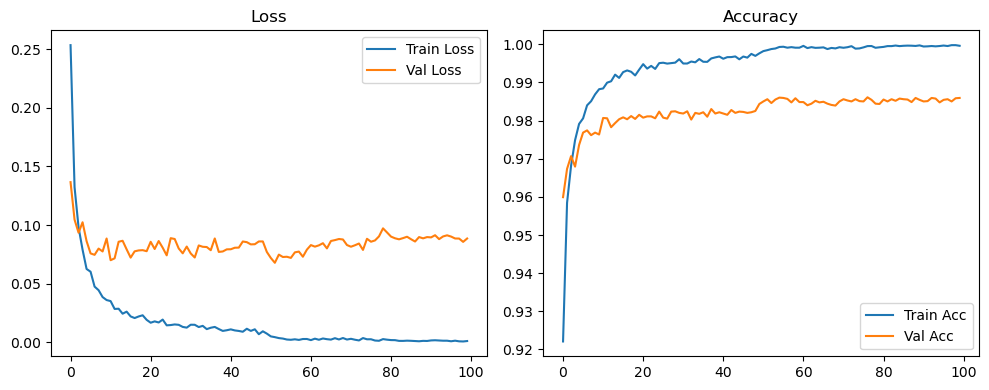

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3774, Acc: 0.8846 | Val Loss: 0.1620, Acc: 0.9512


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2171, Acc: 0.9341 | Val Loss: 0.1271, Acc: 0.9607


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1717, Acc: 0.9478 | Val Loss: 0.1111, Acc: 0.9660


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1485, Acc: 0.9551 | Val Loss: 0.1055, Acc: 0.9692


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1292, Acc: 0.9613 | Val Loss: 0.0924, Acc: 0.9716


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1216, Acc: 0.9614 | Val Loss: 0.0844, Acc: 0.9740


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1085, Acc: 0.9669 | Val Loss: 0.0853, Acc: 0.9735


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1035, Acc: 0.9678 | Val Loss: 0.0795, Acc: 0.9763


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0948, Acc: 0.9701 | Val Loss: 0.0786, Acc: 0.9768


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0919, Acc: 0.9714 | Val Loss: 0.0752, Acc: 0.9772


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0857, Acc: 0.9734 | Val Loss: 0.0745, Acc: 0.9788


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0852, Acc: 0.9733 | Val Loss: 0.0712, Acc: 0.9789


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0793, Acc: 0.9749 | Val Loss: 0.0754, Acc: 0.9790


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9748 | Val Loss: 0.0746, Acc: 0.9788


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0697, Acc: 0.9773 | Val Loss: 0.0723, Acc: 0.9788


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9780 | Val Loss: 0.0730, Acc: 0.9799


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9781 | Val Loss: 0.0727, Acc: 0.9796


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0646, Acc: 0.9793 | Val Loss: 0.0734, Acc: 0.9791


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0620, Acc: 0.9802 | Val Loss: 0.0755, Acc: 0.9785


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0605, Acc: 0.9807 | Val Loss: 0.0703, Acc: 0.9795


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0557, Acc: 0.9819 | Val Loss: 0.0762, Acc: 0.9800


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9810 | Val Loss: 0.0702, Acc: 0.9794


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9811 | Val Loss: 0.0710, Acc: 0.9796


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9833 | Val Loss: 0.0689, Acc: 0.9798


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9826 | Val Loss: 0.0675, Acc: 0.9803


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0484, Acc: 0.9834 | Val Loss: 0.0725, Acc: 0.9799


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0560, Acc: 0.9812 | Val Loss: 0.0695, Acc: 0.9799


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0482, Acc: 0.9847 | Val Loss: 0.0724, Acc: 0.9801


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9846 | Val Loss: 0.0729, Acc: 0.9808


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0489, Acc: 0.9840 | Val Loss: 0.0743, Acc: 0.9805


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9848 | Val Loss: 0.0705, Acc: 0.9812


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9851 | Val Loss: 0.0688, Acc: 0.9818


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9848 | Val Loss: 0.0732, Acc: 0.9800


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9854 | Val Loss: 0.0698, Acc: 0.9808


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9861 | Val Loss: 0.0734, Acc: 0.9802


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0429, Acc: 0.9859 | Val Loss: 0.0691, Acc: 0.9814


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9860 | Val Loss: 0.0703, Acc: 0.9819


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0409, Acc: 0.9860 | Val Loss: 0.0710, Acc: 0.9822


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0413, Acc: 0.9865 | Val Loss: 0.0717, Acc: 0.9822


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9870 | Val Loss: 0.0725, Acc: 0.9819


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9875 | Val Loss: 0.0731, Acc: 0.9813


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9872 | Val Loss: 0.0706, Acc: 0.9814


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9875 | Val Loss: 0.0708, Acc: 0.9811


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9882 | Val Loss: 0.0715, Acc: 0.9808


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9885 | Val Loss: 0.0754, Acc: 0.9798


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9883 | Val Loss: 0.0700, Acc: 0.9812


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9884 | Val Loss: 0.0746, Acc: 0.9804


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9882 | Val Loss: 0.0650, Acc: 0.9823


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.0718, Acc: 0.9822


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9889 | Val Loss: 0.0742, Acc: 0.9816


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9912 | Val Loss: 0.0691, Acc: 0.9826


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9911 | Val Loss: 0.0688, Acc: 0.9832


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9921 | Val Loss: 0.0675, Acc: 0.9842


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9922 | Val Loss: 0.0691, Acc: 0.9839


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0664, Acc: 0.9842


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0698, Acc: 0.9838


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9937 | Val Loss: 0.0704, Acc: 0.9839


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0696, Acc: 0.9835


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.0713, Acc: 0.9835


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9933 | Val Loss: 0.0725, Acc: 0.9840


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9930 | Val Loss: 0.0723, Acc: 0.9839


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9936 | Val Loss: 0.0709, Acc: 0.9838


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0726, Acc: 0.9838


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0719, Acc: 0.9835


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9935 | Val Loss: 0.0734, Acc: 0.9841


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.0725, Acc: 0.9843


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.0740, Acc: 0.9838


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0736, Acc: 0.9842


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9941 | Val Loss: 0.0747, Acc: 0.9832


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0784, Acc: 0.9833


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.0737, Acc: 0.9843


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.0740, Acc: 0.9833


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9943 | Val Loss: 0.0748, Acc: 0.9841


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.0721, Acc: 0.9827


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0722, Acc: 0.9833


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.0736, Acc: 0.9832


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0713, Acc: 0.9842


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0743, Acc: 0.9837


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0712, Acc: 0.9842


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.0737, Acc: 0.9832


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.0735, Acc: 0.9842


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.0740, Acc: 0.9844


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9951 | Val Loss: 0.0759, Acc: 0.9841


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0746, Acc: 0.9846


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0739, Acc: 0.9845


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0746, Acc: 0.9842


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0758, Acc: 0.9836


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.0765, Acc: 0.9835


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0771, Acc: 0.9838


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0761, Acc: 0.9843


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0793, Acc: 0.9838


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9957 | Val Loss: 0.0768, Acc: 0.9836


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0772, Acc: 0.9838


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0768, Acc: 0.9836


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0778, Acc: 0.9843


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0785, Acc: 0.9837


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0782, Acc: 0.9841


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0790, Acc: 0.9832


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0775, Acc: 0.9844


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.0778, Acc: 0.9844


Final Test Loss: 0.0684 Accuracy: 0.9860


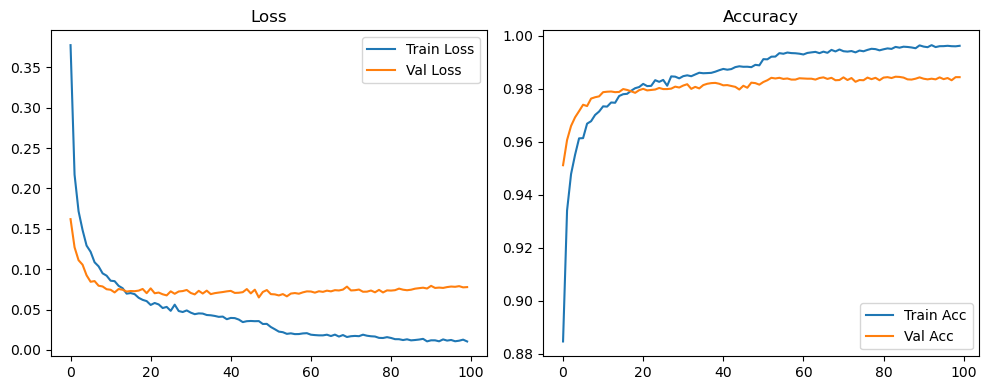

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2148, Acc: 0.9376 | Val Loss: 0.1305, Acc: 0.9604


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0910, Acc: 0.9718 | Val Loss: 0.0982, Acc: 0.9685


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0628, Acc: 0.9801 | Val Loss: 0.1040, Acc: 0.9669


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0483, Acc: 0.9839 | Val Loss: 0.0924, Acc: 0.9720


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.0854, Acc: 0.9738


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.0804, Acc: 0.9768


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9918 | Val Loss: 0.0953, Acc: 0.9733


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0829, Acc: 0.9779


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0998, Acc: 0.9745


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0901, Acc: 0.9781


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.0938, Acc: 0.9772


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1095, Acc: 0.9728


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.0923, Acc: 0.9796


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0953, Acc: 0.9786


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1079, Acc: 0.9760


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.0945, Acc: 0.9776


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0855, Acc: 0.9815


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0871, Acc: 0.9808


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1059, Acc: 0.9778


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0986, Acc: 0.9798


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0899, Acc: 0.9800


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0897, Acc: 0.9810


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0859, Acc: 0.9822


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0963, Acc: 0.9798


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0935, Acc: 0.9805


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1098, Acc: 0.9780


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0973, Acc: 0.9811


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0908, Acc: 0.9808


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0933, Acc: 0.9822


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0896, Acc: 0.9829


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1005, Acc: 0.9813


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1106, Acc: 0.9783


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0994, Acc: 0.9792


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0967, Acc: 0.9809


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0922, Acc: 0.9815


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0892, Acc: 0.9819


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0860, Acc: 0.9836


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0946, Acc: 0.9826


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1178, Acc: 0.9803


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1041, Acc: 0.9795


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.0902, Acc: 0.9823


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0889, Acc: 0.9832


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1181, Acc: 0.9794


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0931, Acc: 0.9818


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1017, Acc: 0.9802


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0999, Acc: 0.9808


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0905, Acc: 0.9827


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0887, Acc: 0.9838


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0886, Acc: 0.9834


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0929, Acc: 0.9824


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1017, Acc: 0.9816


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1178, Acc: 0.9780


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1054, Acc: 0.9824


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1023, Acc: 0.9827


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1126, Acc: 0.9811


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1086, Acc: 0.9812


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0959, Acc: 0.9832


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0978, Acc: 0.9826


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0888, Acc: 0.9838


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.0866, Acc: 0.9846


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0884, Acc: 0.9847


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0922, Acc: 0.9838


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0958, Acc: 0.9839


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0953, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1215, Acc: 0.9782


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1081, Acc: 0.9820


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0964, Acc: 0.9823


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0989, Acc: 0.9816


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0936, Acc: 0.9833


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0951, Acc: 0.9838


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0913, Acc: 0.9847


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1149, Acc: 0.9804


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1059, Acc: 0.9817


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1019, Acc: 0.9820


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0991, Acc: 0.9824


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.0951, Acc: 0.9828


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0915, Acc: 0.9844


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0954, Acc: 0.9832


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0954, Acc: 0.9838


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1055, Acc: 0.9835


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1261, Acc: 0.9807


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.1059, Acc: 0.9832


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0997, Acc: 0.9827


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1025, Acc: 0.9817


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0931, Acc: 0.9838


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0908, Acc: 0.9853


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0892, Acc: 0.9851


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0912, Acc: 0.9852


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1004, Acc: 0.9842


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1087, Acc: 0.9830


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0951, Acc: 0.9830


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1036, Acc: 0.9813


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0924, Acc: 0.9846


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0933, Acc: 0.9844


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0942, Acc: 0.9838


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0939, Acc: 0.9837


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1047, Acc: 0.9828


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1009, Acc: 0.9830


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0973, Acc: 0.9828


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0950, Acc: 0.9838


Final Test Loss: 0.0978 Accuracy: 0.9836


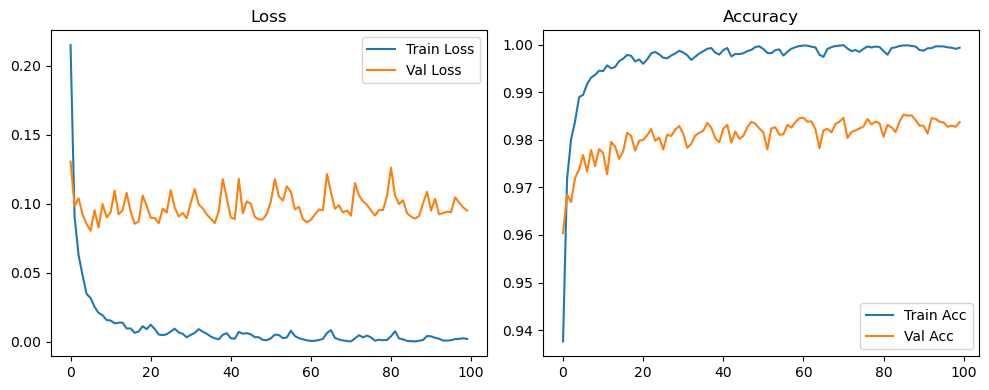

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2670, Acc: 0.9225 | Val Loss: 0.1360, Acc: 0.9595


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1292, Acc: 0.9588 | Val Loss: 0.1016, Acc: 0.9688


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0972, Acc: 0.9689 | Val Loss: 0.1003, Acc: 0.9677


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0781, Acc: 0.9750 | Val Loss: 0.0920, Acc: 0.9708


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0671, Acc: 0.9782 | Val Loss: 0.0839, Acc: 0.9732


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0596, Acc: 0.9808 | Val Loss: 0.0697, Acc: 0.9789


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9832 | Val Loss: 0.0721, Acc: 0.9772


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9847 | Val Loss: 0.0751, Acc: 0.9781


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0402, Acc: 0.9872 | Val Loss: 0.0718, Acc: 0.9782


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0370, Acc: 0.9875 | Val Loss: 0.0732, Acc: 0.9790


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9887 | Val Loss: 0.0813, Acc: 0.9775


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0698, Acc: 0.9798


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9896 | Val Loss: 0.0769, Acc: 0.9797


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9901 | Val Loss: 0.0820, Acc: 0.9786


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.0769, Acc: 0.9798


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9905 | Val Loss: 0.0765, Acc: 0.9804


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9919 | Val Loss: 0.0735, Acc: 0.9799


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9928 | Val Loss: 0.0787, Acc: 0.9806


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9918 | Val Loss: 0.0783, Acc: 0.9794


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.0744, Acc: 0.9805


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0762, Acc: 0.9813


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9935 | Val Loss: 0.0749, Acc: 0.9828


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.0755, Acc: 0.9805


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9940 | Val Loss: 0.0774, Acc: 0.9799


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0792, Acc: 0.9804


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0750, Acc: 0.9817


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0758, Acc: 0.9816


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0817, Acc: 0.9813


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0790, Acc: 0.9812


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0782, Acc: 0.9816


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0815, Acc: 0.9812


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0750, Acc: 0.9824


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9967 | Val Loss: 0.0814, Acc: 0.9820


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9957 | Val Loss: 0.0783, Acc: 0.9828


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0731, Acc: 0.9822


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0812, Acc: 0.9818


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9959 | Val Loss: 0.0809, Acc: 0.9817


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9965 | Val Loss: 0.0737, Acc: 0.9826


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0801, Acc: 0.9807


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9958 | Val Loss: 0.0844, Acc: 0.9818


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.0784, Acc: 0.9831


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0760, Acc: 0.9829


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0801, Acc: 0.9823


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0839, Acc: 0.9822


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.0822, Acc: 0.9824


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0776, Acc: 0.9822


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9960 | Val Loss: 0.0809, Acc: 0.9824


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0815, Acc: 0.9832


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0819, Acc: 0.9829


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0821, Acc: 0.9838


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9976 | Val Loss: 0.0812, Acc: 0.9838


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0813, Acc: 0.9841


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0908, Acc: 0.9814


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9965 | Val Loss: 0.0868, Acc: 0.9828


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0862, Acc: 0.9824


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0807, Acc: 0.9827


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0788, Acc: 0.9822


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0777, Acc: 0.9834


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0835, Acc: 0.9827


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0825, Acc: 0.9827


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0829, Acc: 0.9827


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0817, Acc: 0.9828


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0820, Acc: 0.9831


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0861, Acc: 0.9833


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9974 | Val Loss: 0.0750, Acc: 0.9847


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0851, Acc: 0.9830


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0815, Acc: 0.9839


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0851, Acc: 0.9838


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0914, Acc: 0.9823


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0887, Acc: 0.9836


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0876, Acc: 0.9821


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0829, Acc: 0.9848


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0843, Acc: 0.9840


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0819, Acc: 0.9838


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.0922, Acc: 0.9830


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0906, Acc: 0.9834


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0891, Acc: 0.9834


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0851, Acc: 0.9850


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0906, Acc: 0.9835


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0887, Acc: 0.9835


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0798, Acc: 0.9847


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0962, Acc: 0.9828


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0927, Acc: 0.9828


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0917, Acc: 0.9835


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0862, Acc: 0.9830


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0884, Acc: 0.9837


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0872, Acc: 0.9849


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0852, Acc: 0.9838


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0825, Acc: 0.9851


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0797, Acc: 0.9851


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0859, Acc: 0.9835


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.0849, Acc: 0.9843


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0879, Acc: 0.9847


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0953, Acc: 0.9841


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0941, Acc: 0.9841


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0879, Acc: 0.9843


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0909, Acc: 0.9842


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0901, Acc: 0.9842


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0917, Acc: 0.9837


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0909, Acc: 0.9839


Final Test Loss: 0.0869 Accuracy: 0.9835


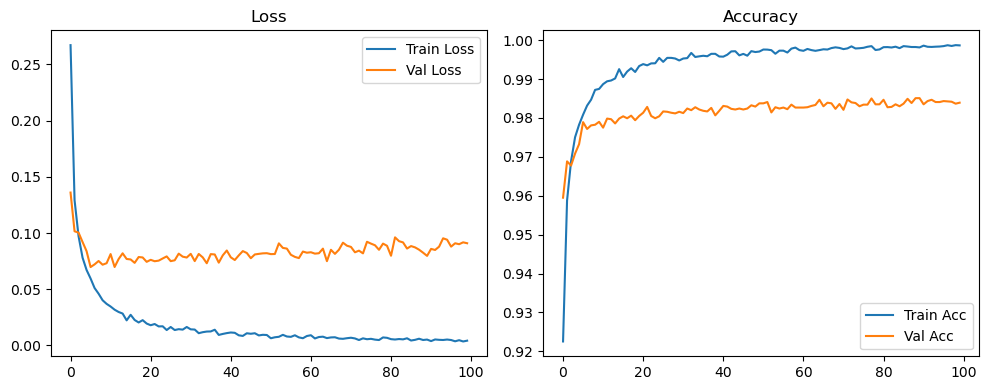

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4181, Acc: 0.8761 | Val Loss: 0.1756, Acc: 0.9473


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2251, Acc: 0.9324 | Val Loss: 0.1321, Acc: 0.9596


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1853, Acc: 0.9436 | Val Loss: 0.1209, Acc: 0.9643


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1571, Acc: 0.9511 | Val Loss: 0.1056, Acc: 0.9682


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1410, Acc: 0.9566 | Val Loss: 0.0992, Acc: 0.9692


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1296, Acc: 0.9602 | Val Loss: 0.0929, Acc: 0.9710


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1175, Acc: 0.9640 | Val Loss: 0.0913, Acc: 0.9714


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1090, Acc: 0.9662 | Val Loss: 0.0886, Acc: 0.9737


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1047, Acc: 0.9680 | Val Loss: 0.0792, Acc: 0.9751


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0968, Acc: 0.9696 | Val Loss: 0.0819, Acc: 0.9752


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0902, Acc: 0.9712 | Val Loss: 0.0775, Acc: 0.9763


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0878, Acc: 0.9719 | Val Loss: 0.0774, Acc: 0.9771


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0857, Acc: 0.9725 | Val Loss: 0.0733, Acc: 0.9786


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0804, Acc: 0.9749 | Val Loss: 0.0765, Acc: 0.9764


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0772, Acc: 0.9751 | Val Loss: 0.0735, Acc: 0.9785


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0748, Acc: 0.9758 | Val Loss: 0.0745, Acc: 0.9781


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0746, Acc: 0.9756 | Val Loss: 0.0723, Acc: 0.9782


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0689, Acc: 0.9780 | Val Loss: 0.0746, Acc: 0.9785


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0680, Acc: 0.9779 | Val Loss: 0.0747, Acc: 0.9778


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9786 | Val Loss: 0.0722, Acc: 0.9788


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0632, Acc: 0.9794 | Val Loss: 0.0738, Acc: 0.9798


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0610, Acc: 0.9802 | Val Loss: 0.0717, Acc: 0.9784


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0622, Acc: 0.9799 | Val Loss: 0.0744, Acc: 0.9772


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0592, Acc: 0.9809 | Val Loss: 0.0688, Acc: 0.9793


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9820 | Val Loss: 0.0729, Acc: 0.9792


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0539, Acc: 0.9823 | Val Loss: 0.0707, Acc: 0.9797


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0543, Acc: 0.9824 | Val Loss: 0.0714, Acc: 0.9798


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9838 | Val Loss: 0.0729, Acc: 0.9796


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0513, Acc: 0.9831 | Val Loss: 0.0704, Acc: 0.9806


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9832 | Val Loss: 0.0710, Acc: 0.9802


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9839 | Val Loss: 0.0731, Acc: 0.9799


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0474, Acc: 0.9844 | Val Loss: 0.0714, Acc: 0.9800


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9842 | Val Loss: 0.0714, Acc: 0.9806


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9853 | Val Loss: 0.0685, Acc: 0.9808


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9855 | Val Loss: 0.0682, Acc: 0.9805


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0433, Acc: 0.9863 | Val Loss: 0.0679, Acc: 0.9798


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0450, Acc: 0.9846 | Val Loss: 0.0676, Acc: 0.9813


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9861 | Val Loss: 0.0684, Acc: 0.9809


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9860 | Val Loss: 0.0682, Acc: 0.9820


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9859 | Val Loss: 0.0696, Acc: 0.9813


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0420, Acc: 0.9862 | Val Loss: 0.0707, Acc: 0.9812


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9874 | Val Loss: 0.0731, Acc: 0.9805


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9865 | Val Loss: 0.0721, Acc: 0.9798


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9875 | Val Loss: 0.0707, Acc: 0.9818


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0410, Acc: 0.9863 | Val Loss: 0.0707, Acc: 0.9812


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9867 | Val Loss: 0.0704, Acc: 0.9805


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9876 | Val Loss: 0.0693, Acc: 0.9818


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9875 | Val Loss: 0.0704, Acc: 0.9807


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9879 | Val Loss: 0.0687, Acc: 0.9823


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9869 | Val Loss: 0.0697, Acc: 0.9813


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9884 | Val Loss: 0.0734, Acc: 0.9805


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9880 | Val Loss: 0.0704, Acc: 0.9822


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0337, Acc: 0.9886 | Val Loss: 0.0705, Acc: 0.9809


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9895 | Val Loss: 0.0731, Acc: 0.9818


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.0726, Acc: 0.9812


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9893 | Val Loss: 0.0731, Acc: 0.9804


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9898 | Val Loss: 0.0763, Acc: 0.9811


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.0745, Acc: 0.9811


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0765, Acc: 0.9807


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9890 | Val Loss: 0.0713, Acc: 0.9815


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9902 | Val Loss: 0.0734, Acc: 0.9817


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 0.0693, Acc: 0.9816


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.0719, Acc: 0.9818


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9904 | Val Loss: 0.0759, Acc: 0.9809


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9902 | Val Loss: 0.0716, Acc: 0.9823


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9910 | Val Loss: 0.0747, Acc: 0.9822


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9903 | Val Loss: 0.0759, Acc: 0.9808


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0745, Acc: 0.9823


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9906 | Val Loss: 0.0734, Acc: 0.9828


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9918 | Val Loss: 0.0786, Acc: 0.9823


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9908 | Val Loss: 0.0757, Acc: 0.9827


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9901 | Val Loss: 0.0736, Acc: 0.9822


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9913 | Val Loss: 0.0741, Acc: 0.9825


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9905 | Val Loss: 0.0730, Acc: 0.9817


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9909 | Val Loss: 0.0713, Acc: 0.9822


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0748, Acc: 0.9828


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9918 | Val Loss: 0.0769, Acc: 0.9822


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0238, Acc: 0.9918 | Val Loss: 0.0760, Acc: 0.9813


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0712, Acc: 0.9830


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9915 | Val Loss: 0.0743, Acc: 0.9814


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9913 | Val Loss: 0.0770, Acc: 0.9818


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.0768, Acc: 0.9812


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9916 | Val Loss: 0.0814, Acc: 0.9816


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.0774, Acc: 0.9821


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0753, Acc: 0.9828


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.0753, Acc: 0.9825


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.0739, Acc: 0.9828


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.0775, Acc: 0.9817


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9915 | Val Loss: 0.0749, Acc: 0.9828


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0761, Acc: 0.9822


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0785, Acc: 0.9822


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9921 | Val Loss: 0.0722, Acc: 0.9822


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.0733, Acc: 0.9815


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0728, Acc: 0.9820


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.0754, Acc: 0.9830


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.0783, Acc: 0.9818


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0785, Acc: 0.9824


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9926 | Val Loss: 0.0784, Acc: 0.9812


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0805, Acc: 0.9820


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.0760, Acc: 0.9820


Final Test Loss: 0.0690 Accuracy: 0.9835


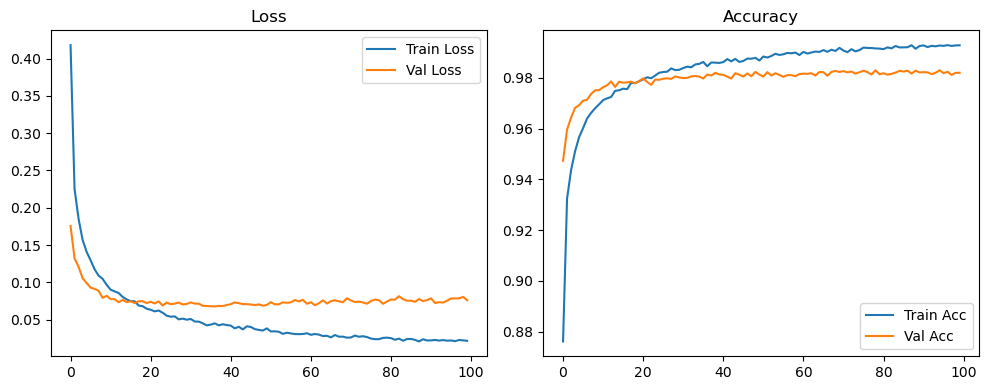

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2400, Acc: 0.9345 | Val Loss: 0.1262, Acc: 0.9616


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0872, Acc: 0.9732 | Val Loss: 0.0946, Acc: 0.9697


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0587, Acc: 0.9819 | Val Loss: 0.0978, Acc: 0.9695


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0425, Acc: 0.9869 | Val Loss: 0.0871, Acc: 0.9734


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0793, Acc: 0.9757


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.0789, Acc: 0.9755


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0835, Acc: 0.9770


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0878, Acc: 0.9758


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0831, Acc: 0.9772


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0857, Acc: 0.9774


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9955 | Val Loss: 0.0775, Acc: 0.9791


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0930, Acc: 0.9765


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0843, Acc: 0.9797


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0938, Acc: 0.9787


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0852, Acc: 0.9792


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0889, Acc: 0.9787


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0893, Acc: 0.9801


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0875, Acc: 0.9788


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0877, Acc: 0.9802


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0821, Acc: 0.9807


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0890, Acc: 0.9792


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0897, Acc: 0.9802


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0832, Acc: 0.9806


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.0885, Acc: 0.9799


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0843, Acc: 0.9813


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1008, Acc: 0.9778


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0884, Acc: 0.9804


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0957, Acc: 0.9802


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0912, Acc: 0.9812


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0889, Acc: 0.9802


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0935, Acc: 0.9793


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0962, Acc: 0.9802


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1019, Acc: 0.9790


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0864, Acc: 0.9801


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0891, Acc: 0.9822


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0853, Acc: 0.9823


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0913, Acc: 0.9812


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1100, Acc: 0.9788


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1191, Acc: 0.9773


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1080, Acc: 0.9779


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.0871, Acc: 0.9824


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0822, Acc: 0.9828


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0859, Acc: 0.9822


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0960, Acc: 0.9822


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0907, Acc: 0.9827


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0970, Acc: 0.9817


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0936, Acc: 0.9806


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0962, Acc: 0.9812


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0976, Acc: 0.9808


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1075, Acc: 0.9798


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0889, Acc: 0.9832


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0910, Acc: 0.9816


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0867, Acc: 0.9826


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0865, Acc: 0.9827


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0835, Acc: 0.9838


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1013, Acc: 0.9809


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1068, Acc: 0.9798


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0919, Acc: 0.9819


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1011, Acc: 0.9809


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0943, Acc: 0.9819


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0938, Acc: 0.9820


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0906, Acc: 0.9831


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0885, Acc: 0.9837


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0853, Acc: 0.9839


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0886, Acc: 0.9842


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0870, Acc: 0.9842


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0842, Acc: 0.9845


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0833, Acc: 0.9846


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0840, Acc: 0.9853


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0833, Acc: 0.9850


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0826, Acc: 0.9847


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0872, Acc: 0.9848


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0852, Acc: 0.9848


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0838, Acc: 0.9855


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0835, Acc: 0.9852


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0826, Acc: 0.9853


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9954 | Val Loss: 0.1568, Acc: 0.9710


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9949 | Val Loss: 0.0939, Acc: 0.9805


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0885, Acc: 0.9819


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0843, Acc: 0.9823


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0807, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0807, Acc: 0.9840


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0802, Acc: 0.9833


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0804, Acc: 0.9838


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0846, Acc: 0.9828


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0899, Acc: 0.9819


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0989, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1108, Acc: 0.9788


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0932, Acc: 0.9820


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0870, Acc: 0.9821


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0761, Acc: 0.9844


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0784, Acc: 0.9847


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0775, Acc: 0.9848


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0759, Acc: 0.9855


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0754, Acc: 0.9861


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0759, Acc: 0.9855


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0773, Acc: 0.9857


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0766, Acc: 0.9858


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0779, Acc: 0.9854


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9990 | Val Loss: 0.1107, Acc: 0.9791


Final Test Loss: 0.1030 Accuracy: 0.9793


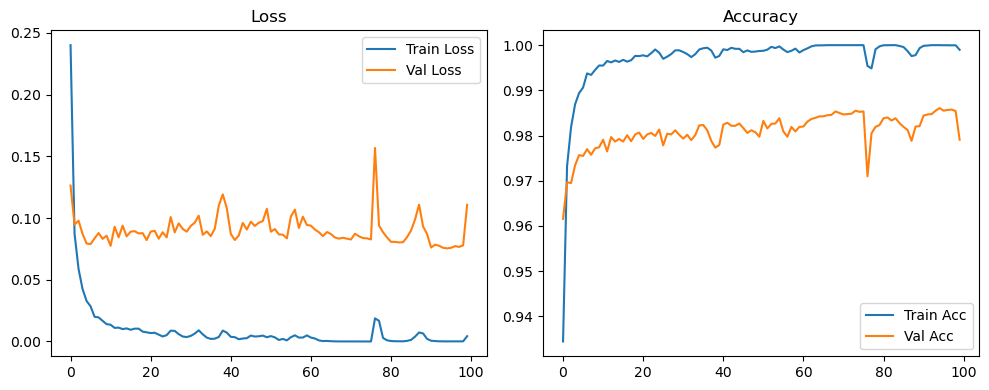

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3084, Acc: 0.9150 | Val Loss: 0.1415, Acc: 0.9576


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1325, Acc: 0.9604 | Val Loss: 0.1021, Acc: 0.9681


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0998, Acc: 0.9686 | Val Loss: 0.0994, Acc: 0.9682


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0810, Acc: 0.9750 | Val Loss: 0.0888, Acc: 0.9728


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9780 | Val Loss: 0.0839, Acc: 0.9736


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0607, Acc: 0.9805 | Val Loss: 0.0725, Acc: 0.9777


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0541, Acc: 0.9819 | Val Loss: 0.0737, Acc: 0.9769


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9843 | Val Loss: 0.0712, Acc: 0.9789


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9857 | Val Loss: 0.0774, Acc: 0.9771


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9875 | Val Loss: 0.0739, Acc: 0.9785


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0386, Acc: 0.9870 | Val Loss: 0.0786, Acc: 0.9786


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9883 | Val Loss: 0.0670, Acc: 0.9809


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9896 | Val Loss: 0.0767, Acc: 0.9798


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9895 | Val Loss: 0.0734, Acc: 0.9788


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.0701, Acc: 0.9812


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.0768, Acc: 0.9790


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9915 | Val Loss: 0.0768, Acc: 0.9807


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0699, Acc: 0.9809


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9914 | Val Loss: 0.0771, Acc: 0.9789


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9924 | Val Loss: 0.0727, Acc: 0.9802


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9931 | Val Loss: 0.0719, Acc: 0.9808


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.0713, Acc: 0.9824


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9929 | Val Loss: 0.0694, Acc: 0.9819


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0185, Acc: 0.9936 | Val Loss: 0.0771, Acc: 0.9802


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9942 | Val Loss: 0.0806, Acc: 0.9803


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.0737, Acc: 0.9808


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9942 | Val Loss: 0.0740, Acc: 0.9819


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0814, Acc: 0.9805


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0779, Acc: 0.9811


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0792, Acc: 0.9814


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0711, Acc: 0.9823


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0774, Acc: 0.9822


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0794, Acc: 0.9815


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9962 | Val Loss: 0.0797, Acc: 0.9815


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0741, Acc: 0.9829


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9956 | Val Loss: 0.0780, Acc: 0.9826


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0867, Acc: 0.9800


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.0817, Acc: 0.9794


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0770, Acc: 0.9829


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0775, Acc: 0.9816


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0767, Acc: 0.9834


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0769, Acc: 0.9835


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0782, Acc: 0.9824


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0806, Acc: 0.9822


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0828, Acc: 0.9820


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0758, Acc: 0.9831


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0828, Acc: 0.9811


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0783, Acc: 0.9835


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0859, Acc: 0.9817


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0806, Acc: 0.9830


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0853, Acc: 0.9832


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0890, Acc: 0.9825


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0884, Acc: 0.9821


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0830, Acc: 0.9828


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0879, Acc: 0.9815


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0793, Acc: 0.9828


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0922, Acc: 0.9817


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0765, Acc: 0.9826


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0858, Acc: 0.9819


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.0832, Acc: 0.9827


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0789, Acc: 0.9831


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0736, Acc: 0.9841


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0803, Acc: 0.9832


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0862, Acc: 0.9820


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0832, Acc: 0.9831


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0833, Acc: 0.9828


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0901, Acc: 0.9828


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0876, Acc: 0.9821


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0856, Acc: 0.9825


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0799, Acc: 0.9846


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0796, Acc: 0.9840


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0801, Acc: 0.9832


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.0839, Acc: 0.9839


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0799, Acc: 0.9846


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0865, Acc: 0.9831


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0829, Acc: 0.9839


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0820, Acc: 0.9839


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0822, Acc: 0.9831


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0873, Acc: 0.9828


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0864, Acc: 0.9837


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0856, Acc: 0.9837


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0906, Acc: 0.9821


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0843, Acc: 0.9832


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0805, Acc: 0.9857


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0930, Acc: 0.9838


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0817, Acc: 0.9850


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0915, Acc: 0.9838


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0863, Acc: 0.9828


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0815, Acc: 0.9834


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0847, Acc: 0.9838


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0906, Acc: 0.9832


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0861, Acc: 0.9836


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0873, Acc: 0.9834


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0912, Acc: 0.9839


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0955, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0814, Acc: 0.9848


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0901, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0904, Acc: 0.9825


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0874, Acc: 0.9824


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0878, Acc: 0.9845


Final Test Loss: 0.0814 Accuracy: 0.9842


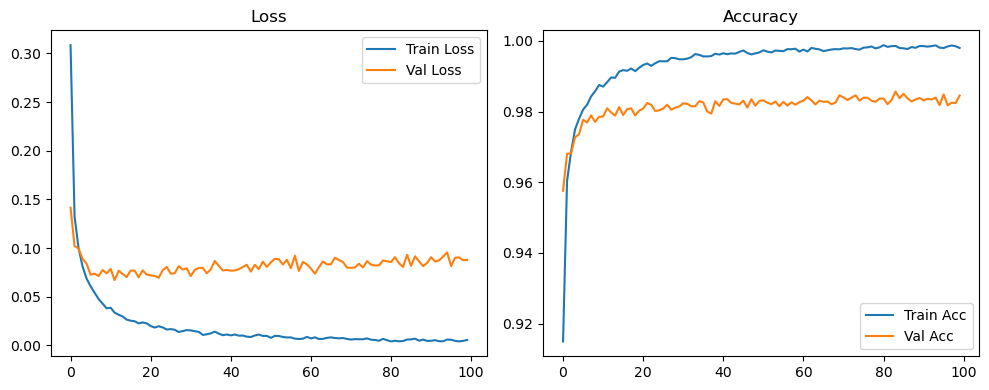

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4991, Acc: 0.8579 | Val Loss: 0.1919, Acc: 0.9434


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2409, Acc: 0.9276 | Val Loss: 0.1428, Acc: 0.9563


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1977, Acc: 0.9401 | Val Loss: 0.1304, Acc: 0.9616


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1715, Acc: 0.9475 | Val Loss: 0.1131, Acc: 0.9660


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1502, Acc: 0.9536 | Val Loss: 0.1055, Acc: 0.9677


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1397, Acc: 0.9571 | Val Loss: 0.0986, Acc: 0.9695


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1296, Acc: 0.9602 | Val Loss: 0.0998, Acc: 0.9691


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.1195, Acc: 0.9620 | Val Loss: 0.0930, Acc: 0.9722


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1129, Acc: 0.9652 | Val Loss: 0.0881, Acc: 0.9732


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1045, Acc: 0.9687 | Val Loss: 0.0869, Acc: 0.9748


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1004, Acc: 0.9690 | Val Loss: 0.0814, Acc: 0.9764


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0987, Acc: 0.9694 | Val Loss: 0.0812, Acc: 0.9754


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0912, Acc: 0.9713 | Val Loss: 0.0800, Acc: 0.9765


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0893, Acc: 0.9721 | Val Loss: 0.0799, Acc: 0.9761


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0838, Acc: 0.9723 | Val Loss: 0.0741, Acc: 0.9769


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0820, Acc: 0.9738 | Val Loss: 0.0751, Acc: 0.9779


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0816, Acc: 0.9739 | Val Loss: 0.0746, Acc: 0.9777


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0767, Acc: 0.9755 | Val Loss: 0.0743, Acc: 0.9773


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0728, Acc: 0.9764 | Val Loss: 0.0747, Acc: 0.9776


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0689, Acc: 0.9776 | Val Loss: 0.0783, Acc: 0.9761


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9780 | Val Loss: 0.0775, Acc: 0.9771


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0655, Acc: 0.9780 | Val Loss: 0.0752, Acc: 0.9770


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0654, Acc: 0.9784 | Val Loss: 0.0767, Acc: 0.9772


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0632, Acc: 0.9797 | Val Loss: 0.0709, Acc: 0.9785


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0636, Acc: 0.9782 | Val Loss: 0.0761, Acc: 0.9781


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0595, Acc: 0.9805 | Val Loss: 0.0759, Acc: 0.9772


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0604, Acc: 0.9802 | Val Loss: 0.0728, Acc: 0.9784


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0562, Acc: 0.9816 | Val Loss: 0.0716, Acc: 0.9792


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0526, Acc: 0.9824 | Val Loss: 0.0740, Acc: 0.9788


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0550, Acc: 0.9820 | Val Loss: 0.0725, Acc: 0.9797


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9823 | Val Loss: 0.0760, Acc: 0.9786


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9839 | Val Loss: 0.0718, Acc: 0.9797


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0536, Acc: 0.9819 | Val Loss: 0.0723, Acc: 0.9794


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9829 | Val Loss: 0.0704, Acc: 0.9802


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9842 | Val Loss: 0.0728, Acc: 0.9796


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0483, Acc: 0.9844 | Val Loss: 0.0698, Acc: 0.9799


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0508, Acc: 0.9828 | Val Loss: 0.0735, Acc: 0.9804


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0472, Acc: 0.9844 | Val Loss: 0.0699, Acc: 0.9803


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9851 | Val Loss: 0.0705, Acc: 0.9805


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0455, Acc: 0.9845 | Val Loss: 0.0750, Acc: 0.9797


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0448, Acc: 0.9852 | Val Loss: 0.0751, Acc: 0.9794


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9866 | Val Loss: 0.0717, Acc: 0.9795


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9849 | Val Loss: 0.0719, Acc: 0.9805


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0427, Acc: 0.9855 | Val Loss: 0.0731, Acc: 0.9809


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0411, Acc: 0.9861 | Val Loss: 0.0725, Acc: 0.9802


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9858 | Val Loss: 0.0737, Acc: 0.9803


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9867 | Val Loss: 0.0694, Acc: 0.9816


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 0.0723, Acc: 0.9809


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9873 | Val Loss: 0.0739, Acc: 0.9808


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9872 | Val Loss: 0.0741, Acc: 0.9803


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9875 | Val Loss: 0.0726, Acc: 0.9807


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0388, Acc: 0.9868 | Val Loss: 0.0723, Acc: 0.9802


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9876 | Val Loss: 0.0710, Acc: 0.9812


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9880 | Val Loss: 0.0721, Acc: 0.9809


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9883 | Val Loss: 0.0739, Acc: 0.9807


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9878 | Val Loss: 0.0738, Acc: 0.9797


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9885 | Val Loss: 0.0772, Acc: 0.9798


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9882 | Val Loss: 0.0765, Acc: 0.9799


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9889 | Val Loss: 0.0750, Acc: 0.9812


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9888 | Val Loss: 0.0743, Acc: 0.9803


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9894 | Val Loss: 0.0740, Acc: 0.9803


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9901 | Val Loss: 0.0742, Acc: 0.9819


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9888 | Val Loss: 0.0744, Acc: 0.9810


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9890 | Val Loss: 0.0731, Acc: 0.9822


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9901 | Val Loss: 0.0738, Acc: 0.9811


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9896 | Val Loss: 0.0753, Acc: 0.9807


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9903 | Val Loss: 0.0742, Acc: 0.9818


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.0742, Acc: 0.9817


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9899 | Val Loss: 0.0733, Acc: 0.9810


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9903 | Val Loss: 0.0754, Acc: 0.9812


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9897 | Val Loss: 0.0749, Acc: 0.9817


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9897 | Val Loss: 0.0704, Acc: 0.9814


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0282, Acc: 0.9906 | Val Loss: 0.0745, Acc: 0.9816


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0709, Acc: 0.9825


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.0705, Acc: 0.9824


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.0751, Acc: 0.9817


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0268, Acc: 0.9912 | Val Loss: 0.0759, Acc: 0.9814


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.0765, Acc: 0.9805


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0771, Acc: 0.9811


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.0743, Acc: 0.9816


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9905 | Val Loss: 0.0761, Acc: 0.9815


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9911 | Val Loss: 0.0743, Acc: 0.9827


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.0808, Acc: 0.9820


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9913 | Val Loss: 0.0777, Acc: 0.9821


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9916 | Val Loss: 0.0749, Acc: 0.9819


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9908 | Val Loss: 0.0749, Acc: 0.9821


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9911 | Val Loss: 0.0765, Acc: 0.9801


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0774, Acc: 0.9809


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9912 | Val Loss: 0.0770, Acc: 0.9810


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0777, Acc: 0.9811


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.0769, Acc: 0.9808


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9918 | Val Loss: 0.0739, Acc: 0.9817


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0238, Acc: 0.9917 | Val Loss: 0.0763, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.0767, Acc: 0.9810


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.0748, Acc: 0.9816


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9920 | Val Loss: 0.0767, Acc: 0.9814


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9923 | Val Loss: 0.0775, Acc: 0.9817


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.0774, Acc: 0.9818


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.0782, Acc: 0.9818


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0801, Acc: 0.9807


Final Test Loss: 0.0736 Accuracy: 0.9833


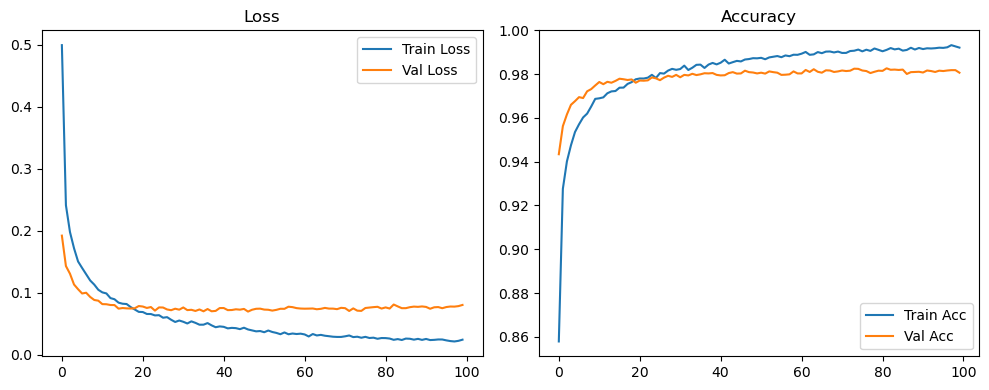

🏆 Best Config: batch256_lr0.01_0.005_0.001_dp0.2 Accuracy: 0.9876


In [8]:
root_path = "MLP_256_float_regular_SiLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)